Pairwise tests (cartesian product):



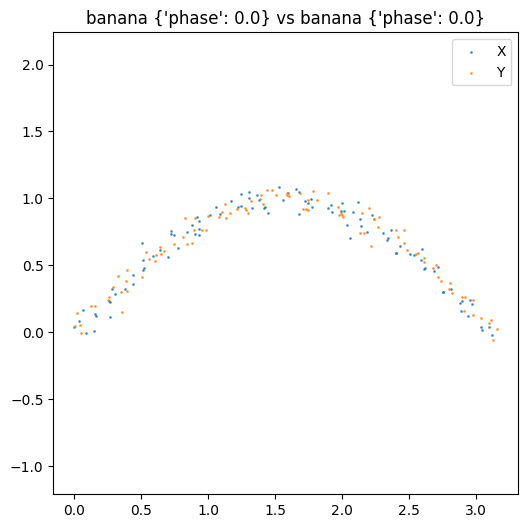

(banana, {'phase': 0.0}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.03174 (time: 0.01s)
   Gromov-Wasserstein:      0.06475717848120485 (time: 0.01s)
   Standard OT:             0.25060913140676117 (time: 0.00s)
   Procrustes OT:           0.24410015992500783 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.04489, 0.010s
      k= 10, t= 1: 0.04643, 0.007s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.03656, 0.000s
      n_proj=1000: 0.03575, 0.021s
      n_proj=10000: 0.03566, 0.187s



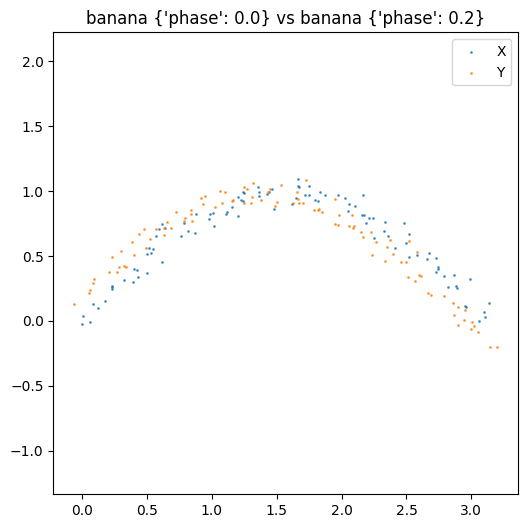

(banana, {'phase': 0.0}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.05143 (time: 0.00s)
   Gromov-Wasserstein:      0.08740605937908195 (time: 0.01s)
   Standard OT:             0.3661328144507625 (time: 0.00s)
   Procrustes OT:           0.26918313275394595 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.0439, 0.013s
      k= 10, t= 1: 0.02899, 0.011s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.08139, 0.000s
      n_proj=1000: 0.08247, 0.028s
      n_proj=10000: 0.08264, 0.170s



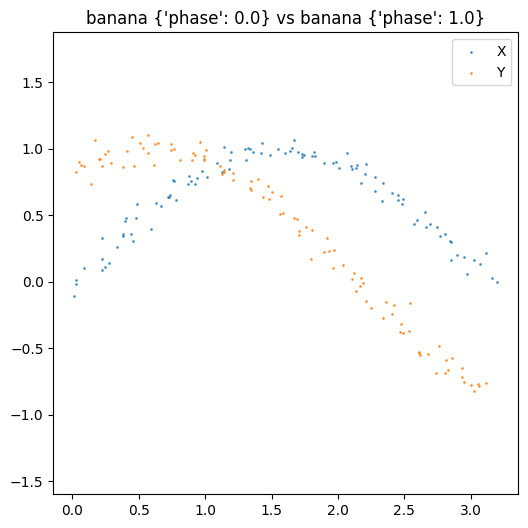

(banana, {'phase': 0.0}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.1825 (time: 0.00s)
   Gromov-Wasserstein:      0.2671508091392275 (time: 0.01s)
   Standard OT:             0.7827273228181929 (time: 0.00s)
   Procrustes OT:           0.5082692873382675 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05686, 0.014s
      k= 10, t= 1: 0.06049, 0.004s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.3727, 0.005s
      n_proj=1000: 0.3839, 0.016s
      n_proj=10000: 0.3846, 0.160s



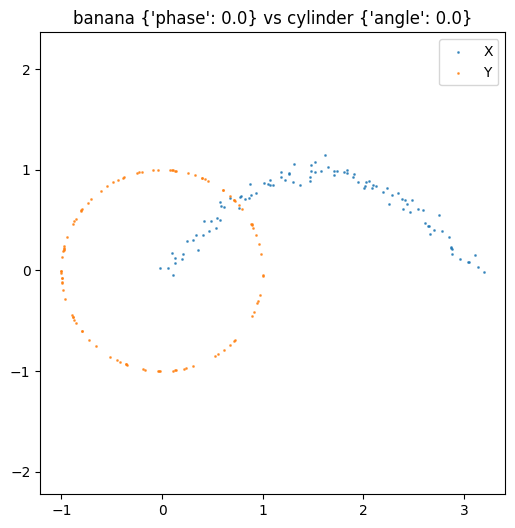

(banana, {'phase': 0.0}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.3212 (time: 0.00s)
   Gromov-Wasserstein:      0.6317594649457086 (time: 0.05s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05908, 0.017s
      k= 10, t= 1: 0.1281, 0.013s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



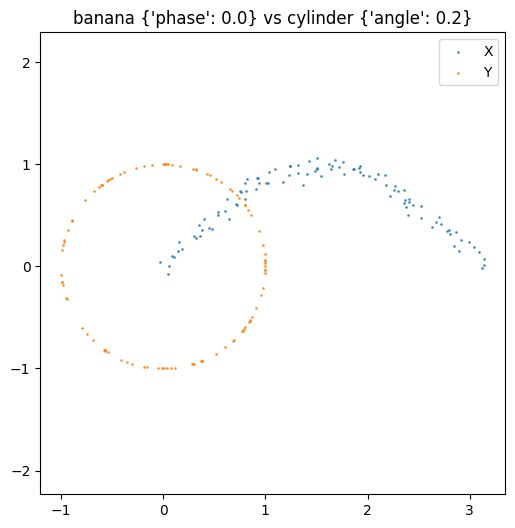

(banana, {'phase': 0.0}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.3049 (time: 0.00s)
   Gromov-Wasserstein:      0.738194710814643 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05465, 0.012s
      k= 10, t= 1: 0.1334, 0.013s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



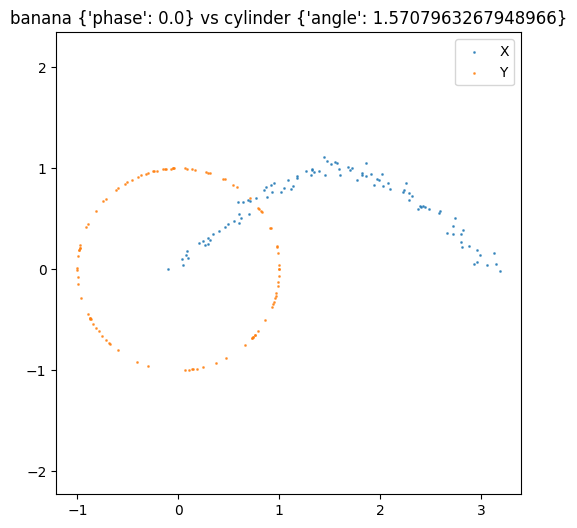

(banana, {'phase': 0.0}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.3182 (time: 0.00s)
   Gromov-Wasserstein:      0.7436482598017728 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06708, 0.021s
      k= 10, t= 1: 0.1376, 0.009s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



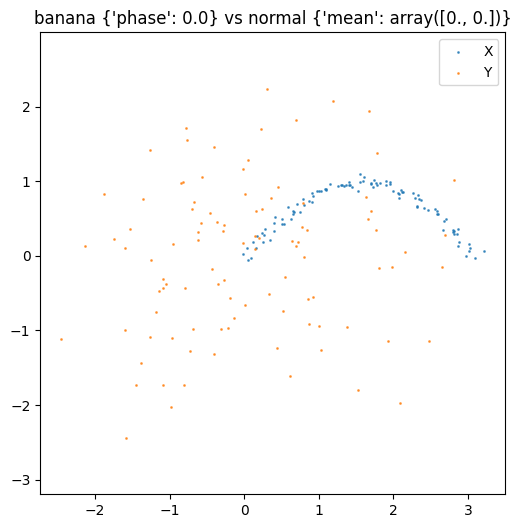

(banana, {'phase': 0.0}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.5363 (time: 0.01s)
   Gromov-Wasserstein:      0.9989065754207886 (time: 0.04s)
   Standard OT:             1.3396381747787502 (time: 0.00s)
   Procrustes OT:           0.905198910709465 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.08878, 0.008s
      k= 10, t= 1: 0.1287, 0.000s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.352, 0.001s
      n_proj=1000: 1.296, 0.026s
      n_proj=10000: 1.292, 0.190s



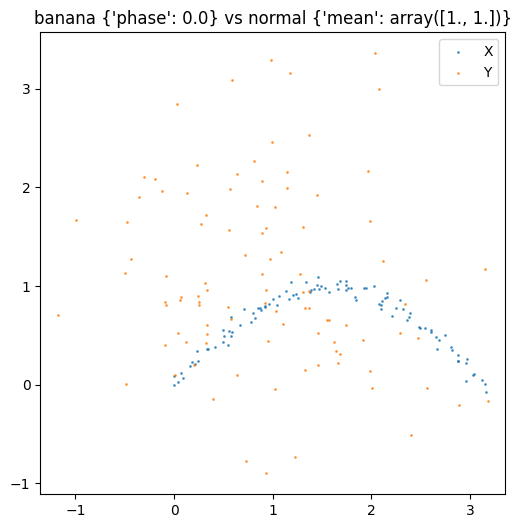

(banana, {'phase': 0.0}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.3963 (time: 0.00s)
   Gromov-Wasserstein:      0.6610111858890841 (time: 0.03s)
   Standard OT:             0.9708120086629548 (time: 0.00s)
   Procrustes OT:           0.8342265496636753 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.08274, 0.015s
      k= 10, t= 1: 0.1266, 0.012s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.6603, 0.000s
      n_proj=1000: 0.6839, 0.020s
      n_proj=10000: 0.6859, 0.169s



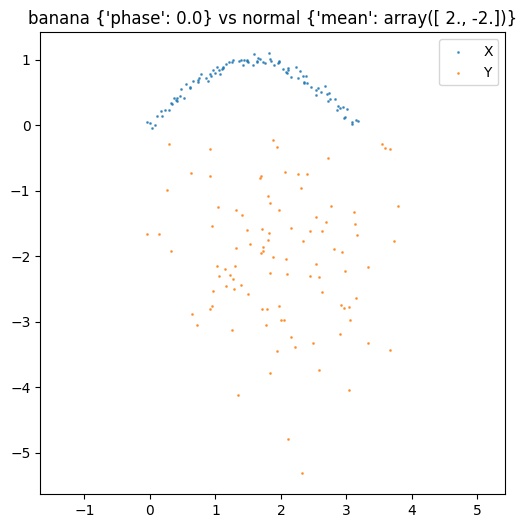

(banana, {'phase': 0.0}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.4474 (time: 0.01s)
   Gromov-Wasserstein:      0.7842982044829047 (time: 0.02s)
   Standard OT:             1.651554533265709 (time: 0.00s)
   Procrustes OT:           0.7981357272881956 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.0943, 0.018s
      k= 10, t= 1: 0.1536, 0.011s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.903, 0.003s
      n_proj=1000: 1.977, 0.017s
      n_proj=10000: 1.982, 0.182s



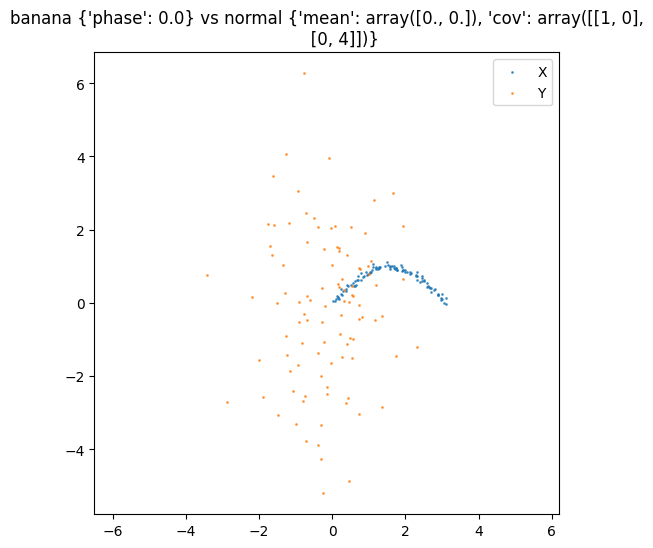

(banana, {'phase': 0.0}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   1.001 (time: 0.00s)
   Gromov-Wasserstein:      1.9935146004337372 (time: 0.01s)
   Standard OT:             1.5481876234978778 (time: 0.00s)
   Procrustes OT:           1.1191627678007792 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1063, 0.025s
      k= 10, t= 1: 0.1598, 0.008s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.822, 0.006s
      n_proj=1000: 1.785, 0.012s
      n_proj=10000: 1.781, 0.168s



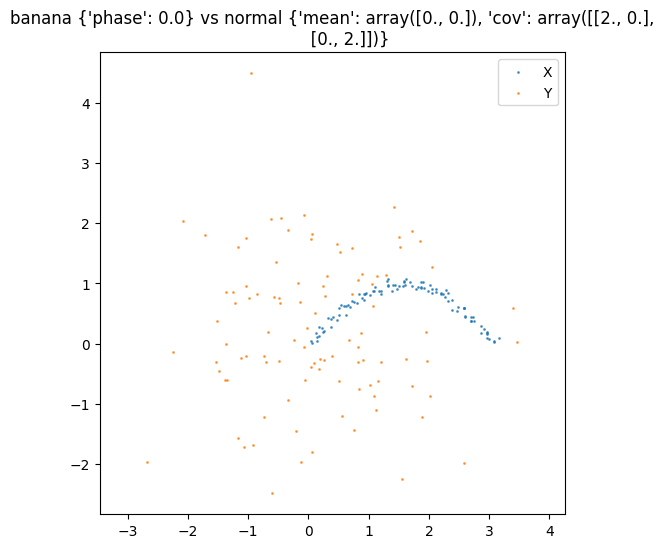

(banana, {'phase': 0.0}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.6931 (time: 0.00s)
   Gromov-Wasserstein:      1.2822153847318687 (time: 0.03s)
   Standard OT:             1.3186853090031028 (time: 0.00s)
   Procrustes OT:           0.9485722373876585 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1265, 0.027s
      k= 10, t= 1: 0.1658, 0.056s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.284, 0.002s
      n_proj=1000: 1.25, 0.016s
      n_proj=10000: 1.247, 0.177s



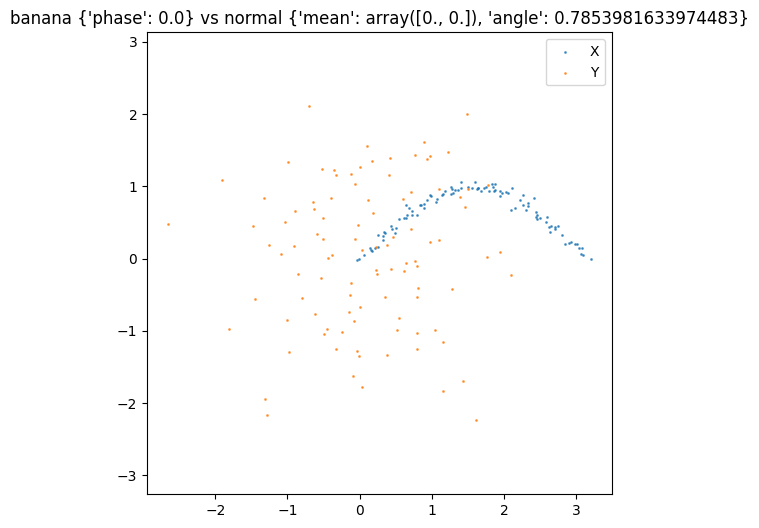

(banana, {'phase': 0.0}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.4557 (time: 0.01s)
   Gromov-Wasserstein:      0.8071943925793328 (time: 0.01s)
   Standard OT:             1.304076210681853 (time: 0.00s)
   Procrustes OT:           0.8354497446728658 (time: 0.03s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07961, 0.012s
      k= 10, t= 1: 0.1255, 0.013s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.27, 0.003s
      n_proj=1000: 1.22, 0.017s
      n_proj=10000: 1.215, 0.166s



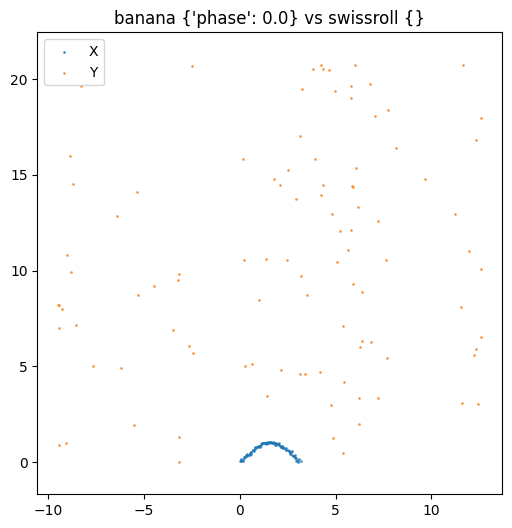

(banana, {'phase': 0.0}) vs (swissroll, {})
   SlicedWasserstein-PCA:   5.472 (time: 0.00s)
   Gromov-Wasserstein:      10.904739883551597 (time: 0.04s)
   Standard OT:             3.400583240106406 (time: 0.00s)
   Procrustes OT:           2.6791417179000985 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07417, 0.016s
      k= 10, t= 1: 0.1141, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 8.907, 0.000s
      n_proj=1000: 8.941, 0.021s
      n_proj=10000: 8.939, 0.182s



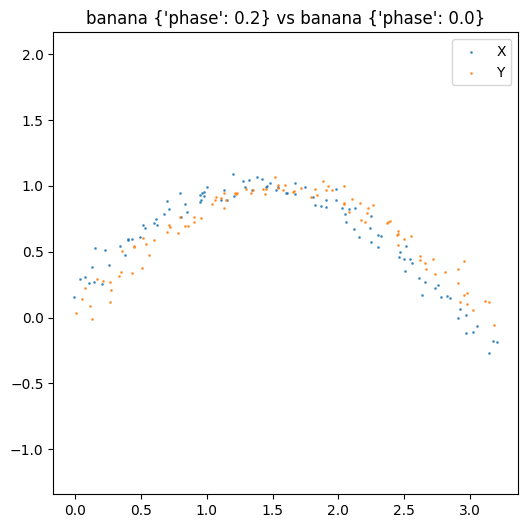

(banana, {'phase': 0.2}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.0515 (time: 0.00s)
   Gromov-Wasserstein:      0.08869310489513899 (time: 0.02s)
   Standard OT:             0.36389548198322436 (time: 0.00s)
   Procrustes OT:           0.2700183143971989 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.04638, 0.016s
      k= 10, t= 1: 0.05293, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.08127, 0.003s
      n_proj=1000: 0.08253, 0.027s
      n_proj=10000: 0.08271, 0.165s



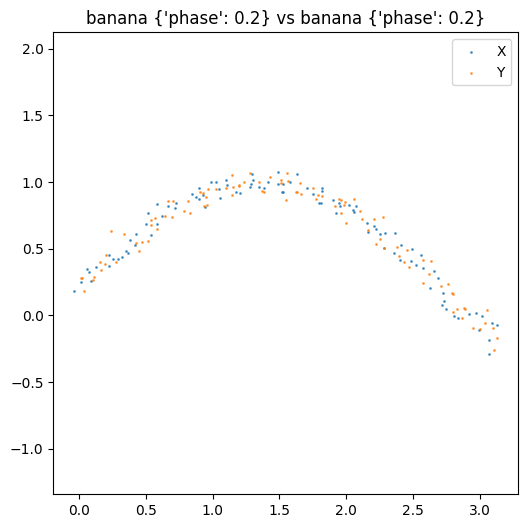

(banana, {'phase': 0.2}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.03447 (time: 0.01s)
   Gromov-Wasserstein:      0.06443204501690043 (time: 0.02s)
   Standard OT:             0.24441821547077863 (time: 0.00s)
   Procrustes OT:           0.24363775888597747 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.04081, 0.011s
      k= 10, t= 1: 0.06827, 0.011s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.03347, 0.002s
      n_proj=1000: 0.03334, 0.016s
      n_proj=10000: 0.03335, 0.164s



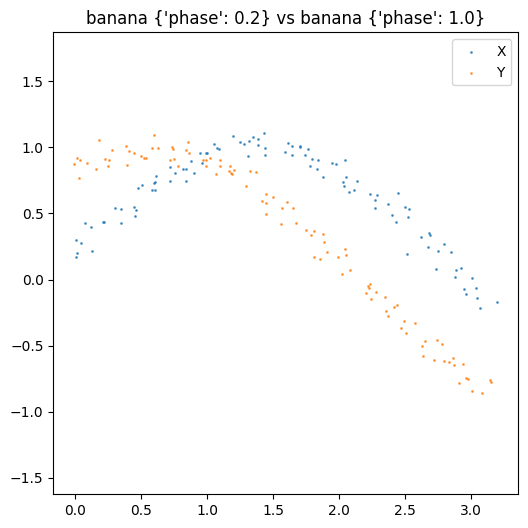

(banana, {'phase': 0.2}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.1655 (time: 0.02s)
   Gromov-Wasserstein:      0.22481439014251478 (time: 0.02s)
   Standard OT:             0.7105119844621574 (time: 0.00s)
   Procrustes OT:           0.48312926556019586 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05412, 0.017s
      k= 10, t= 1: 0.04996, 0.008s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.3231, 0.003s
      n_proj=1000: 0.333, 0.017s
      n_proj=10000: 0.3335, 0.158s



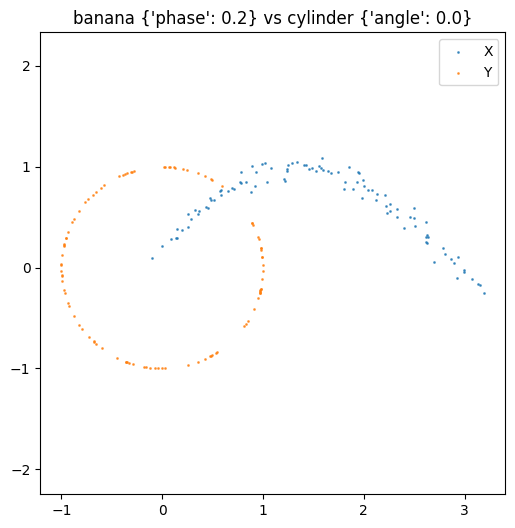

(banana, {'phase': 0.2}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.3128 (time: 0.00s)
   Gromov-Wasserstein:      0.6900151966346991 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07109, 0.007s
      k= 10, t= 1: 0.1394, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



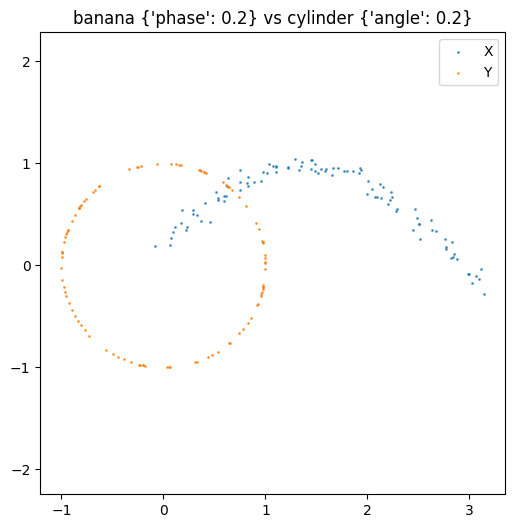

(banana, {'phase': 0.2}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.3019 (time: 0.01s)
   Gromov-Wasserstein:      0.6615569492101633 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06495, 0.033s
      k= 10, t= 1: 0.1286, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



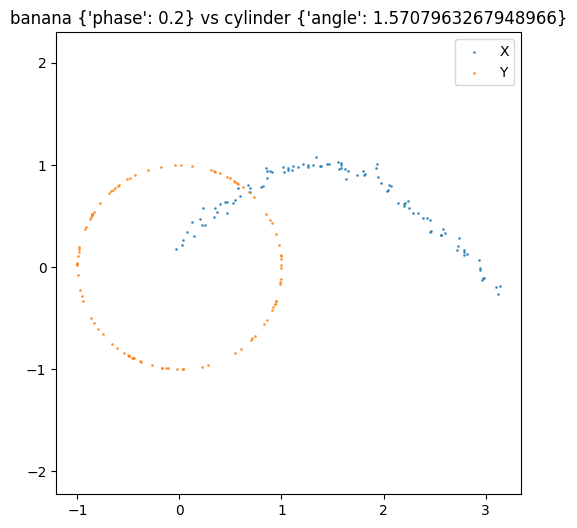

(banana, {'phase': 0.2}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.3181 (time: 0.00s)
   Gromov-Wasserstein:      0.7199021535961484 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06632, 0.020s
      k= 10, t= 1: 0.1425, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



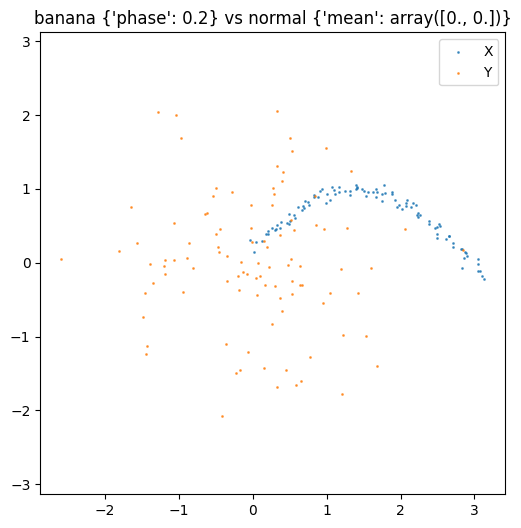

(banana, {'phase': 0.2}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.4359 (time: 0.00s)
   Gromov-Wasserstein:      0.7296199564149979 (time: 0.02s)
   Standard OT:             1.3248336268857852 (time: 0.00s)
   Procrustes OT:           0.8165113328319341 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07958, 0.016s
      k= 10, t= 1: 0.1478, 0.008s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.321, 0.005s
      n_proj=1000: 1.264, 0.022s
      n_proj=10000: 1.259, 0.217s



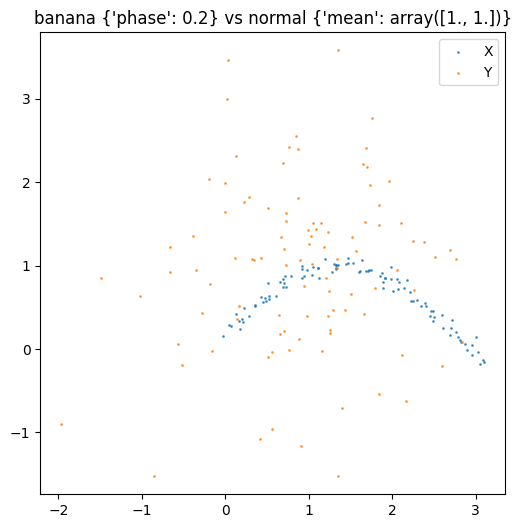

(banana, {'phase': 0.2}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.4841 (time: 0.01s)
   Gromov-Wasserstein:      0.8654437861384345 (time: 0.02s)
   Standard OT:             0.999841926494248 (time: 0.00s)
   Procrustes OT:           0.8150823046471102 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1091, 0.020s
      k= 10, t= 1: 0.1793, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.6848, 0.002s
      n_proj=1000: 0.697, 0.022s
      n_proj=10000: 0.6981, 0.174s



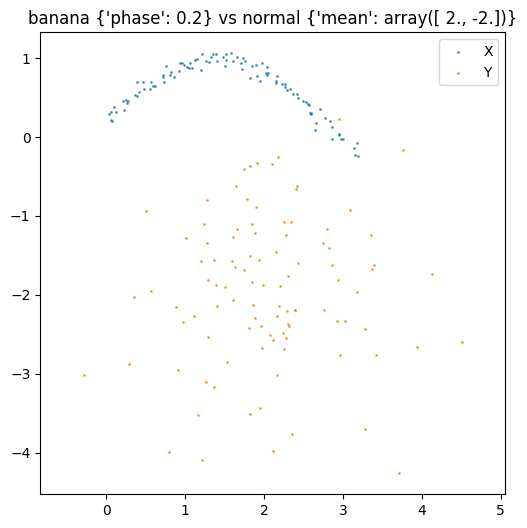

(banana, {'phase': 0.2}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.4391 (time: 0.00s)
   Gromov-Wasserstein:      0.7348529045918679 (time: 0.03s)
   Standard OT:             1.6238594369696864 (time: 0.00s)
   Procrustes OT:           0.7925946024266469 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.09937, 0.029s
      k= 10, t= 1: 0.1603, 0.008s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.825, 0.008s
      n_proj=1000: 1.899, 0.024s
      n_proj=10000: 1.904, 0.175s



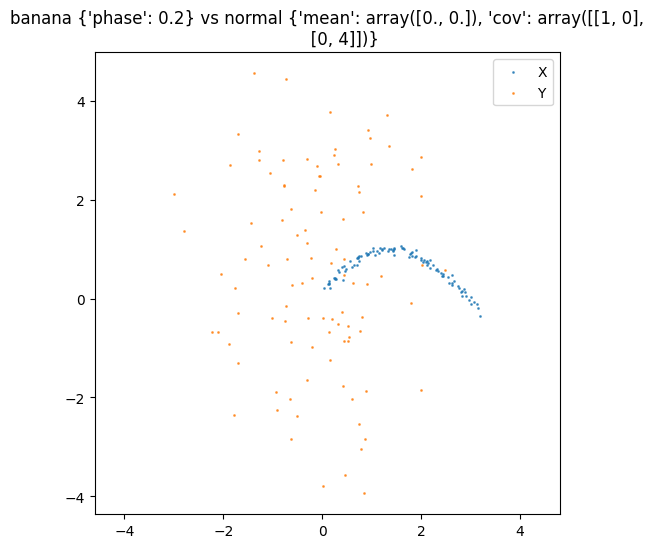

(banana, {'phase': 0.2}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   0.9458 (time: 0.00s)
   Gromov-Wasserstein:      1.875364126118466 (time: 0.02s)
   Standard OT:             1.5145341646627 (time: 0.00s)
   Procrustes OT:           1.12674005626823 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07795, 0.008s
      k= 10, t= 1: 0.1028, 0.000s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.64, 0.016s
      n_proj=1000: 1.627, 0.024s
      n_proj=10000: 1.625, 0.168s



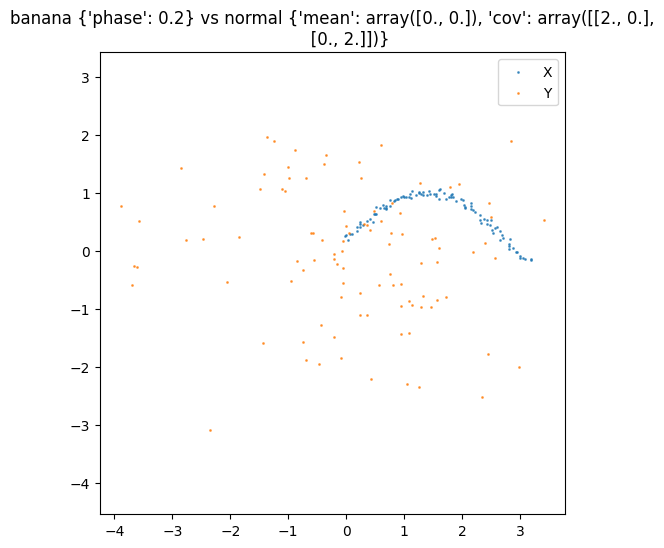

(banana, {'phase': 0.2}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.7601 (time: 0.00s)
   Gromov-Wasserstein:      1.4523677713801917 (time: 0.03s)
   Standard OT:             1.3564730008543309 (time: 0.00s)
   Procrustes OT:           0.998026928416752 (time: 0.03s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.0988, 0.009s
      k= 10, t= 1: 0.1651, 0.024s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.44, 0.000s
      n_proj=1000: 1.391, 0.022s
      n_proj=10000: 1.387, 0.195s



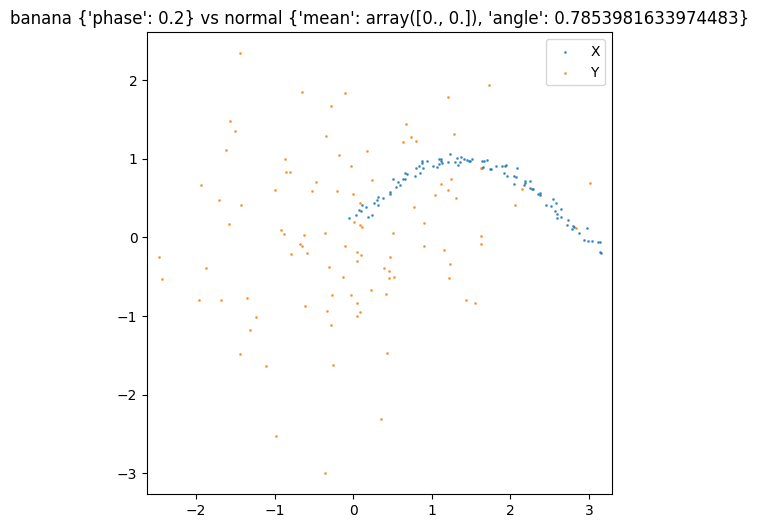

(banana, {'phase': 0.2}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.5202 (time: 0.00s)
   Gromov-Wasserstein:      0.9326450504648494 (time: 0.04s)
   Standard OT:             1.3423149736084412 (time: 0.01s)
   Procrustes OT:           0.8463951045581374 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.08986, 0.014s
      k= 10, t= 1: 0.1423, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.369, 0.000s
      n_proj=1000: 1.313, 0.024s
      n_proj=10000: 1.308, 0.247s



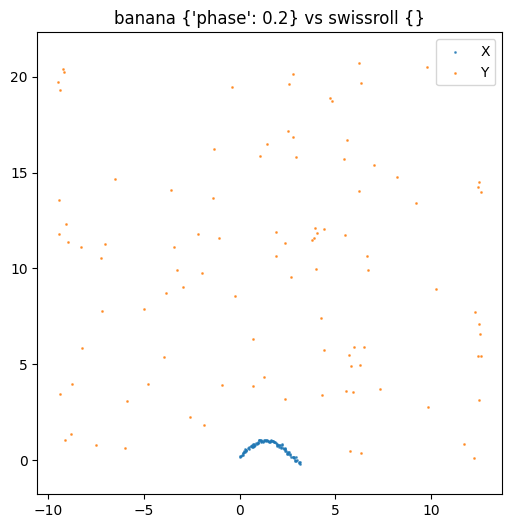

(banana, {'phase': 0.2}) vs (swissroll, {})
   SlicedWasserstein-PCA:   5.658 (time: 0.00s)
   Gromov-Wasserstein:      11.26459706738595 (time: 0.05s)
   Standard OT:             3.35918276756477 (time: 0.00s)
   Procrustes OT:           2.723922734269849 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06721, 0.020s
      k= 10, t= 1: 0.1226, 0.009s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 8.575, 0.000s
      n_proj=1000: 8.687, 0.032s
      n_proj=10000: 8.693, 0.267s



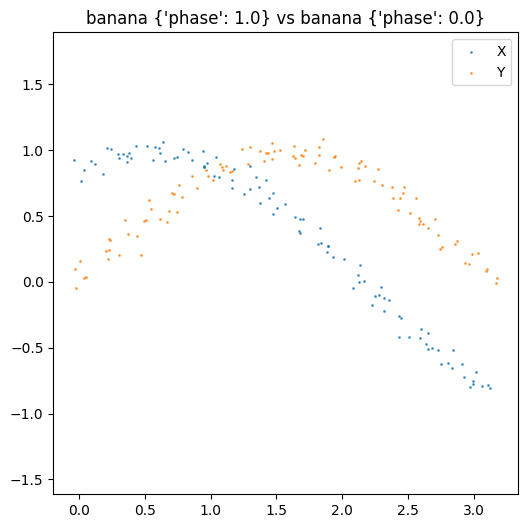

(banana, {'phase': 1.0}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.1899 (time: 0.00s)
   Gromov-Wasserstein:      0.2561640915689728 (time: 0.02s)
   Standard OT:             0.7803618068455165 (time: 0.00s)
   Procrustes OT:           0.5121545188155214 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05426, 0.022s
      k= 10, t= 1: 0.07385, 0.010s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.3742, 0.007s
      n_proj=1000: 0.3847, 0.022s
      n_proj=10000: 0.3854, 0.226s



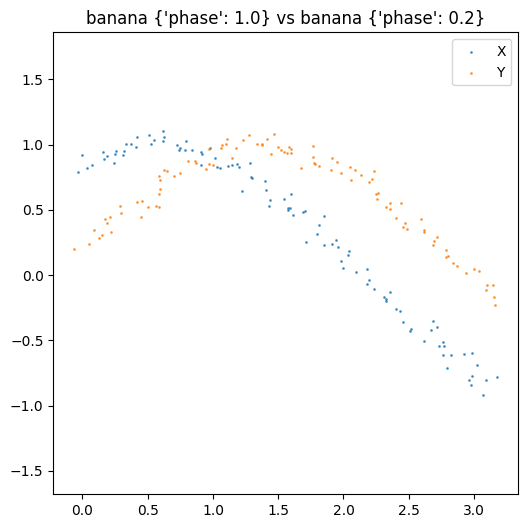

(banana, {'phase': 1.0}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.1657 (time: 0.01s)
   Gromov-Wasserstein:      0.23712079649112205 (time: 0.02s)
   Standard OT:             0.7082852346814635 (time: 0.00s)
   Procrustes OT:           0.4822350780405014 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.04932, 0.004s
      k= 10, t= 1: 0.07901, 0.028s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.318, 0.002s
      n_proj=1000: 0.3274, 0.016s
      n_proj=10000: 0.3279, 0.204s



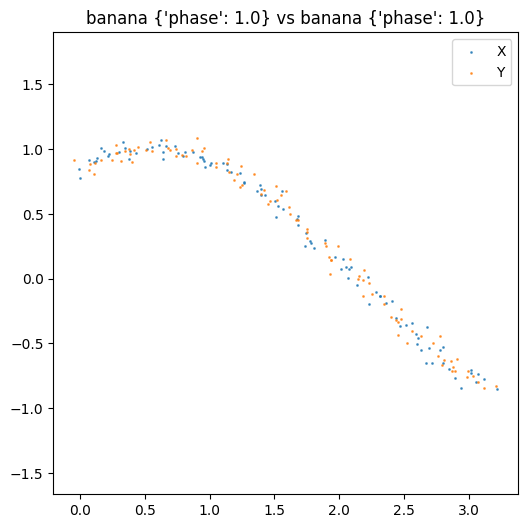

(banana, {'phase': 1.0}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.03926 (time: 0.00s)
   Gromov-Wasserstein:      0.07282748994601758 (time: 0.02s)
   Standard OT:             0.25120152651091143 (time: 0.00s)
   Procrustes OT:           0.2507713133302053 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05476, 0.021s
      k= 10, t= 1: 0.09604, 0.018s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.03721, 0.002s
      n_proj=1000: 0.03792, 0.025s
      n_proj=10000: 0.03804, 0.193s



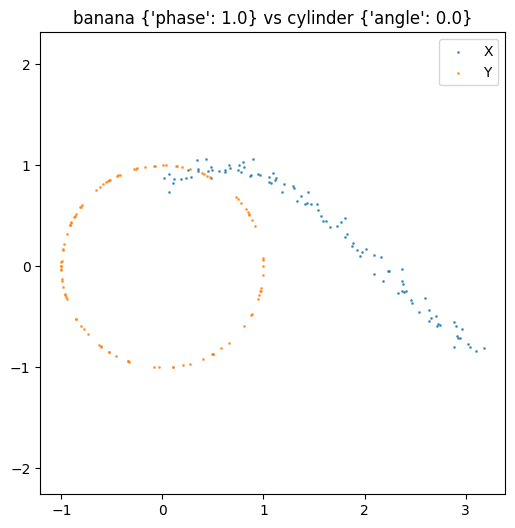

(banana, {'phase': 1.0}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.4678 (time: 0.01s)
   Gromov-Wasserstein:      0.691034365781868 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05912, 0.019s
      k= 10, t= 1: 0.1866, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



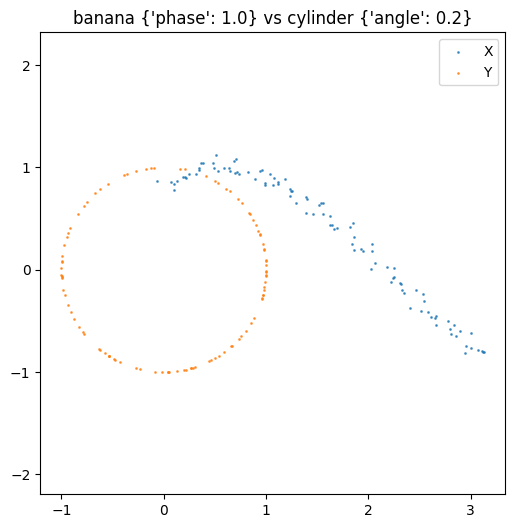

(banana, {'phase': 1.0}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.4577 (time: 0.00s)
   Gromov-Wasserstein:      0.6732583802104192 (time: 0.06s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06201, 0.019s
      k= 10, t= 1: 0.1697, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



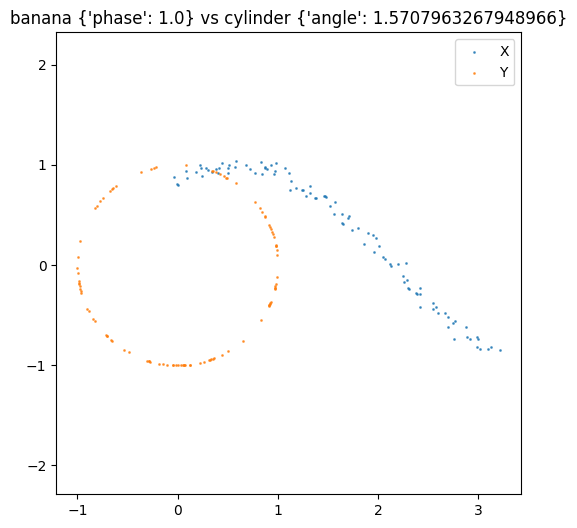

(banana, {'phase': 1.0}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.4604 (time: 0.00s)
   Gromov-Wasserstein:      0.6969220318774517 (time: 0.05s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06035, 0.026s
      k= 10, t= 1: 0.1742, 0.023s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



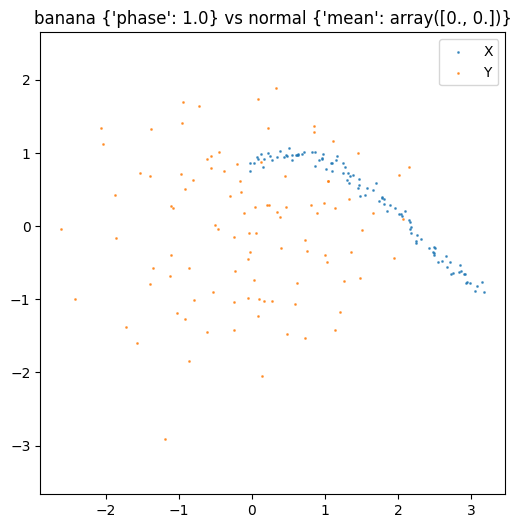

(banana, {'phase': 1.0}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.5815 (time: 0.01s)
   Gromov-Wasserstein:      0.8102623463823933 (time: 0.02s)
   Standard OT:             1.3159147885781861 (time: 0.00s)
   Procrustes OT:           0.869771556207917 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.09585, 0.028s
      k= 10, t= 1: 0.1711, 0.012s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.324, 0.004s
      n_proj=1000: 1.271, 0.021s
      n_proj=10000: 1.267, 0.226s



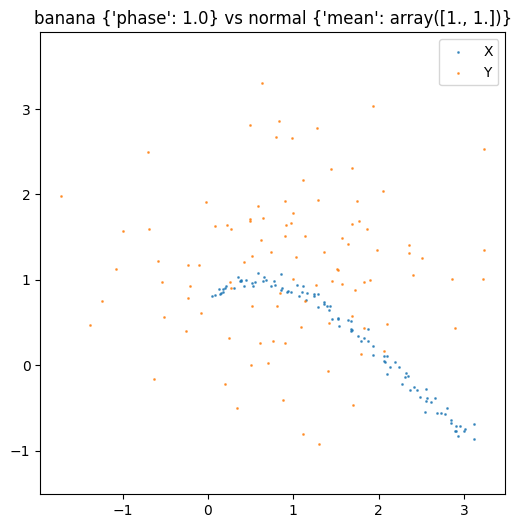

(banana, {'phase': 1.0}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.5378 (time: 0.00s)
   Gromov-Wasserstein:      0.7504464933475797 (time: 0.03s)
   Standard OT:             1.1159493411664922 (time: 0.00s)
   Procrustes OT:           0.819615853885693 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1056, 0.029s
      k= 10, t= 1: 0.1751, 0.011s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.8252, 0.000s
      n_proj=1000: 0.8532, 0.025s
      n_proj=10000: 0.8559, 0.190s



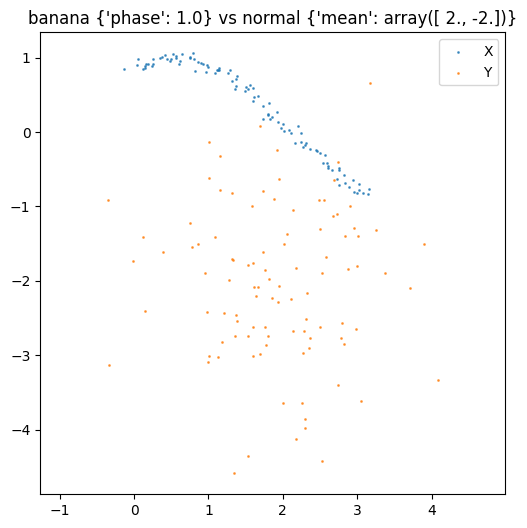

(banana, {'phase': 1.0}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.5421 (time: 0.01s)
   Gromov-Wasserstein:      0.7520642185692205 (time: 0.02s)
   Standard OT:             1.5572804080868308 (time: 0.00s)
   Procrustes OT:           0.8298405198167365 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1235, 0.013s
      k= 10, t= 1: 0.1768, 0.012s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.705, 0.000s
      n_proj=1000: 1.763, 0.021s
      n_proj=10000: 1.767, 0.191s



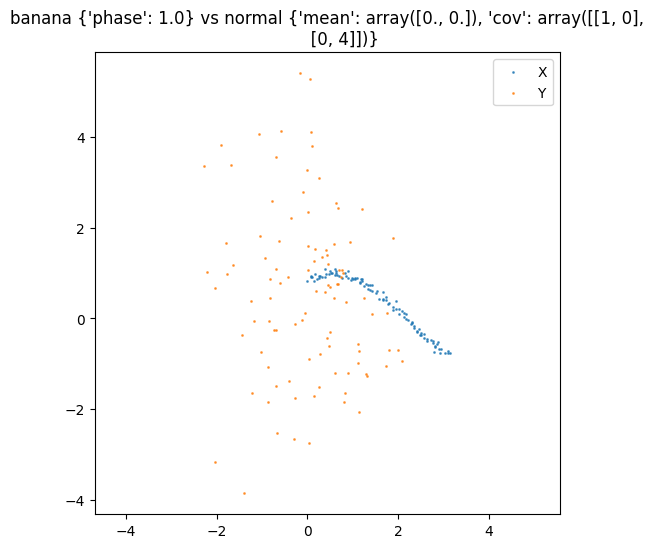

(banana, {'phase': 1.0}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   0.8456 (time: 0.00s)
   Gromov-Wasserstein:      1.5717986950334963 (time: 0.03s)
   Standard OT:             1.415028708274978 (time: 0.00s)
   Procrustes OT:           1.0332531086509862 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.08804, 0.016s
      k= 10, t= 1: 0.181, 0.008s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.479, 0.009s
      n_proj=1000: 1.47, 0.019s
      n_proj=10000: 1.47, 0.168s



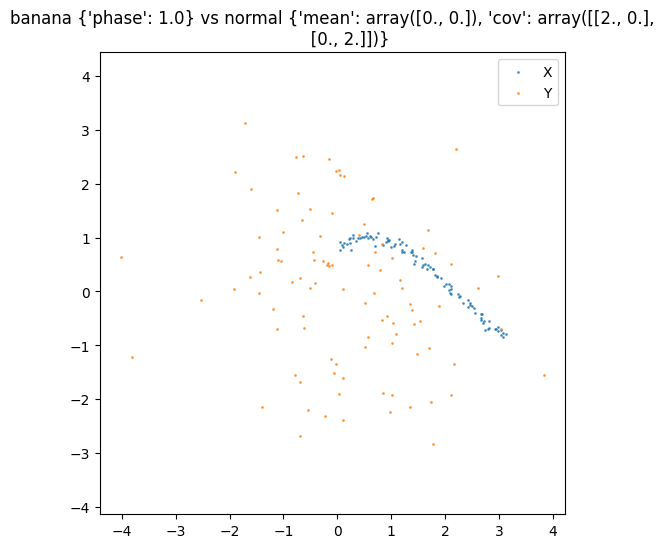

(banana, {'phase': 1.0}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.8128 (time: 0.00s)
   Gromov-Wasserstein:      1.534651539409033 (time: 0.03s)
   Standard OT:             1.30172567374532 (time: 0.00s)
   Procrustes OT:           1.0009402431075423 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1333, 0.026s
      k= 10, t= 1: 0.1713, 0.022s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.301, 0.008s
      n_proj=1000: 1.258, 0.016s
      n_proj=10000: 1.255, 0.211s



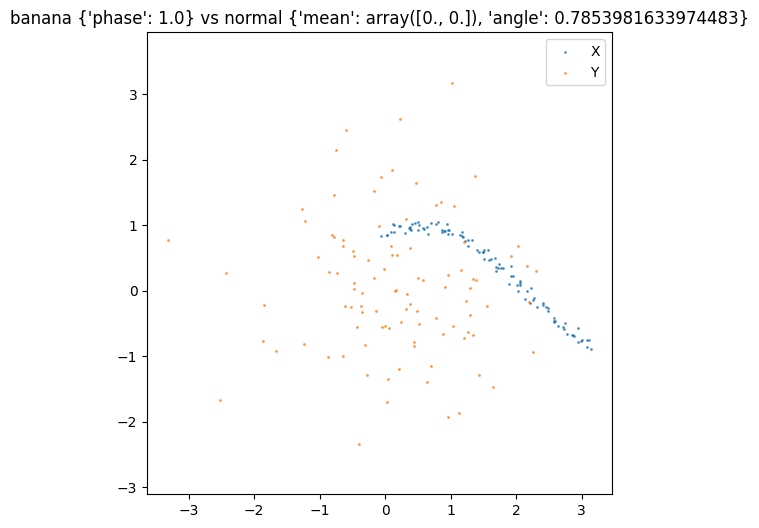

(banana, {'phase': 1.0}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.636 (time: 0.00s)
   Gromov-Wasserstein:      0.8680697693456173 (time: 0.03s)
   Standard OT:             1.247944085515337 (time: 0.00s)
   Procrustes OT:           0.9308067187903327 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1274, 0.014s
      k= 10, t= 1: 0.2042, 0.008s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.172, 0.004s
      n_proj=1000: 1.128, 0.027s
      n_proj=10000: 1.125, 0.212s



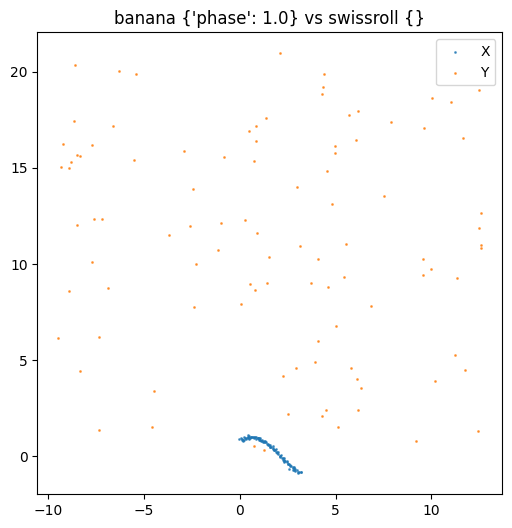

(banana, {'phase': 1.0}) vs (swissroll, {})
   SlicedWasserstein-PCA:   5.51 (time: 0.00s)
   Gromov-Wasserstein:      10.856033563870405 (time: 0.02s)
   Standard OT:             3.5100134688318283 (time: 0.00s)
   Procrustes OT:           2.6960712545151866 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06739, 0.016s
      k= 10, t= 1: 0.1371, 0.006s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 9.262, 0.008s
      n_proj=1000: 9.39, 0.016s
      n_proj=10000: 9.396, 0.186s



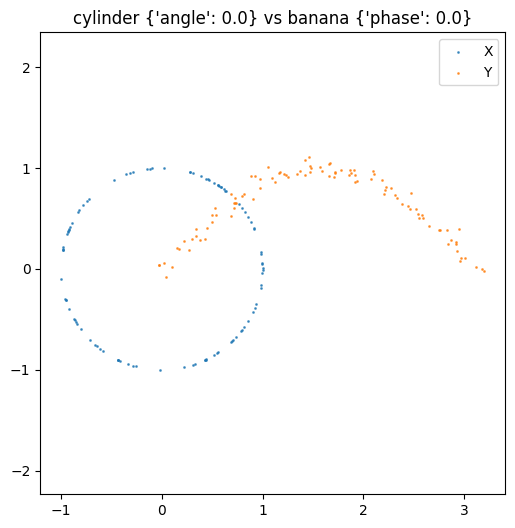

(cylinder, {'angle': 0.0}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.3544 (time: 0.00s)
   Gromov-Wasserstein:      0.6937798396359562 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07082, 0.016s
      k= 10, t= 1: 0.2472, 0.011s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



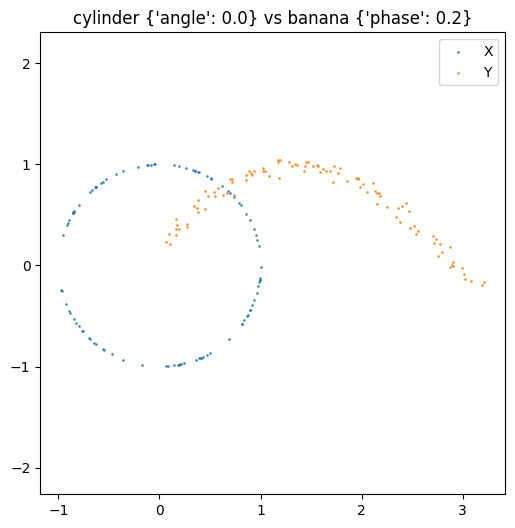

(cylinder, {'angle': 0.0}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.371 (time: 0.00s)
   Gromov-Wasserstein:      0.6617648309681137 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06323, 0.015s
      k= 10, t= 1: 0.2421, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



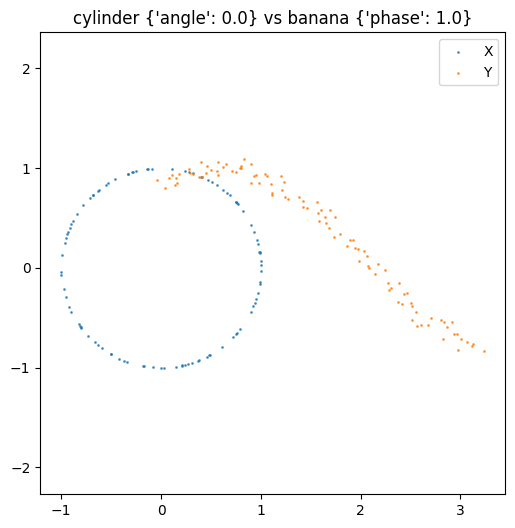

(cylinder, {'angle': 0.0}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.5378 (time: 0.00s)
   Gromov-Wasserstein:      0.715754126857902 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06601, 0.013s
      k= 10, t= 1: 0.2741, 0.008s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



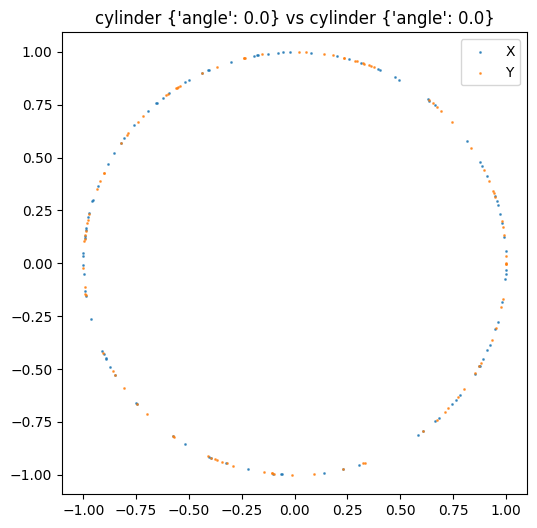

(cylinder, {'angle': 0.0}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.1015 (time: 0.00s)
   Gromov-Wasserstein:      0.3762702169225904 (time: 0.02s)
   Standard OT:             0.5139234703534737 (time: 0.00s)
   Procrustes OT:           0.5304325854989558 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05452, 0.011s
      k= 10, t= 1: 0.07382, 0.012s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.0793, 0.004s
      n_proj=1000: 0.07936, 0.027s
      n_proj=10000: 0.07905, 0.359s



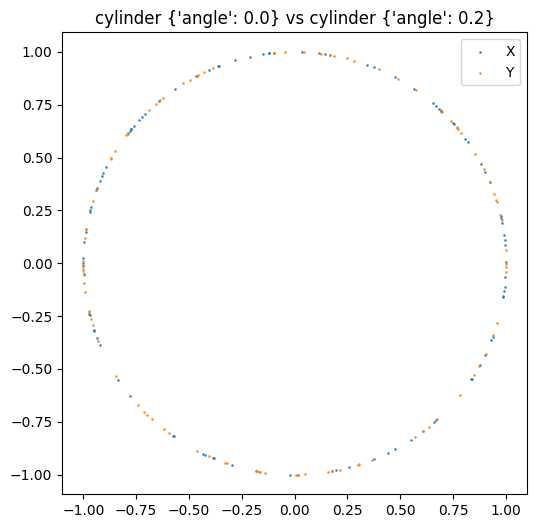

(cylinder, {'angle': 0.0}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.09703 (time: 0.01s)
   Gromov-Wasserstein:      0.22482225423794244 (time: 0.03s)
   Standard OT:             0.5134282472079436 (time: 0.00s)
   Procrustes OT:           0.5297983361889463 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05693, 0.025s
      k= 10, t= 1: 0.06579, 0.021s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.08967, 0.002s
      n_proj=1000: 0.08912, 0.022s
      n_proj=10000: 0.08964, 0.198s



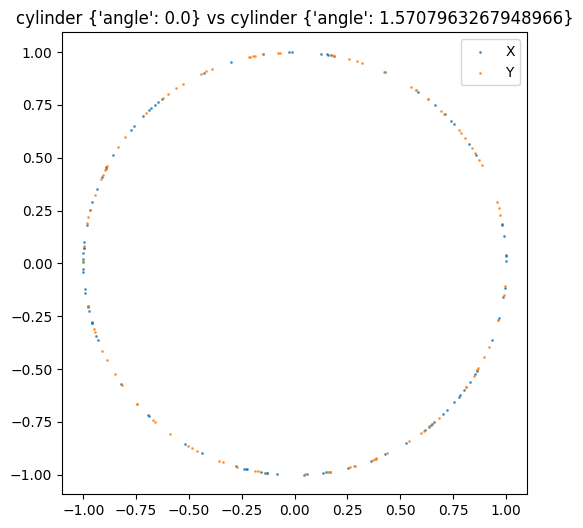

(cylinder, {'angle': 0.0}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.07518 (time: 0.00s)
   Gromov-Wasserstein:      0.4142319991256282 (time: 0.03s)
   Standard OT:             0.5935976516887737 (time: 0.00s)
   Procrustes OT:           0.6165584763354313 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06416, 0.010s
      k= 10, t= 1: 0.05851, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.1386, 0.002s
      n_proj=1000: 0.1355, 0.016s
      n_proj=10000: 0.136, 0.195s



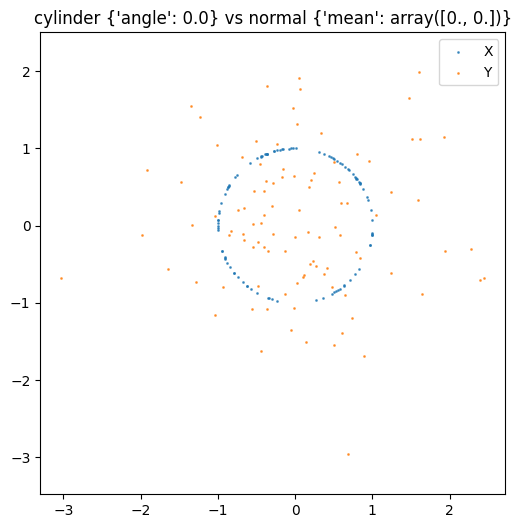

(cylinder, {'angle': 0.0}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.4024 (time: 0.00s)
   Gromov-Wasserstein:      0.6508434226015225 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1503, 0.008s
      k= 10, t= 1: 0.2246, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



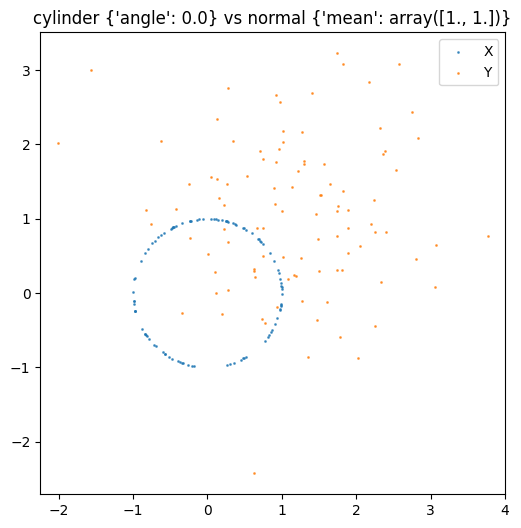

(cylinder, {'angle': 0.0}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.4511 (time: 0.00s)
   Gromov-Wasserstein:      0.7591368118393983 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1557, 0.018s
      k= 10, t= 1: 0.2294, 0.008s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



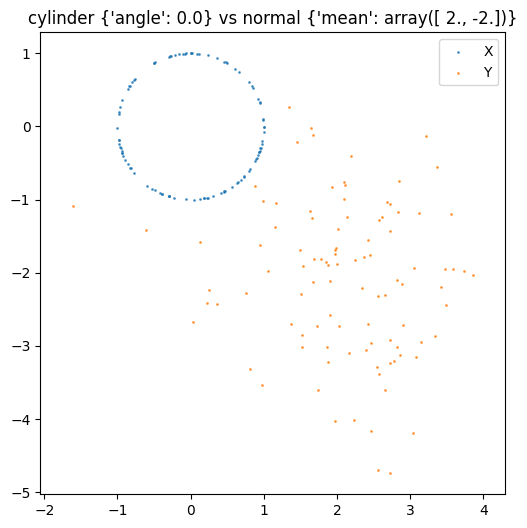

(cylinder, {'angle': 0.0}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.4722 (time: 0.00s)
   Gromov-Wasserstein:      0.7584117427914561 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1182, 0.009s
      k= 10, t= 1: 0.241, 0.022s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



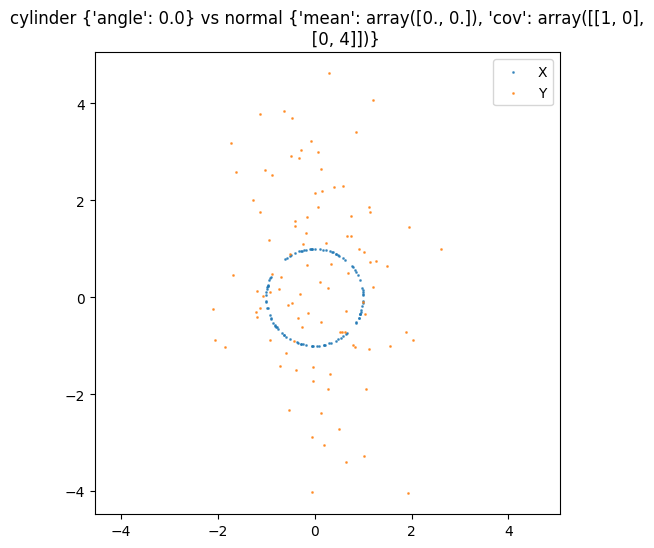

(cylinder, {'angle': 0.0}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   1.021 (time: 0.00s)
   Gromov-Wasserstein:      1.5948275119243525 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1281, 0.016s
      k= 10, t= 1: 0.1998, 0.025s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



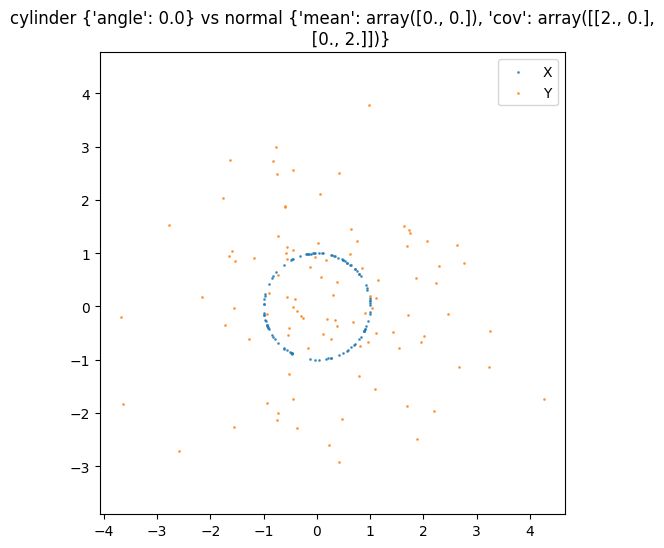

(cylinder, {'angle': 0.0}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.9053 (time: 0.00s)
   Gromov-Wasserstein:      1.4557521481550248 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.125, 0.013s
      k= 10, t= 1: 0.1863, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



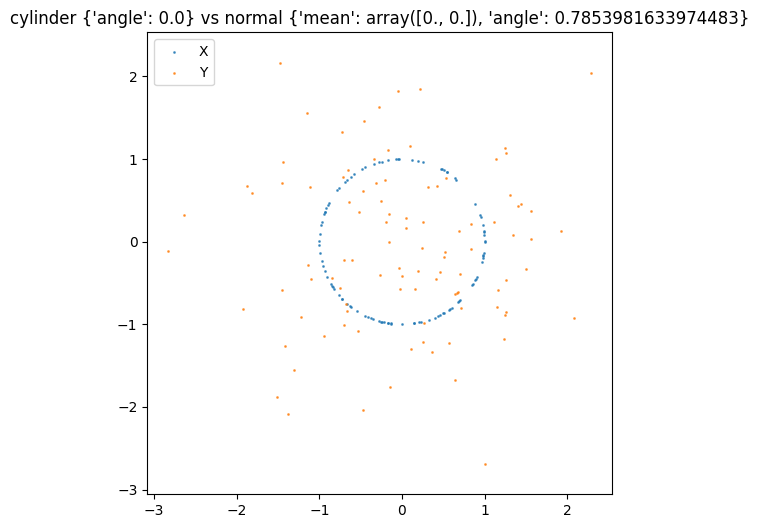

(cylinder, {'angle': 0.0}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.4369 (time: 0.01s)
   Gromov-Wasserstein:      0.7118311913271376 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1336, 0.008s
      k= 10, t= 1: 0.1894, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



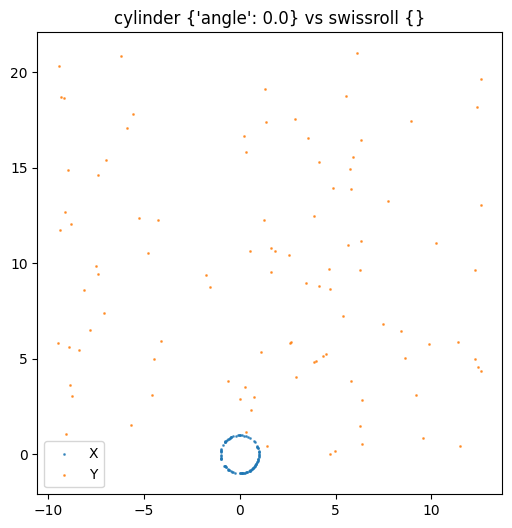

(cylinder, {'angle': 0.0}) vs (swissroll, {})
   SlicedWasserstein-PCA:   6.37 (time: 0.00s)
   Gromov-Wasserstein:      10.897402875877937 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07293, 0.008s
      k= 10, t= 1: 0.1323, 0.024s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



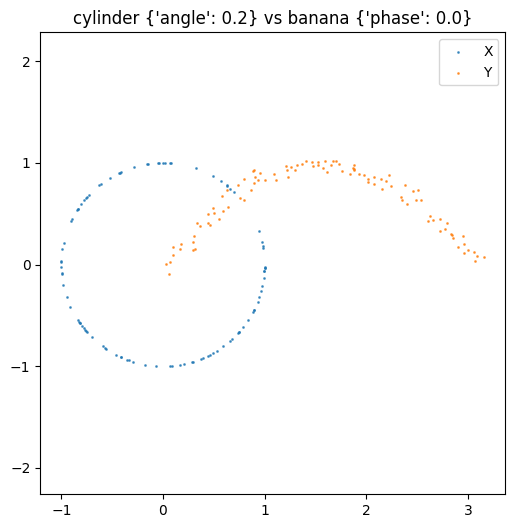

(cylinder, {'angle': 0.2}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.331 (time: 0.01s)
   Gromov-Wasserstein:      0.6897884203202519 (time: 0.07s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05734, 0.031s
      k= 10, t= 1: 0.2269, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



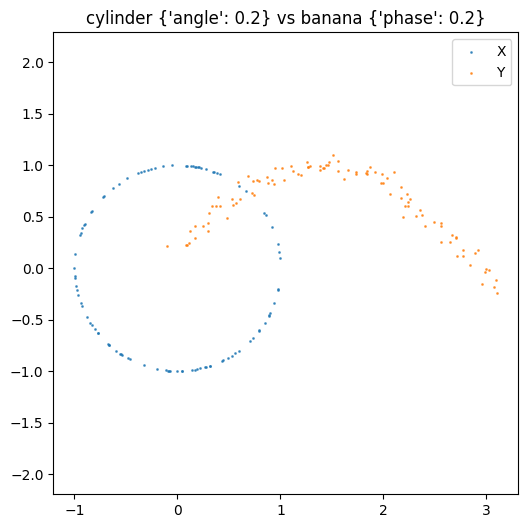

(cylinder, {'angle': 0.2}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.3422 (time: 0.00s)
   Gromov-Wasserstein:      0.7324992870756204 (time: 0.05s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06775, 0.013s
      k= 10, t= 1: 0.2449, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



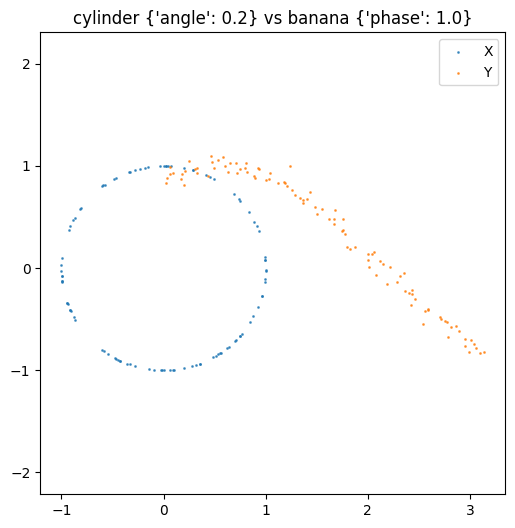

(cylinder, {'angle': 0.2}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.5148 (time: 0.00s)
   Gromov-Wasserstein:      0.7205791367586668 (time: 0.05s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07485, 0.009s
      k= 10, t= 1: 0.2796, 0.026s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



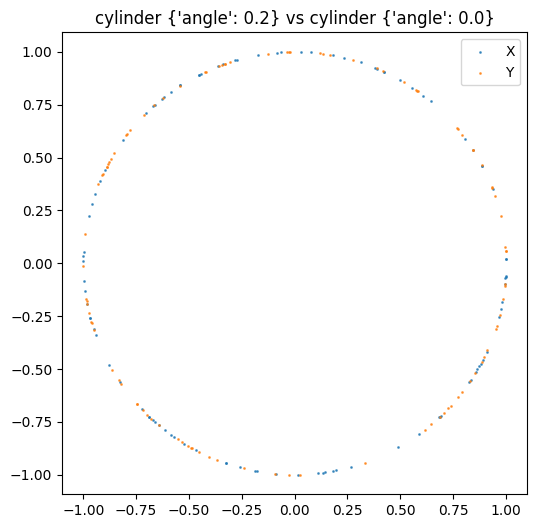

(cylinder, {'angle': 0.2}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.0756 (time: 0.00s)
   Gromov-Wasserstein:      0.3275915236689432 (time: 0.03s)
   Standard OT:             0.5582245417876502 (time: 0.00s)
   Procrustes OT:           0.5348234638947014 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.0438, 0.018s
      k= 10, t= 1: 0.06033, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.1078, 0.009s
      n_proj=1000: 0.1125, 0.022s
      n_proj=10000: 0.1126, 0.239s



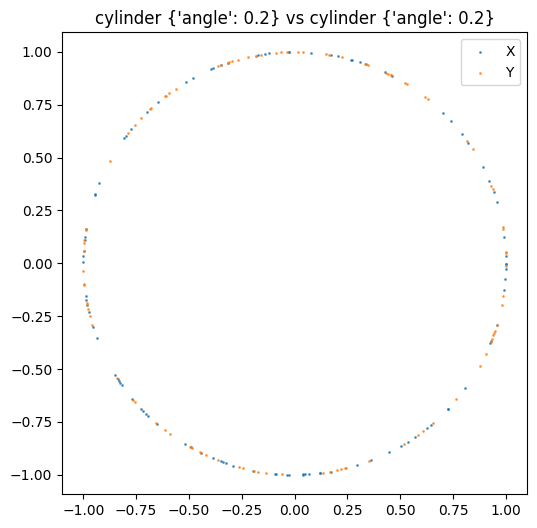

(cylinder, {'angle': 0.2}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.09471 (time: 0.00s)
   Gromov-Wasserstein:      0.4077775620542141 (time: 0.02s)
   Standard OT:             0.5727633962164149 (time: 0.00s)
   Procrustes OT:           0.565917418064069 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05675, 0.010s
      k= 10, t= 1: 0.07014, 0.022s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.1358, 0.003s
      n_proj=1000: 0.1362, 0.022s
      n_proj=10000: 0.1379, 0.205s



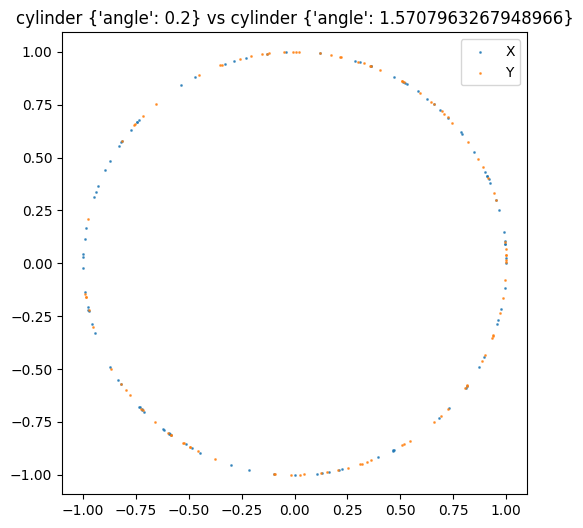

(cylinder, {'angle': 0.2}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.072 (time: 0.01s)
   Gromov-Wasserstein:      0.35822998445074633 (time: 0.02s)
   Standard OT:             0.5784125592667911 (time: 0.01s)
   Procrustes OT:           0.663382574666107 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05292, 0.016s
      k= 10, t= 1: 0.03473, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.1418, 0.000s
      n_proj=1000: 0.1411, 0.017s
      n_proj=10000: 0.1402, 0.209s



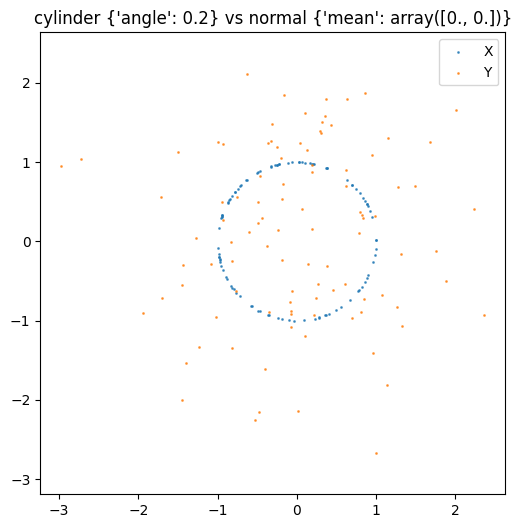

(cylinder, {'angle': 0.2}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.4806 (time: 0.00s)
   Gromov-Wasserstein:      0.7626965524752878 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1069, 0.022s
      k= 10, t= 1: 0.1614, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



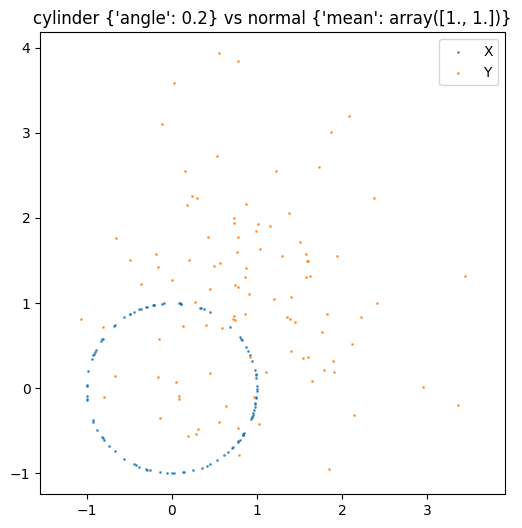

(cylinder, {'angle': 0.2}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.429 (time: 0.00s)
   Gromov-Wasserstein:      0.6995247894123202 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1138, 0.022s
      k= 10, t= 1: 0.1848, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



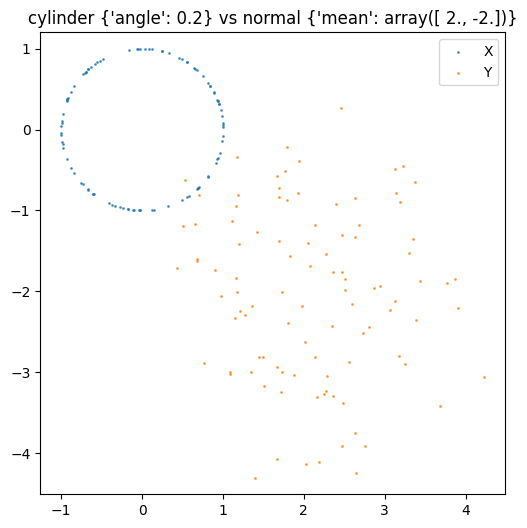

(cylinder, {'angle': 0.2}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.3234 (time: 0.00s)
   Gromov-Wasserstein:      0.5789633443305103 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.08949, 0.020s
      k= 10, t= 1: 0.1409, 0.014s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



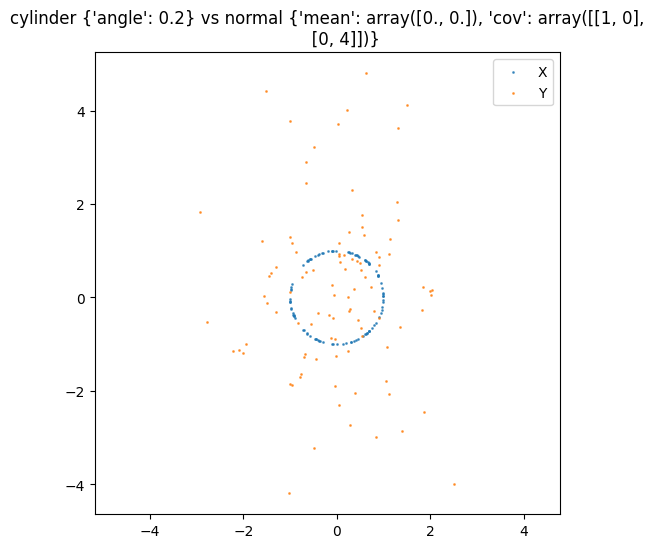

(cylinder, {'angle': 0.2}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   0.9552 (time: 0.00s)
   Gromov-Wasserstein:      1.5971366439267036 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1424, 0.037s
      k= 10, t= 1: 0.2693, 0.030s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



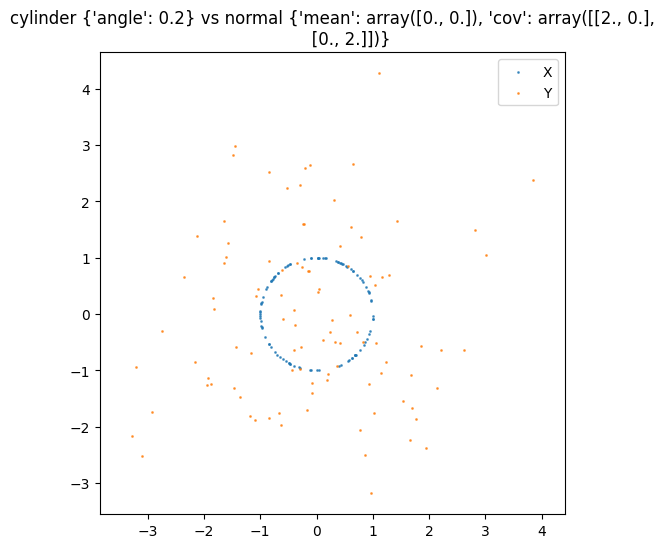

(cylinder, {'angle': 0.2}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.8851 (time: 0.00s)
   Gromov-Wasserstein:      1.5266999448855159 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1208, 0.015s
      k= 10, t= 1: 0.1826, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



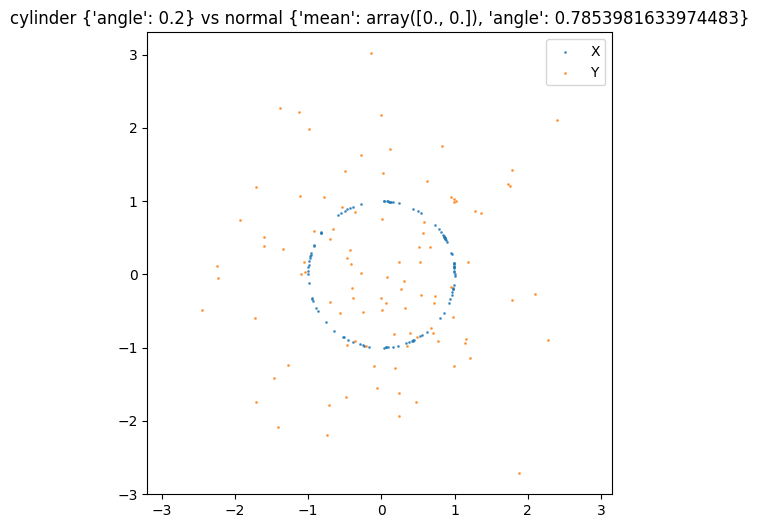

(cylinder, {'angle': 0.2}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.5125 (time: 0.01s)
   Gromov-Wasserstein:      0.8274137475052306 (time: 0.05s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1185, 0.018s
      k= 10, t= 1: 0.1517, 0.014s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



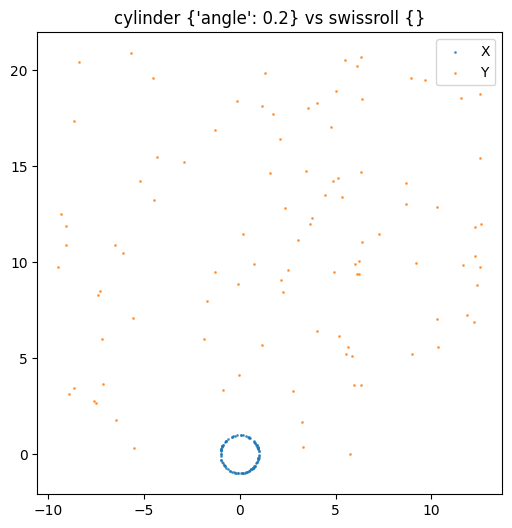

(cylinder, {'angle': 0.2}) vs (swissroll, {})
   SlicedWasserstein-PCA:   6.15 (time: 0.01s)
   Gromov-Wasserstein:      10.494101795164857 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06946, 0.015s
      k= 10, t= 1: 0.1427, 0.010s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



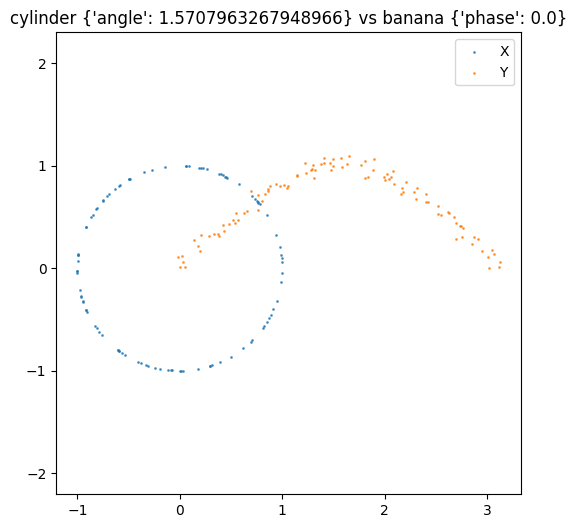

(cylinder, {'angle': 1.5707963267948966}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.3346 (time: 0.00s)
   Gromov-Wasserstein:      0.6450641517813763 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05926, 0.017s
      k= 10, t= 1: 0.2347, 0.018s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



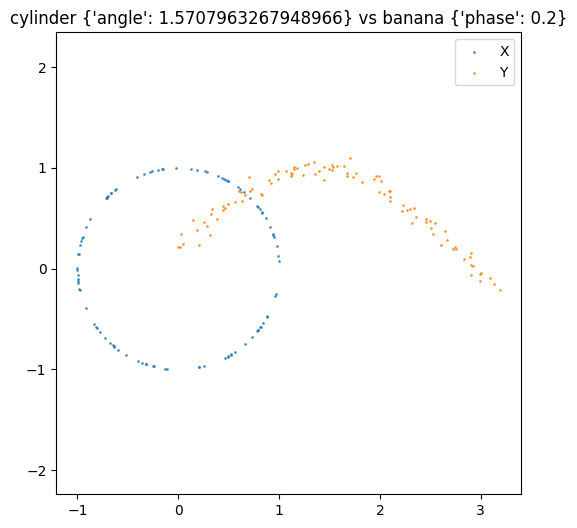

(cylinder, {'angle': 1.5707963267948966}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.3769 (time: 0.00s)
   Gromov-Wasserstein:      0.6919192685177796 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07897, 0.022s
      k= 10, t= 1: 0.2635, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



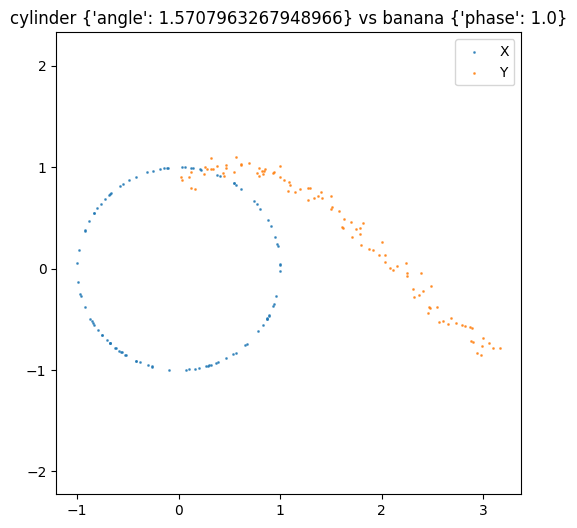

(cylinder, {'angle': 1.5707963267948966}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.5135 (time: 0.00s)
   Gromov-Wasserstein:      0.7182561885968871 (time: 0.05s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06372, 0.023s
      k= 10, t= 1: 0.2956, 0.022s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



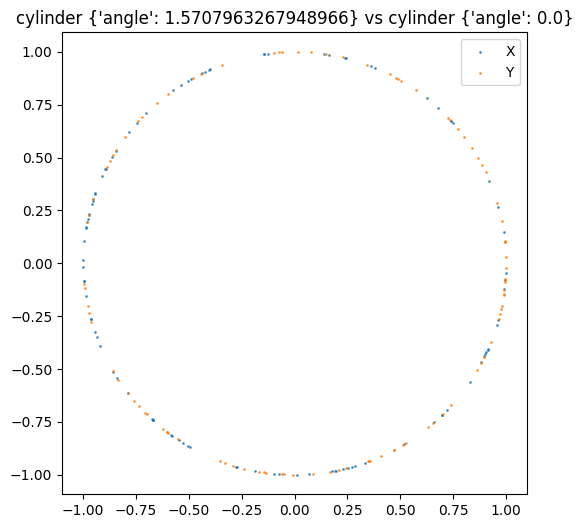

(cylinder, {'angle': 1.5707963267948966}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.08765 (time: 0.00s)
   Gromov-Wasserstein:      0.26671332928390956 (time: 0.03s)
   Standard OT:             0.6493181935861008 (time: 0.00s)
   Procrustes OT:           0.5595019856584459 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.06925, 0.023s
      k= 10, t= 1: 0.07914, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.2072, 0.002s
      n_proj=1000: 0.2032, 0.024s
      n_proj=10000: 0.2026, 0.270s



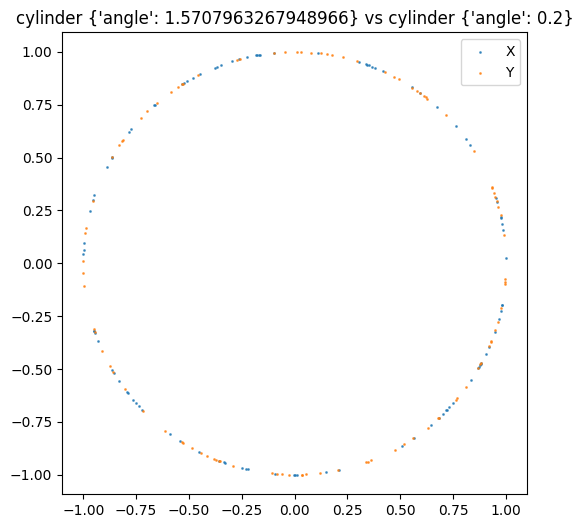

(cylinder, {'angle': 1.5707963267948966}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.0781 (time: 0.01s)
   Gromov-Wasserstein:      0.26974251809161814 (time: 0.03s)
   Standard OT:             0.5511699713003997 (time: 0.00s)
   Procrustes OT:           0.5419939236638027 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.04849, 0.021s
      k= 10, t= 1: 0.04779, 0.021s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.1046, 0.000s
      n_proj=1000: 0.1033, 0.036s
      n_proj=10000: 0.1034, 0.284s



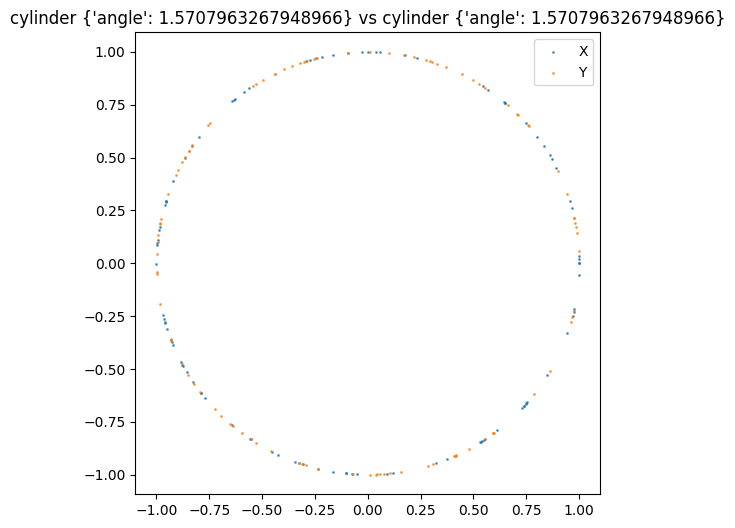

(cylinder, {'angle': 1.5707963267948966}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.08862 (time: 0.00s)
   Gromov-Wasserstein:      0.3676411806344526 (time: 0.03s)
   Standard OT:             0.5866196269775127 (time: 0.00s)
   Procrustes OT:           0.6905144819044331 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.05057, 0.027s
      k= 10, t= 1: 0.05567, 0.021s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.1234, 0.008s
      n_proj=1000: 0.1243, 0.028s
      n_proj=10000: 0.1245, 0.251s



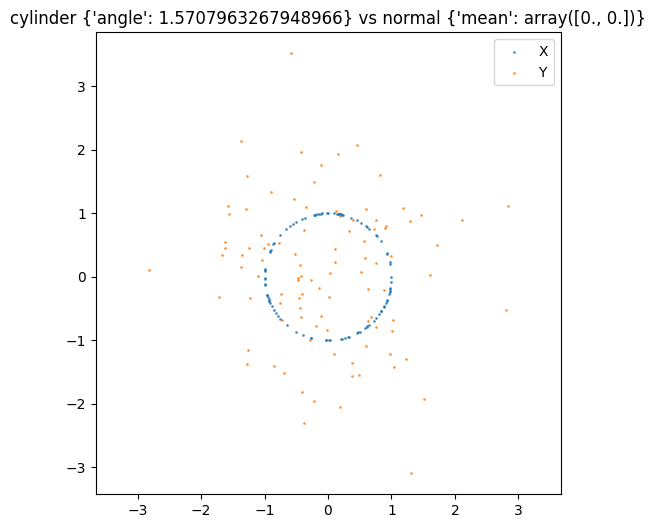

(cylinder, {'angle': 1.5707963267948966}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.5085 (time: 0.00s)
   Gromov-Wasserstein:      0.8012076457532652 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1461, 0.034s
      k= 10, t= 1: 0.1804, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



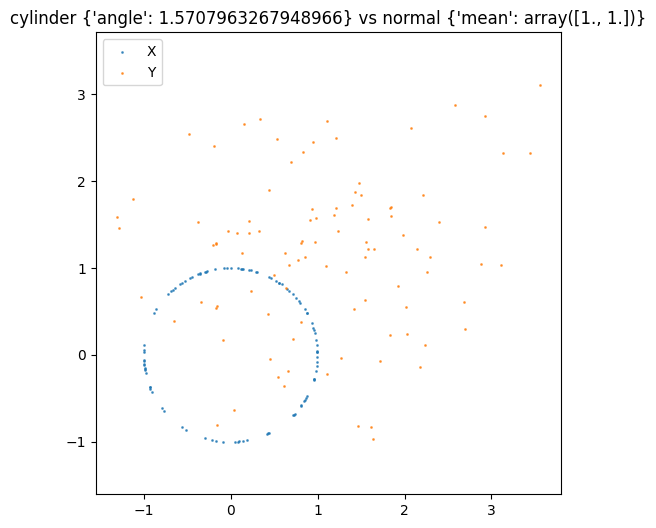

(cylinder, {'angle': 1.5707963267948966}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.4239 (time: 0.00s)
   Gromov-Wasserstein:      0.712253491450383 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.09613, 0.014s
      k= 10, t= 1: 0.1612, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



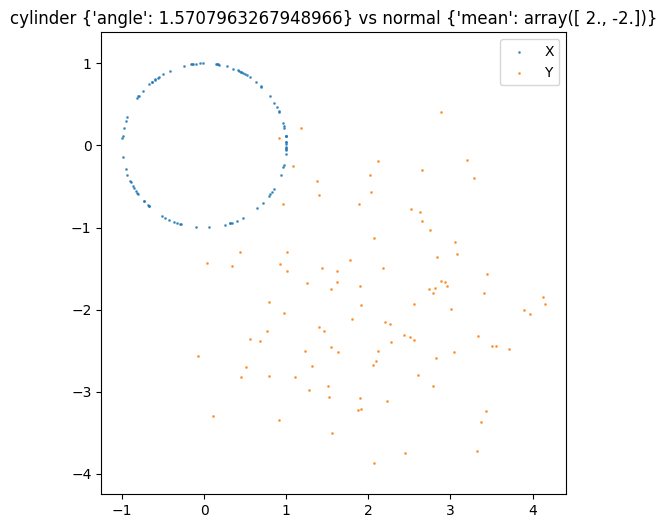

(cylinder, {'angle': 1.5707963267948966}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.3378 (time: 0.00s)
   Gromov-Wasserstein:      0.5911206707825002 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.08115, 0.016s
      k= 10, t= 1: 0.121, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



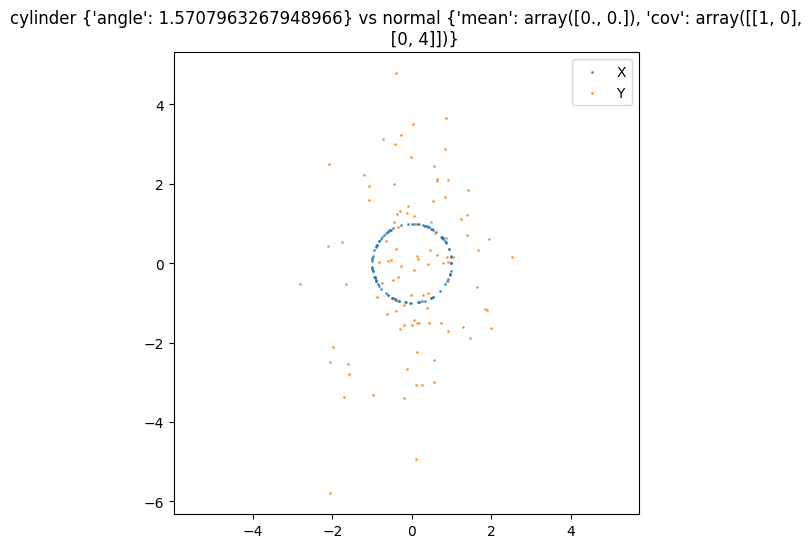

(cylinder, {'angle': 1.5707963267948966}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   1.032 (time: 0.00s)
   Gromov-Wasserstein:      1.725660388153914 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1157, 0.022s
      k= 10, t= 1: 0.2335, 0.023s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



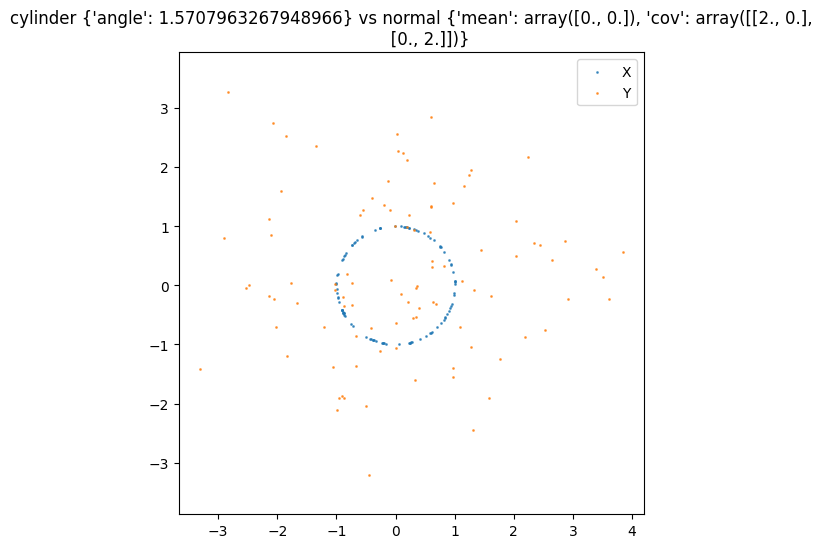

(cylinder, {'angle': 1.5707963267948966}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.9246 (time: 0.00s)
   Gromov-Wasserstein:      1.446294825130959 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1265, 0.022s
      k= 10, t= 1: 0.1748, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



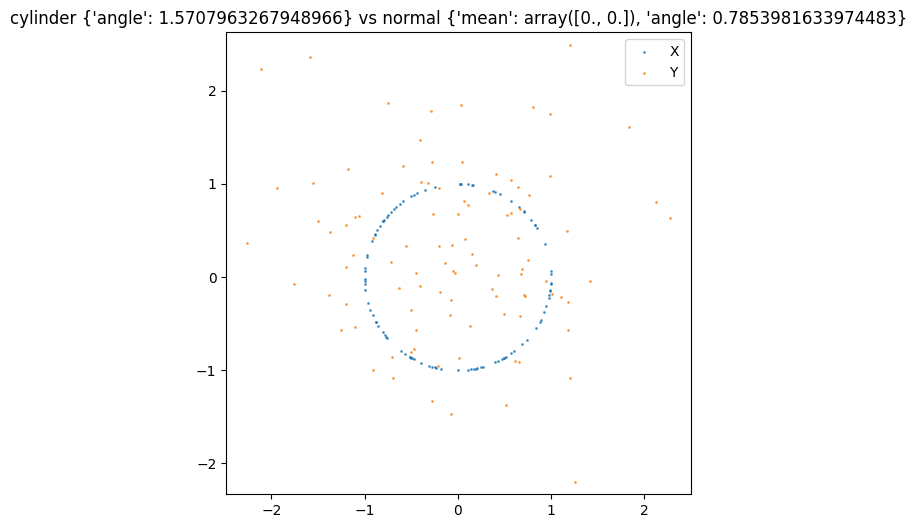

(cylinder, {'angle': 1.5707963267948966}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.3351 (time: 0.00s)
   Gromov-Wasserstein:      0.6158953547195573 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1278, 0.014s
      k= 10, t= 1: 0.19, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



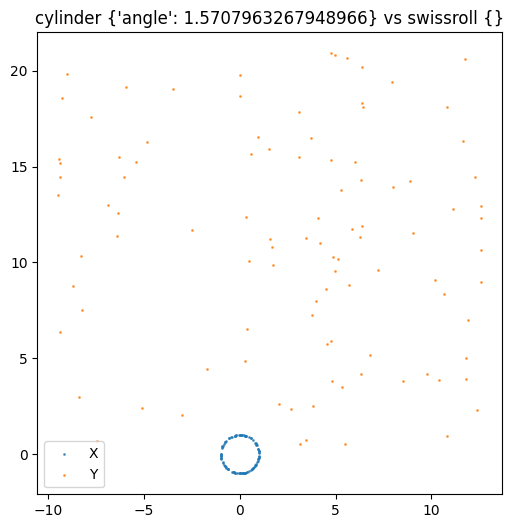

(cylinder, {'angle': 1.5707963267948966}) vs (swissroll, {})
   SlicedWasserstein-PCA:   6.382 (time: 0.00s)
   Gromov-Wasserstein:      10.892447669805598 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.07378, 0.021s
      k= 10, t= 1: 0.1855, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



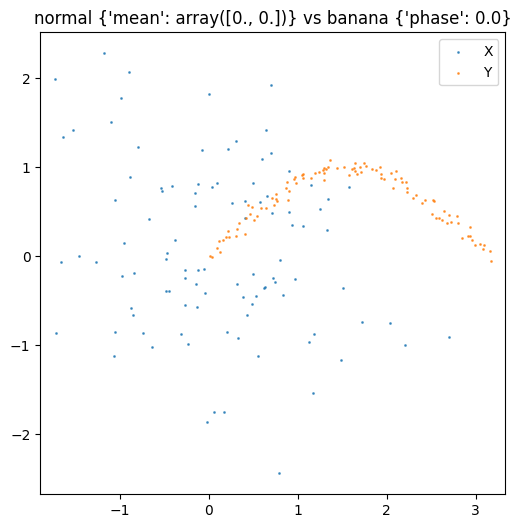

(normal, {'mean': array([0., 0.])}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.4092 (time: 0.01s)
   Gromov-Wasserstein:      0.7924567308804159 (time: 0.04s)
   Standard OT:             1.2961897740632924 (time: 0.00s)
   Procrustes OT:           0.8181081781323838 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1268, 0.016s
      k= 10, t= 1: 0.2391, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.245, 0.002s
      n_proj=1000: 1.199, 0.024s
      n_proj=10000: 1.195, 0.225s



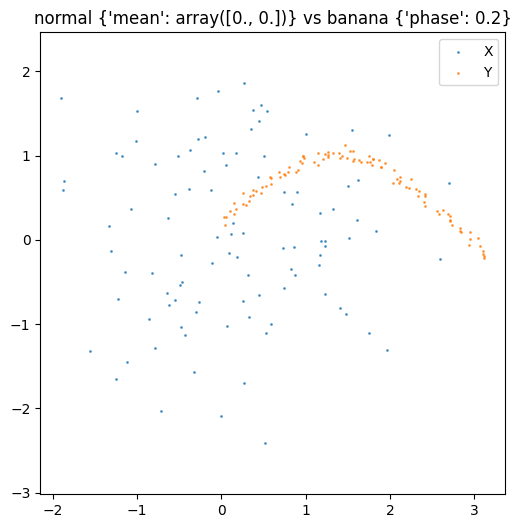

(normal, {'mean': array([0., 0.])}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.4969 (time: 0.00s)
   Gromov-Wasserstein:      0.8830033533745334 (time: 0.02s)
   Standard OT:             1.2819826402234944 (time: 0.00s)
   Procrustes OT:           0.8504792695061539 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1236, 0.013s
      k= 10, t= 1: 0.2462, 0.021s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.23, 0.003s
      n_proj=1000: 1.18, 0.015s
      n_proj=10000: 1.176, 0.211s



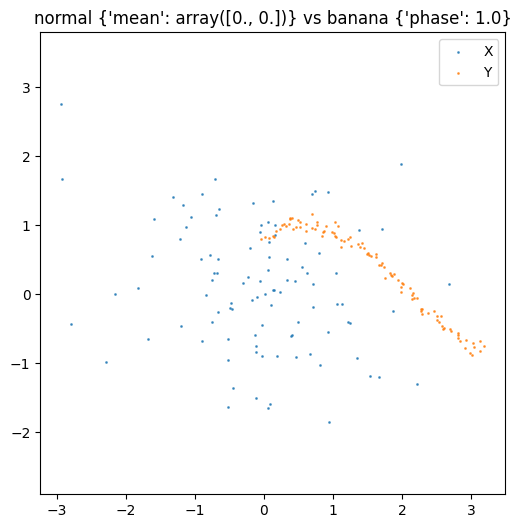

(normal, {'mean': array([0., 0.])}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.5641 (time: 0.00s)
   Gromov-Wasserstein:      0.8156075134189565 (time: 0.03s)
   Standard OT:             1.3120227001819926 (time: 0.00s)
   Procrustes OT:           0.8325737850499249 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1771, 0.016s
      k= 10, t= 1: 0.3528, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.291, 0.004s
      n_proj=1000: 1.249, 0.020s
      n_proj=10000: 1.246, 0.198s



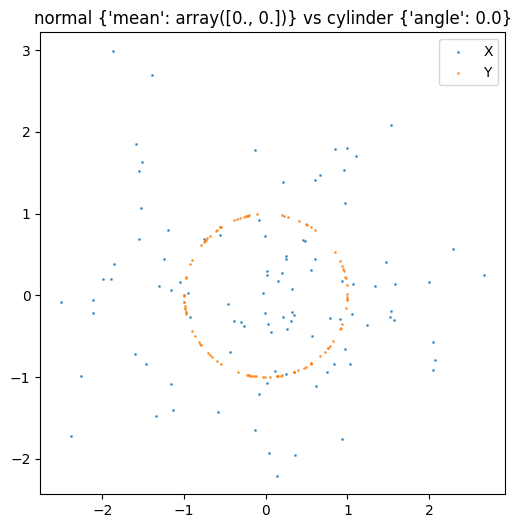

(normal, {'mean': array([0., 0.])}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.485 (time: 0.00s)
   Gromov-Wasserstein:      0.8633380771825607 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1478, 0.012s
      k= 10, t= 1: 0.1925, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



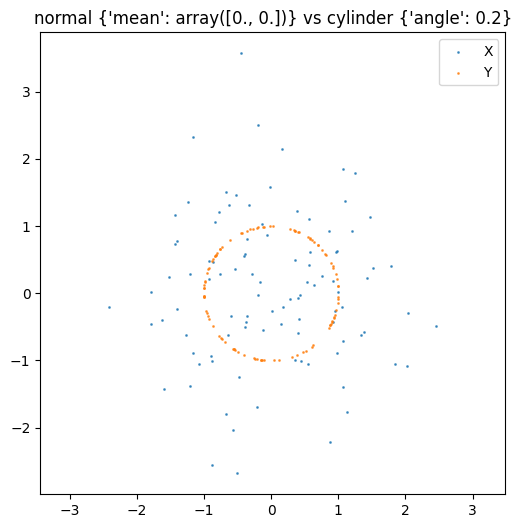

(normal, {'mean': array([0., 0.])}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.3989 (time: 0.00s)
   Gromov-Wasserstein:      0.7653195393808689 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1407, 0.012s
      k= 10, t= 1: 0.1666, 0.009s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



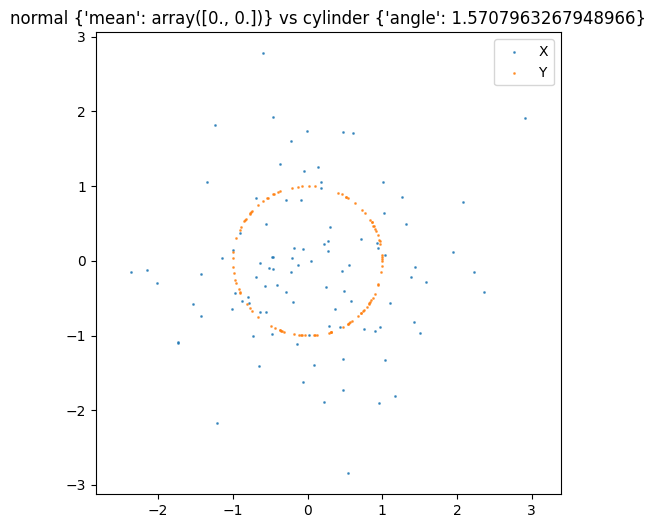

(normal, {'mean': array([0., 0.])}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.4043 (time: 0.01s)
   Gromov-Wasserstein:      0.7599427056449924 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1687, 0.012s
      k= 10, t= 1: 0.1919, 0.012s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



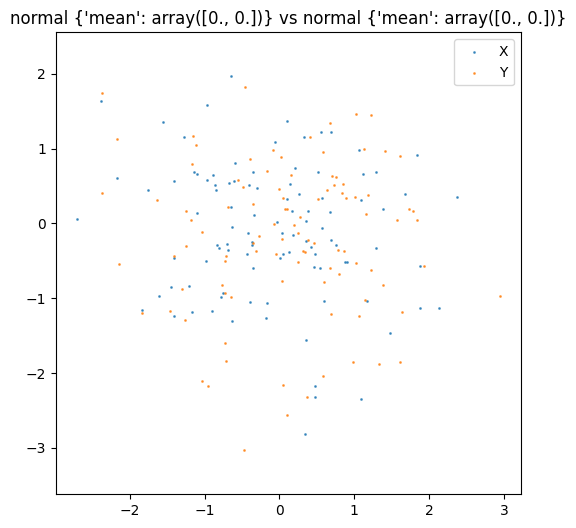

(normal, {'mean': array([0., 0.])}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.1625 (time: 0.00s)
   Gromov-Wasserstein:      0.4494117162588292 (time: 0.01s)
   Standard OT:             0.6145075474991788 (time: 0.00s)
   Procrustes OT:           0.5872872809757576 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.09117, 0.016s
      k= 10, t= 1: 0.1095, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.2251, 0.003s
      n_proj=1000: 0.2265, 0.027s
      n_proj=10000: 0.2267, 0.231s



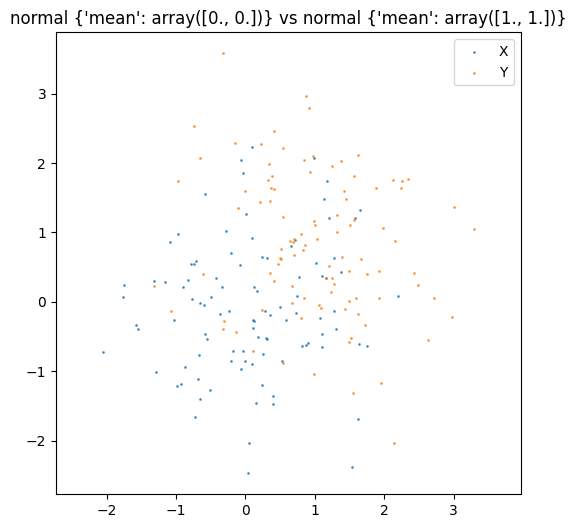

(normal, {'mean': array([0., 0.])}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.1677 (time: 0.00s)
   Gromov-Wasserstein:      0.35852836443740776 (time: 0.03s)
   Standard OT:             1.1510271602119322 (time: 0.00s)
   Procrustes OT:           0.5401794416480126 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.08422, 0.014s
      k= 10, t= 1: 0.1185, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.9972, 0.000s
      n_proj=1000: 0.9519, 0.025s
      n_proj=10000: 0.9476, 0.222s



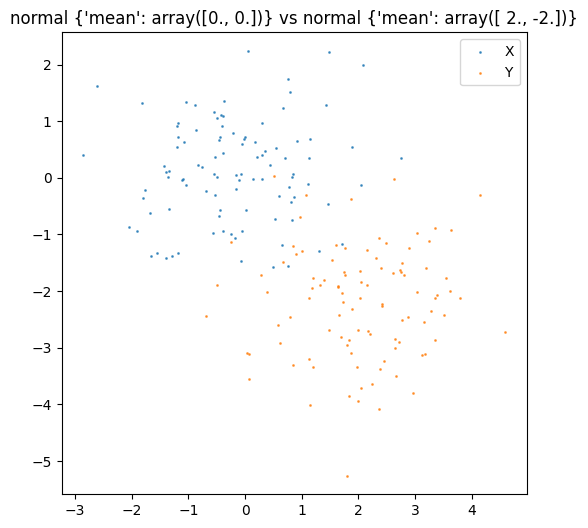

(normal, {'mean': array([0., 0.])}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.141 (time: 0.01s)
   Gromov-Wasserstein:      0.38458598021519586 (time: 0.02s)
   Standard OT:             1.7920361884103593 (time: 0.01s)
   Procrustes OT:           0.5743262736819194 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1332, 0.027s
      k= 10, t= 1: 0.08957, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 2.118, 0.000s
      n_proj=1000: 2.244, 0.017s
      n_proj=10000: 2.255, 0.246s



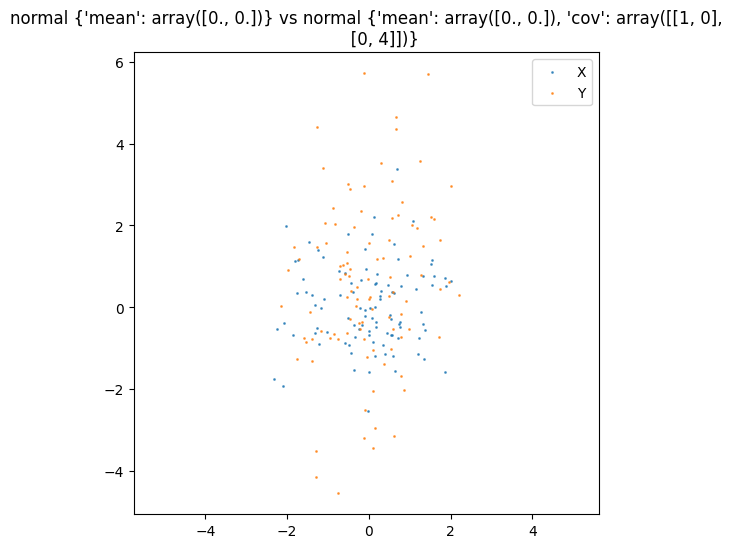

(normal, {'mean': array([0., 0.])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   0.6922 (time: 0.00s)
   Gromov-Wasserstein:      1.256548457311655 (time: 0.02s)
   Standard OT:             0.9753307758945152 (time: 0.00s)
   Procrustes OT:           0.9084068250794054 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1225, 0.019s
      k= 10, t= 1: 0.2035, 0.014s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.7346, 0.010s
      n_proj=1000: 0.7446, 0.025s
      n_proj=10000: 0.7446, 0.239s



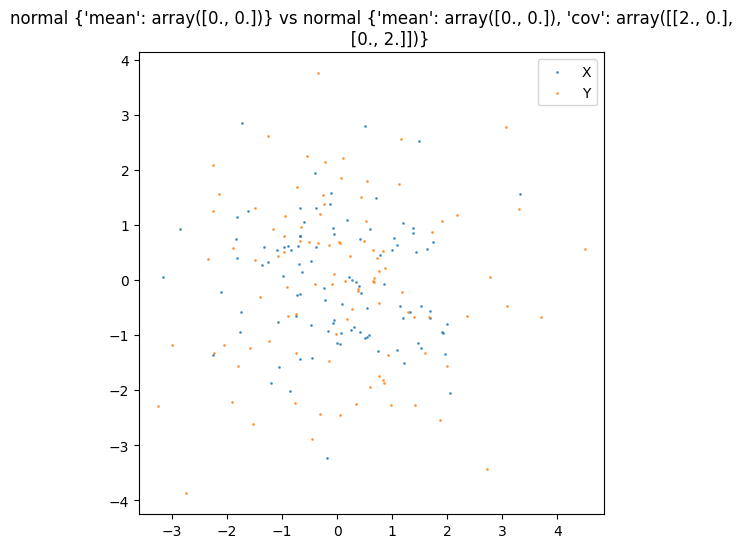

(normal, {'mean': array([0., 0.])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.4017 (time: 0.00s)
   Gromov-Wasserstein:      0.8743502365212523 (time: 0.03s)
   Standard OT:             0.7819532859019104 (time: 0.00s)
   Procrustes OT:           0.7919798520842857 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1719, 0.017s
      k= 10, t= 1: 0.1193, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.4262, 0.002s
      n_proj=1000: 0.4208, 0.015s
      n_proj=10000: 0.4204, 0.266s



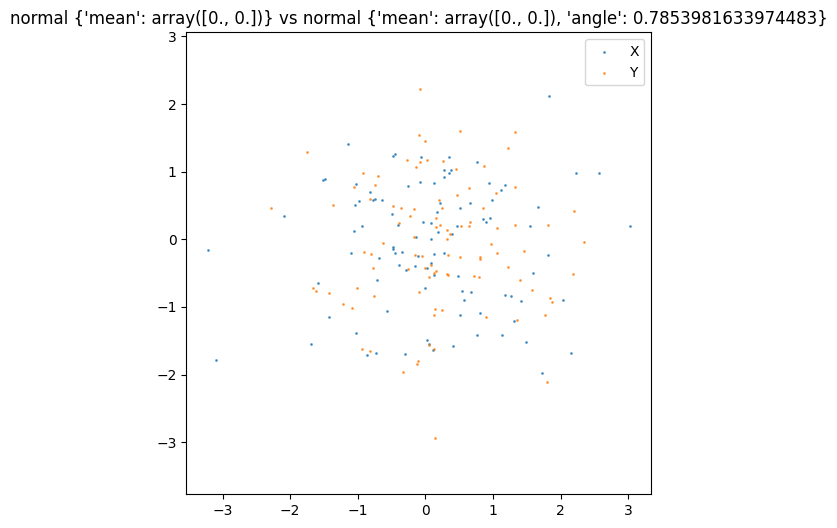

(normal, {'mean': array([0., 0.])}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.1623 (time: 0.00s)
   Gromov-Wasserstein:      0.4381233720362179 (time: 0.02s)
   Standard OT:             0.5900295781451002 (time: 0.00s)
   Procrustes OT:           0.5824591215561231 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.135, 0.025s
      k= 10, t= 1: 0.149, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.1989, 0.000s
      n_proj=1000: 0.1928, 0.029s
      n_proj=10000: 0.192, 0.242s



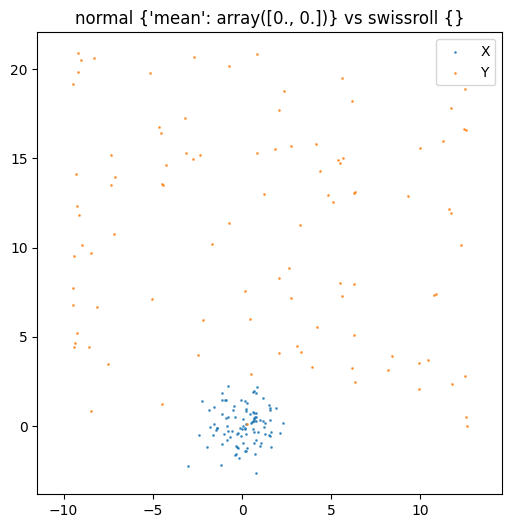

(normal, {'mean': array([0., 0.])}) vs (swissroll, {})
   SlicedWasserstein-PCA:   5.607 (time: 0.00s)
   Gromov-Wasserstein:      11.225143532492078 (time: 0.02s)
   Standard OT:             3.5607978178976367 (time: 0.01s)
   Procrustes OT:           2.728445247859134 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1594, 0.015s
      k= 10, t= 1: 0.1811, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 9.392, 0.003s
      n_proj=1000: 9.488, 0.027s
      n_proj=10000: 9.492, 0.199s



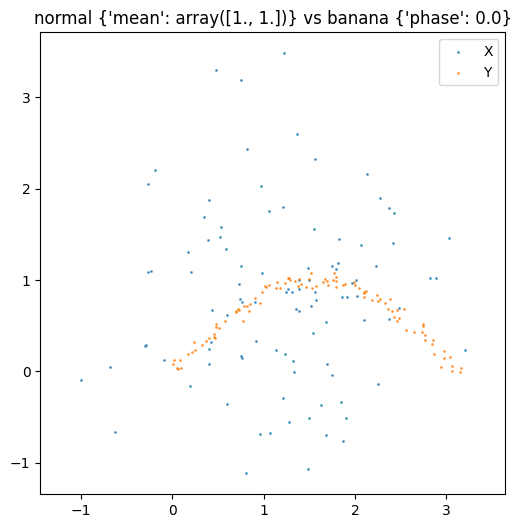

(normal, {'mean': array([1., 1.])}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.4056 (time: 0.01s)
   Gromov-Wasserstein:      0.6978508087242326 (time: 0.04s)
   Standard OT:             0.8585527724973888 (time: 0.00s)
   Procrustes OT:           0.8085543190925738 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1266, 0.017s
      k= 10, t= 1: 0.2359, 0.012s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.4928, 0.004s
      n_proj=1000: 0.5056, 0.017s
      n_proj=10000: 0.5065, 0.235s



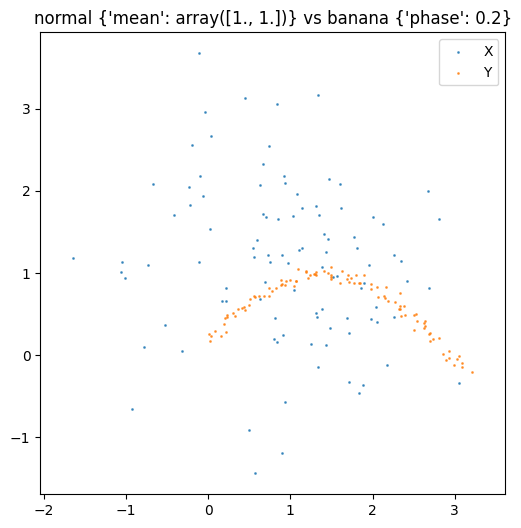

(normal, {'mean': array([1., 1.])}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.4369 (time: 0.00s)
   Gromov-Wasserstein:      0.8274721464727289 (time: 0.04s)
   Standard OT:             1.006322477382875 (time: 0.00s)
   Procrustes OT:           0.8214205862427947 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1309, 0.015s
      k= 10, t= 1: 0.238, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.6834, 0.000s
      n_proj=1000: 0.7109, 0.035s
      n_proj=10000: 0.7132, 0.223s



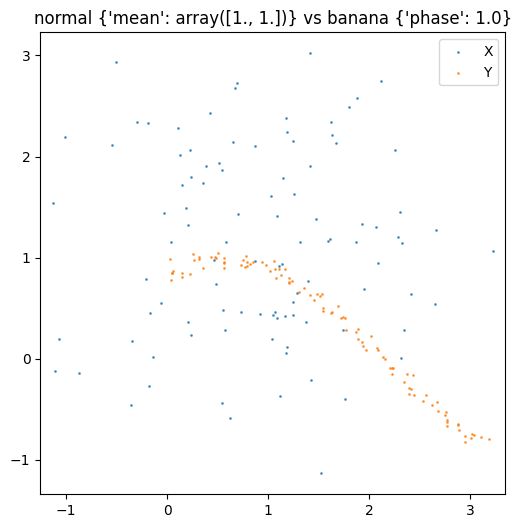

(normal, {'mean': array([1., 1.])}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.5775 (time: 0.00s)
   Gromov-Wasserstein:      0.7366761172762668 (time: 0.04s)
   Standard OT:             1.122540763929467 (time: 0.00s)
   Procrustes OT:           0.8837476505555532 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1143, 0.023s
      k= 10, t= 1: 0.2465, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.8088, 0.007s
      n_proj=1000: 0.8378, 0.023s
      n_proj=10000: 0.8408, 0.242s



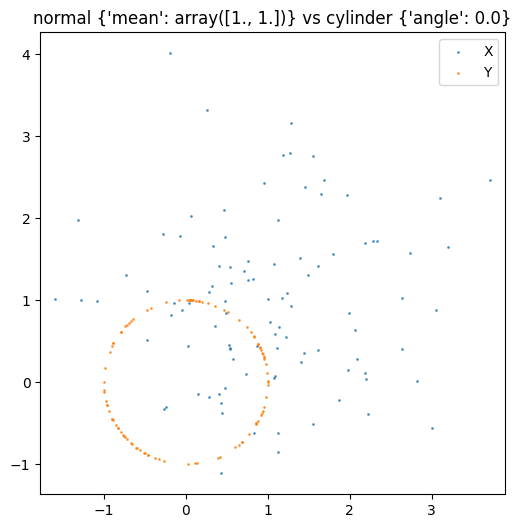

(normal, {'mean': array([1., 1.])}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.4019 (time: 0.00s)
   Gromov-Wasserstein:      0.7671459885999522 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.136, 0.017s
      k= 10, t= 1: 0.185, 0.014s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



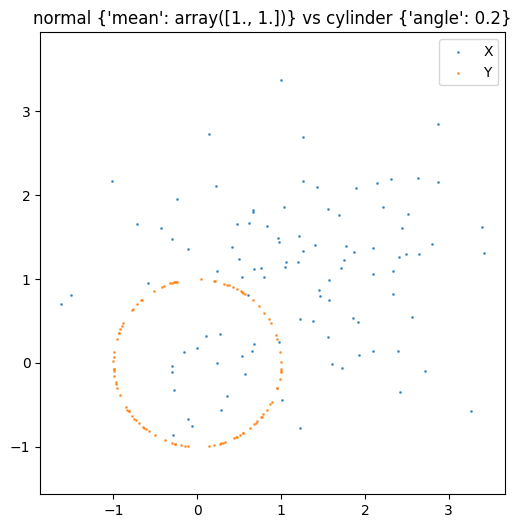

(normal, {'mean': array([1., 1.])}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.3813 (time: 0.00s)
   Gromov-Wasserstein:      0.7059803110716135 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.137, 0.013s
      k= 10, t= 1: 0.1506, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



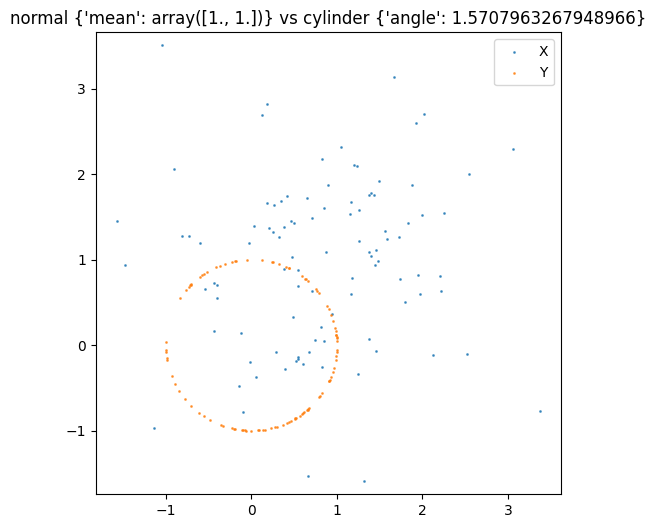

(normal, {'mean': array([1., 1.])}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.3748 (time: 0.01s)
   Gromov-Wasserstein:      0.7030640906460804 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.189, 0.016s
      k= 10, t= 1: 0.1854, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



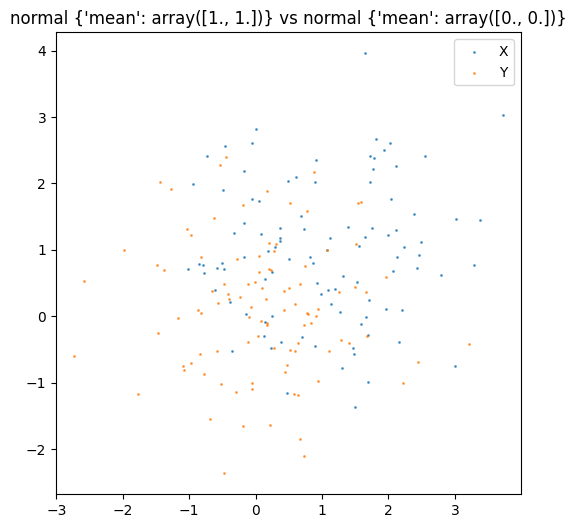

(normal, {'mean': array([1., 1.])}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.1799 (time: 0.01s)
   Gromov-Wasserstein:      0.4574637385814363 (time: 0.02s)
   Standard OT:             1.1168564692125005 (time: 0.00s)
   Procrustes OT:           0.6173915501980461 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1261, 0.032s
      k= 10, t= 1: 0.1332, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.948, 0.004s
      n_proj=1000: 0.9024, 0.025s
      n_proj=10000: 0.8981, 0.275s



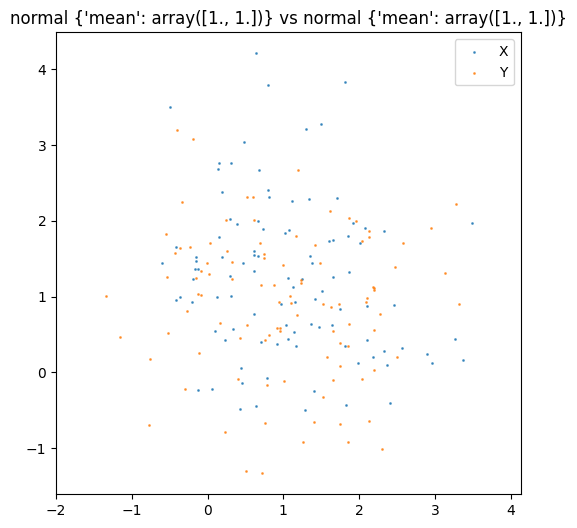

(normal, {'mean': array([1., 1.])}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.1611 (time: 0.00s)
   Gromov-Wasserstein:      0.387216322170316 (time: 0.01s)
   Standard OT:             0.6934116120507667 (time: 0.00s)
   Procrustes OT:           0.5642389753856683 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1215, 0.027s
      k= 10, t= 1: 0.1005, 0.025s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.3114, 0.003s
      n_proj=1000: 0.3135, 0.025s
      n_proj=10000: 0.3134, 0.238s



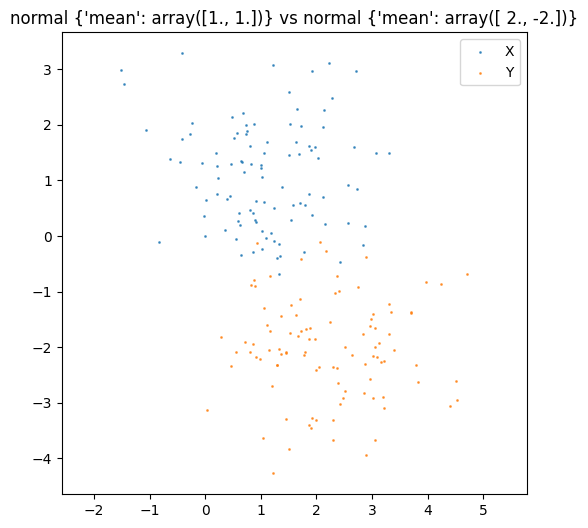

(normal, {'mean': array([1., 1.])}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.185 (time: 0.00s)
   Gromov-Wasserstein:      0.37604560866818965 (time: 0.03s)
   Standard OT:             1.826485545131058 (time: 0.00s)
   Procrustes OT:           0.5983766414458576 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.09714, 0.011s
      k= 10, t= 1: 0.1059, 0.028s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 2.228, 0.002s
      n_proj=1000: 2.352, 0.031s
      n_proj=10000: 2.361, 0.256s



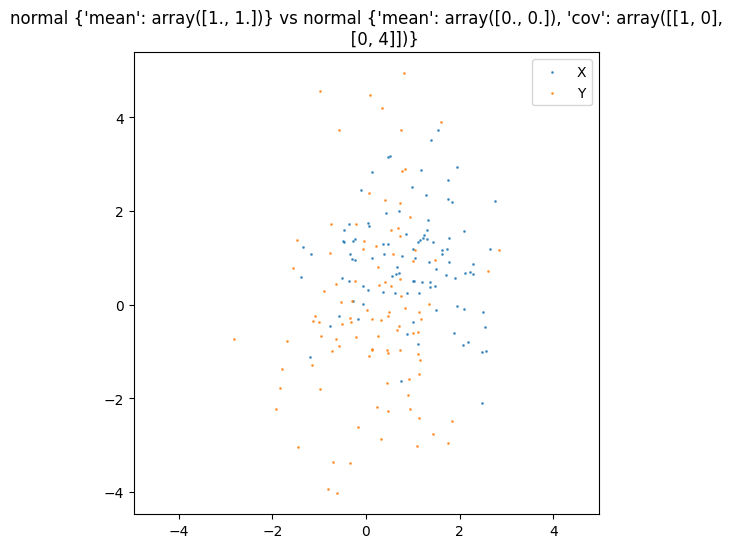

(normal, {'mean': array([1., 1.])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   0.6048 (time: 0.00s)
   Gromov-Wasserstein:      1.093660083326767 (time: 0.03s)
   Standard OT:             1.1961822674569382 (time: 0.00s)
   Procrustes OT:           0.8900019818401248 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1079, 0.016s
      k= 10, t= 1: 0.2049, 0.024s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.103, 0.006s
      n_proj=1000: 1.072, 0.027s
      n_proj=10000: 1.069, 0.250s



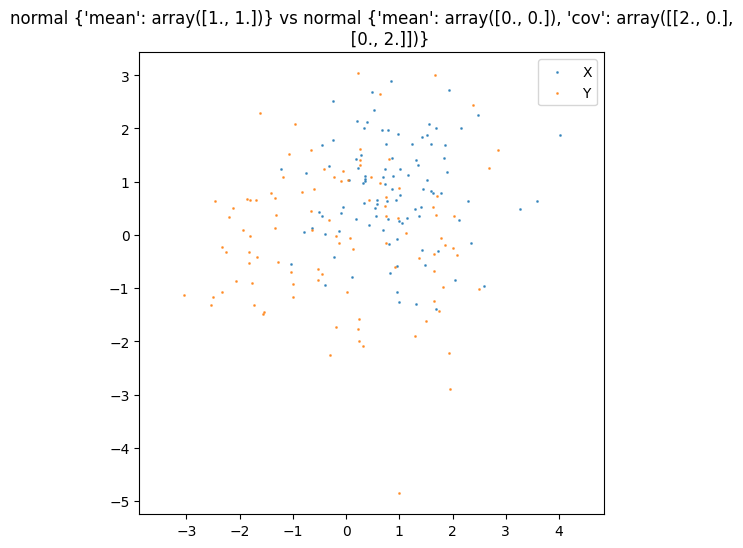

(normal, {'mean': array([1., 1.])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.4675 (time: 0.01s)
   Gromov-Wasserstein:      0.977166360410211 (time: 0.02s)
   Standard OT:             1.1817658539665588 (time: 0.01s)
   Procrustes OT:           0.8168542466939095 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.11, 0.022s
      k= 10, t= 1: 0.1193, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.085, 0.000s
      n_proj=1000: 1.039, 0.024s
      n_proj=10000: 1.035, 0.226s



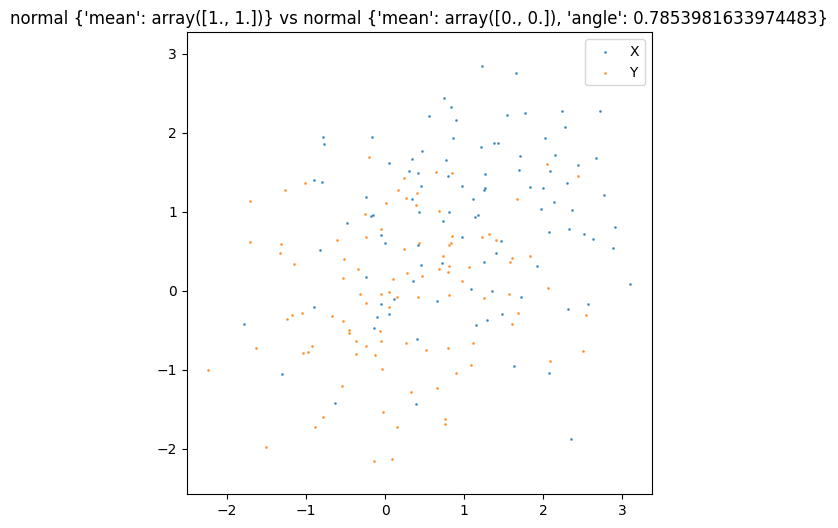

(normal, {'mean': array([1., 1.])}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.1731 (time: 0.00s)
   Gromov-Wasserstein:      0.408185641081578 (time: 0.02s)
   Standard OT:             1.1187065280638104 (time: 0.00s)
   Procrustes OT:           0.5969508297218058 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1124, 0.023s
      k= 10, t= 1: 0.1307, 0.018s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.941, 0.000s
      n_proj=1000: 0.9002, 0.026s
      n_proj=10000: 0.8961, 0.215s



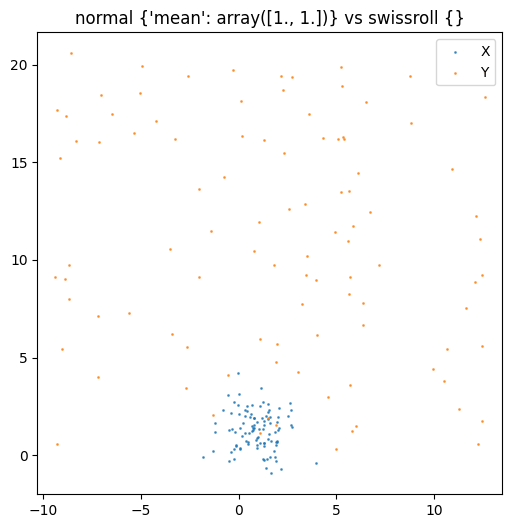

(normal, {'mean': array([1., 1.])}) vs (swissroll, {})
   SlicedWasserstein-PCA:   5.191 (time: 0.00s)
   Gromov-Wasserstein:      10.41362623763547 (time: 0.03s)
   Standard OT:             3.367593586715875 (time: 0.00s)
   Procrustes OT:           2.6090249233115177 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1548, 0.016s
      k= 10, t= 1: 0.1746, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 8.583, 0.000s
      n_proj=1000: 8.661, 0.024s
      n_proj=10000: 8.664, 0.199s



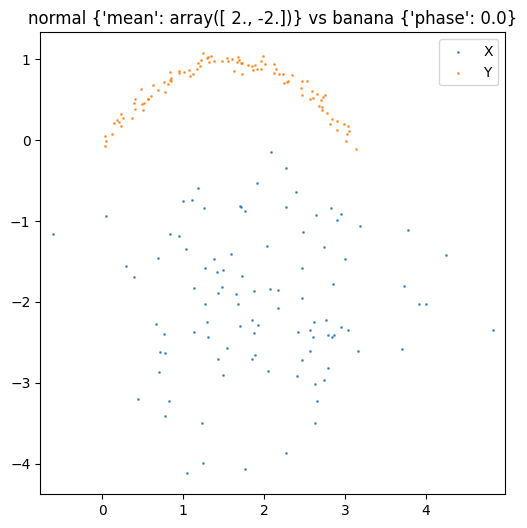

(normal, {'mean': array([ 2., -2.])}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.4374 (time: 0.00s)
   Gromov-Wasserstein:      0.7582225397118127 (time: 0.03s)
   Standard OT:             1.6365808040877001 (time: 0.00s)
   Procrustes OT:           0.8276654091267492 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1155, 0.026s
      k= 10, t= 1: 0.2343, 0.026s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.856, 0.005s
      n_proj=1000: 1.927, 0.025s
      n_proj=10000: 1.931, 0.217s



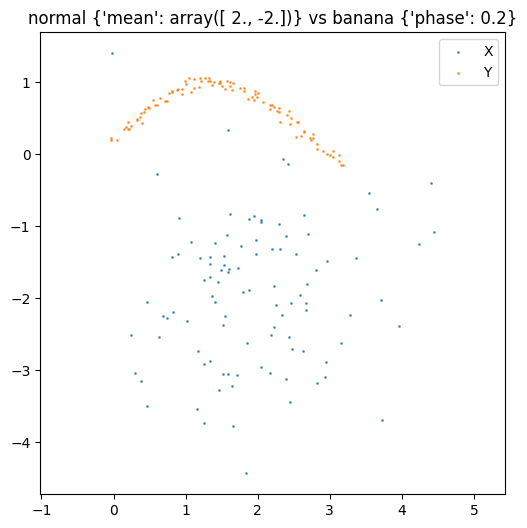

(normal, {'mean': array([ 2., -2.])}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.478 (time: 0.00s)
   Gromov-Wasserstein:      0.8054393445187367 (time: 0.03s)
   Standard OT:             1.620678156151631 (time: 0.00s)
   Procrustes OT:           0.8016068532913281 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1652, 0.021s
      k= 10, t= 1: 0.3225, 0.026s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.826, 0.000s
      n_proj=1000: 1.893, 0.035s
      n_proj=10000: 1.897, 0.238s



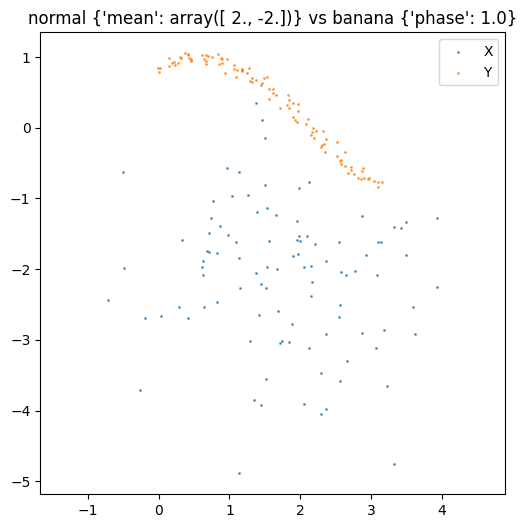

(normal, {'mean': array([ 2., -2.])}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.5684 (time: 0.00s)
   Gromov-Wasserstein:      0.8051730520721875 (time: 0.05s)
   Standard OT:             1.5754040157726843 (time: 0.00s)
   Procrustes OT:           0.9294813508091931 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1454, 0.031s
      k= 10, t= 1: 0.2579, 0.014s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.754, 0.007s
      n_proj=1000: 1.803, 0.017s
      n_proj=10000: 1.806, 0.228s



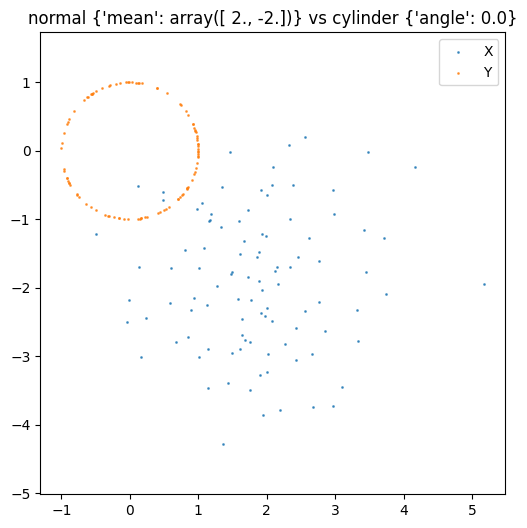

(normal, {'mean': array([ 2., -2.])}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.3958 (time: 0.00s)
   Gromov-Wasserstein:      0.7322802731175605 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1497, 0.015s
      k= 10, t= 1: 0.1854, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



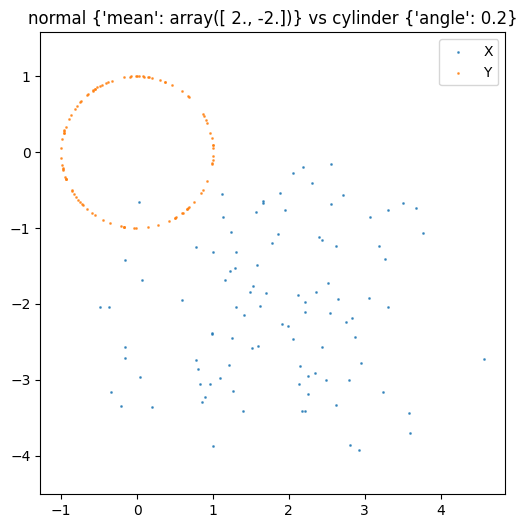

(normal, {'mean': array([ 2., -2.])}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.3865 (time: 0.00s)
   Gromov-Wasserstein:      0.71777445457362 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1201, 0.016s
      k= 10, t= 1: 0.1489, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



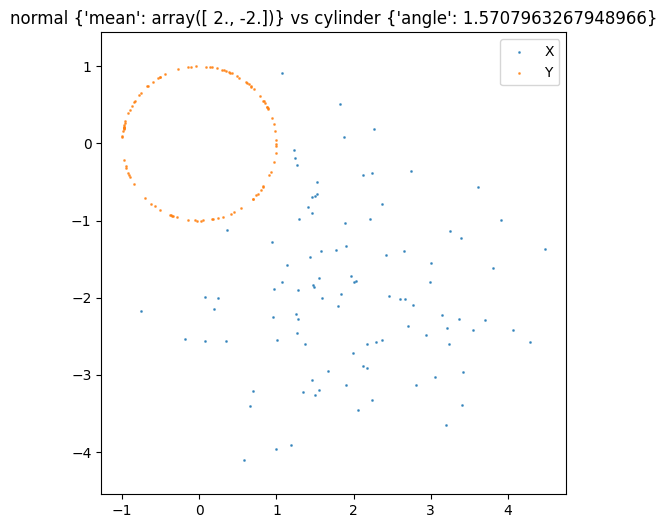

(normal, {'mean': array([ 2., -2.])}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.3601 (time: 0.00s)
   Gromov-Wasserstein:      0.7623371290687451 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1219, 0.015s
      k= 10, t= 1: 0.1462, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



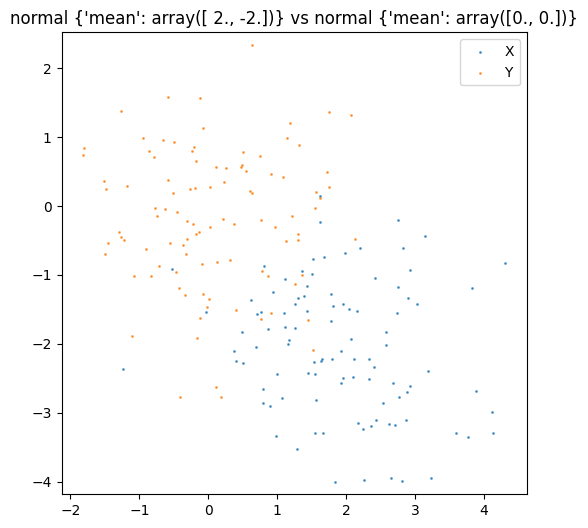

(normal, {'mean': array([ 2., -2.])}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.1797 (time: 0.00s)
   Gromov-Wasserstein:      0.3574184475552081 (time: 0.03s)
   Standard OT:             1.6209003860051678 (time: 0.00s)
   Procrustes OT:           0.5932424647276092 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1064, 0.008s
      k= 10, t= 1: 0.1084, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.734, 0.004s
      n_proj=1000: 1.836, 0.026s
      n_proj=10000: 1.845, 0.251s



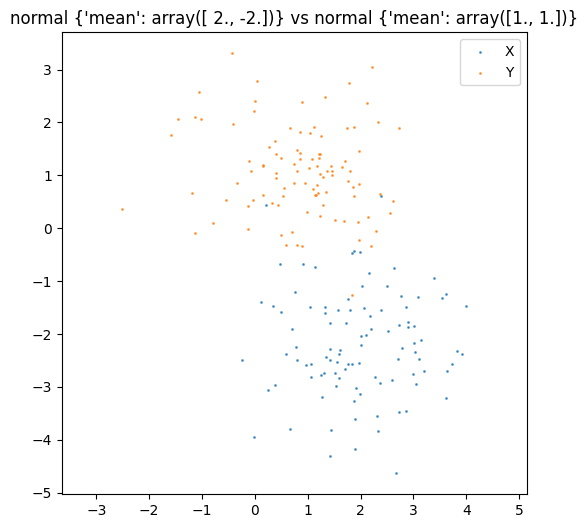

(normal, {'mean': array([ 2., -2.])}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.1832 (time: 0.00s)
   Gromov-Wasserstein:      0.40513127058981 (time: 0.03s)
   Standard OT:             1.8568026211959898 (time: 0.00s)
   Procrustes OT:           0.5793931563162423 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.112, 0.021s
      k= 10, t= 1: 0.2069, 0.018s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 2.305, 0.005s
      n_proj=1000: 2.43, 0.022s
      n_proj=10000: 2.439, 0.245s



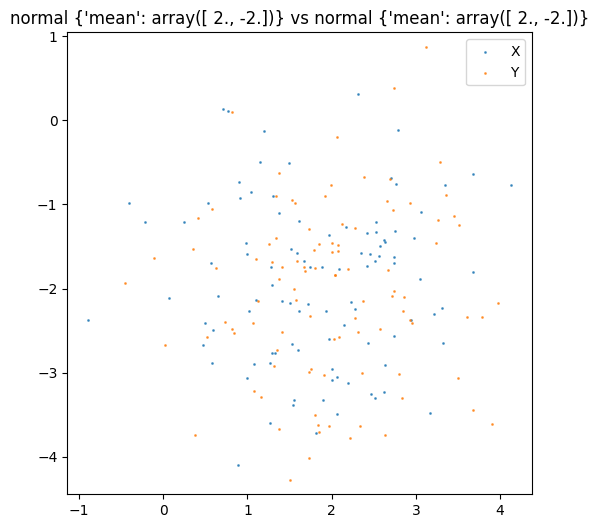

(normal, {'mean': array([ 2., -2.])}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.1515 (time: 0.02s)
   Gromov-Wasserstein:      0.3697685776994499 (time: 0.03s)
   Standard OT:             0.5852087823925867 (time: 0.00s)
   Procrustes OT:           0.567882128080106 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1115, 0.015s
      k= 10, t= 1: 0.09229, 0.021s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.1832, 0.002s
      n_proj=1000: 0.1904, 0.024s
      n_proj=10000: 0.1911, 0.223s



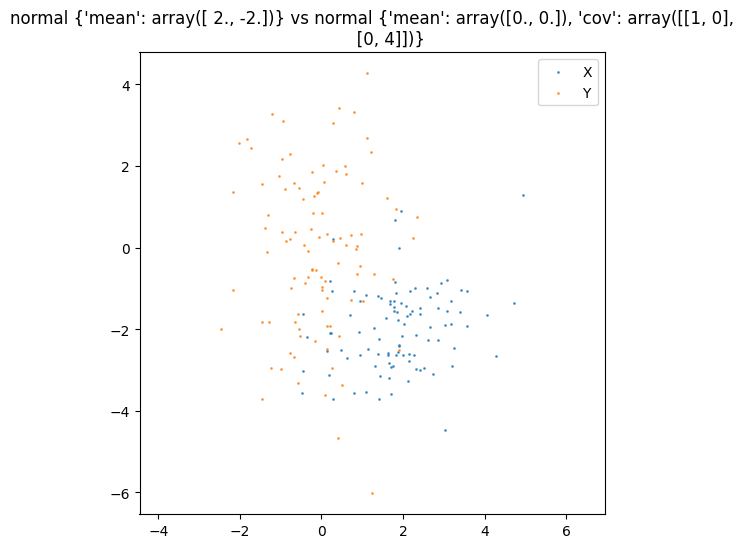

(normal, {'mean': array([ 2., -2.])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   0.6079 (time: 0.00s)
   Gromov-Wasserstein:      1.125409255922041 (time: 0.04s)
   Standard OT:             1.6799796222585361 (time: 0.00s)
   Procrustes OT:           0.8718370664513516 (time: 0.03s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1934, 0.023s
      k= 10, t= 1: 0.2953, 0.022s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.915, 0.003s
      n_proj=1000: 2.019, 0.026s
      n_proj=10000: 2.028, 0.260s



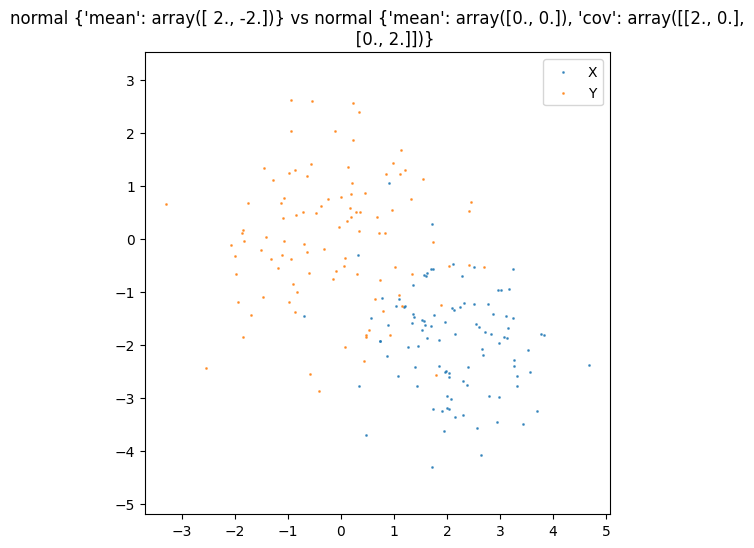

(normal, {'mean': array([ 2., -2.])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.3177 (time: 0.00s)
   Gromov-Wasserstein:      0.6668871648664706 (time: 0.02s)
   Standard OT:             1.7280562785836107 (time: 0.00s)
   Procrustes OT:           0.6935367137498282 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1163, 0.027s
      k= 10, t= 1: 0.1322, 0.018s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.987, 0.003s
      n_proj=1000: 2.09, 0.023s
      n_proj=10000: 2.1, 0.244s



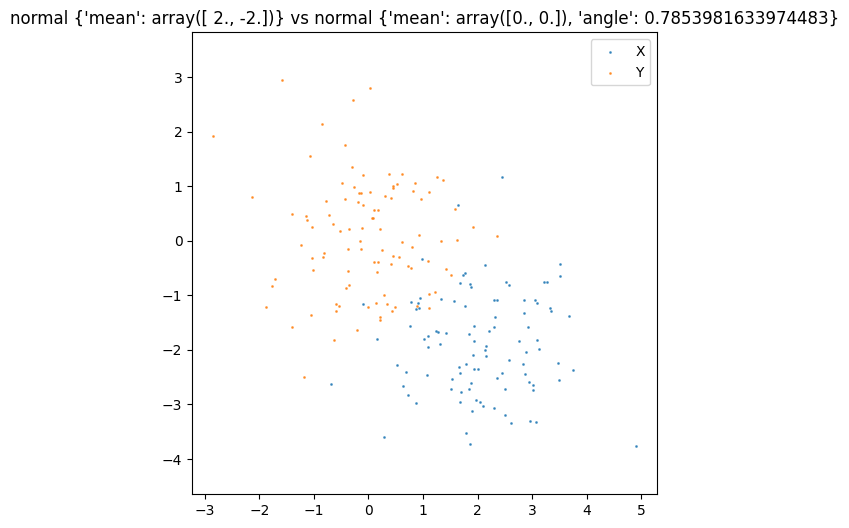

(normal, {'mean': array([ 2., -2.])}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.1531 (time: 0.00s)
   Gromov-Wasserstein:      0.42225090596494097 (time: 0.02s)
   Standard OT:             1.6898658118371654 (time: 0.00s)
   Procrustes OT:           0.5523151674765999 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1432, 0.016s
      k= 10, t= 1: 0.1761, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.889, 0.004s
      n_proj=1000: 1.997, 0.026s
      n_proj=10000: 2.007, 0.237s



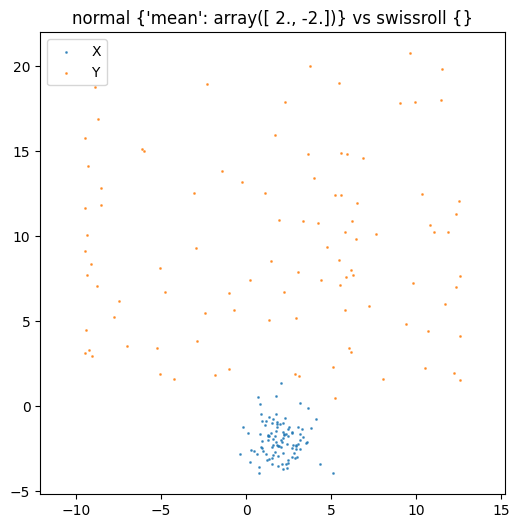

(normal, {'mean': array([ 2., -2.])}) vs (swissroll, {})
   SlicedWasserstein-PCA:   5.26 (time: 0.01s)
   Gromov-Wasserstein:      10.494910712152242 (time: 0.03s)
   Standard OT:             3.5808390470623244 (time: 0.00s)
   Procrustes OT:           2.6160174927809807 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1615, 0.021s
      k= 10, t= 1: 0.2196, 0.025s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 9.391, 0.004s
      n_proj=1000: 9.505, 0.021s
      n_proj=10000: 9.51, 0.233s



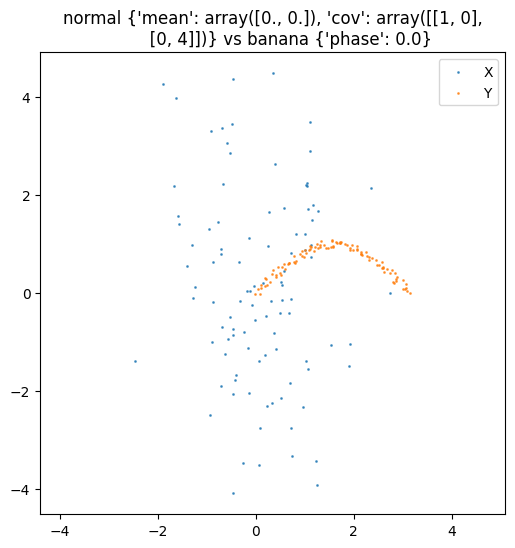

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.8855 (time: 0.00s)
   Gromov-Wasserstein:      1.7714535515657357 (time: 0.02s)
   Standard OT:             1.4642285719852632 (time: 0.00s)
   Procrustes OT:           1.0728900877115888 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.202, 0.021s
      k= 10, t= 1: 0.2733, 0.004s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.576, 0.012s
      n_proj=1000: 1.557, 0.025s
      n_proj=10000: 1.555, 0.230s



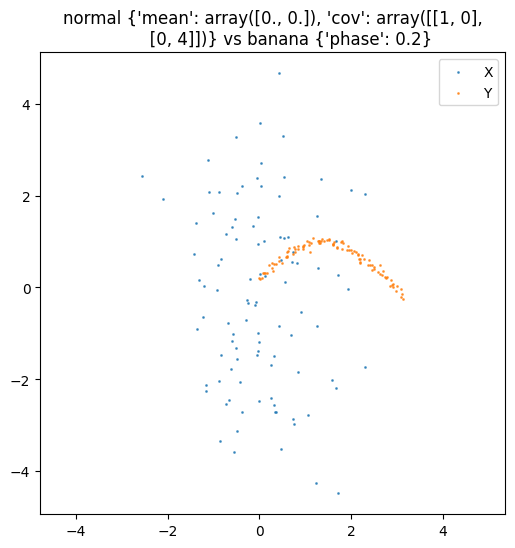

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.8722 (time: 0.01s)
   Gromov-Wasserstein:      1.7413532910826668 (time: 0.02s)
   Standard OT:             1.4983346013033418 (time: 0.00s)
   Procrustes OT:           1.0792717835560646 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1967, 0.017s
      k= 10, t= 1: 0.2587, 0.029s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.676, 0.002s
      n_proj=1000: 1.637, 0.017s
      n_proj=10000: 1.633, 0.232s



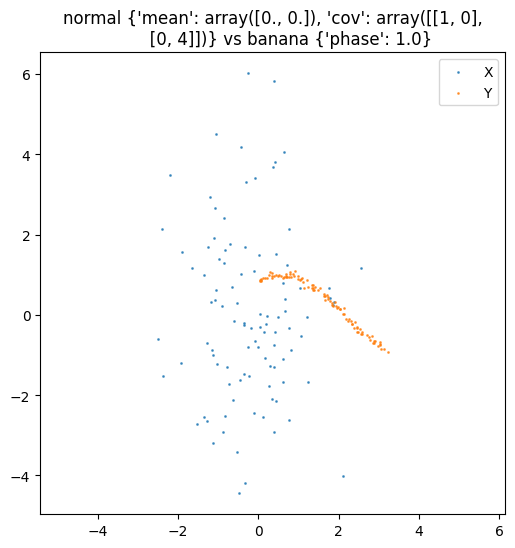

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.9728 (time: 0.01s)
   Gromov-Wasserstein:      1.85324064001559 (time: 0.02s)
   Standard OT:             1.5226157519658237 (time: 0.00s)
   Procrustes OT:           1.0775925399197743 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2178, 0.019s
      k= 10, t= 1: 0.4589, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.749, 0.003s
      n_proj=1000: 1.708, 0.021s
      n_proj=10000: 1.705, 0.217s



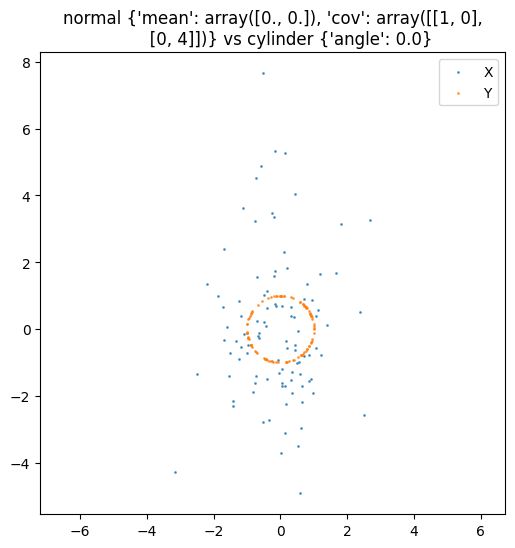

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   1.128 (time: 0.00s)
   Gromov-Wasserstein:      2.0417656858368733 (time: 0.01s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.3706, 0.024s
      k= 10, t= 1: 0.4938, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



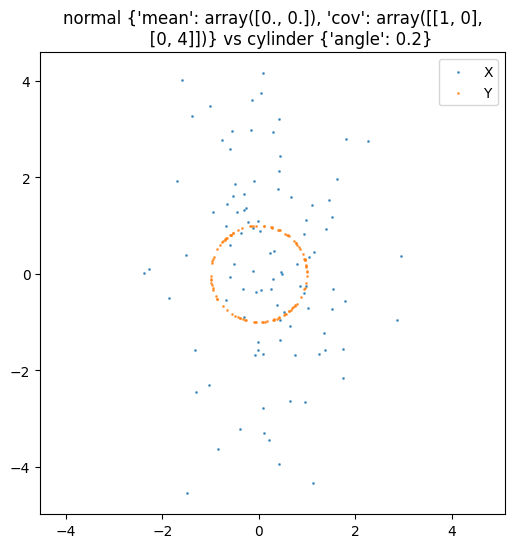

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.9461 (time: 0.01s)
   Gromov-Wasserstein:      1.7189671342024324 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2433, 0.017s
      k= 10, t= 1: 0.2797, 0.027s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



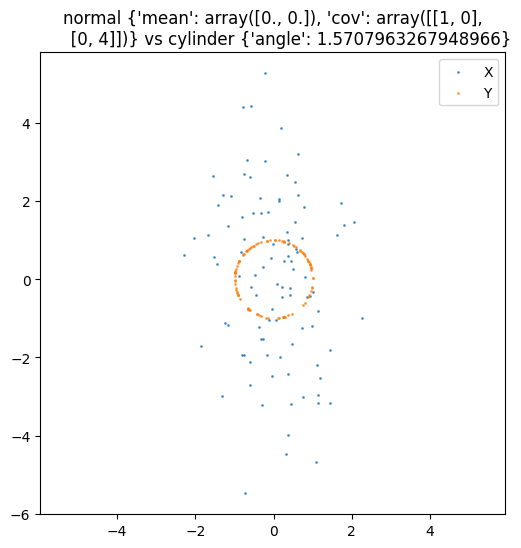

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   1.042 (time: 0.00s)
   Gromov-Wasserstein:      1.8676017023163312 (time: 0.05s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2055, 0.015s
      k= 10, t= 1: 0.2989, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



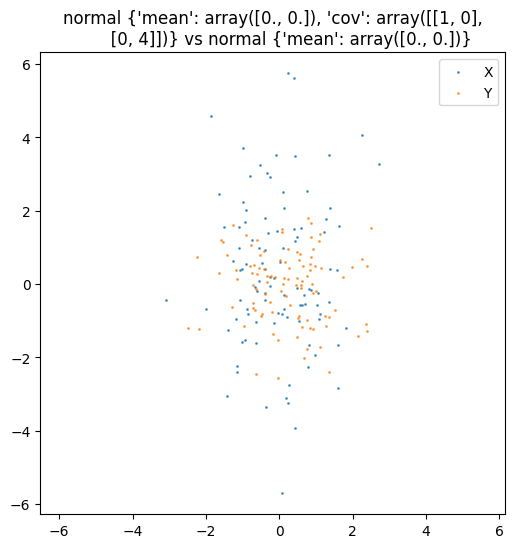

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.7141 (time: 0.00s)
   Gromov-Wasserstein:      1.3911984401834228 (time: 0.03s)
   Standard OT:             0.9666695402341348 (time: 0.00s)
   Procrustes OT:           0.9404699412744543 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1818, 0.016s
      k= 10, t= 1: 0.3197, 0.020s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.7564, 0.004s
      n_proj=1000: 0.7731, 0.025s
      n_proj=10000: 0.7737, 0.229s



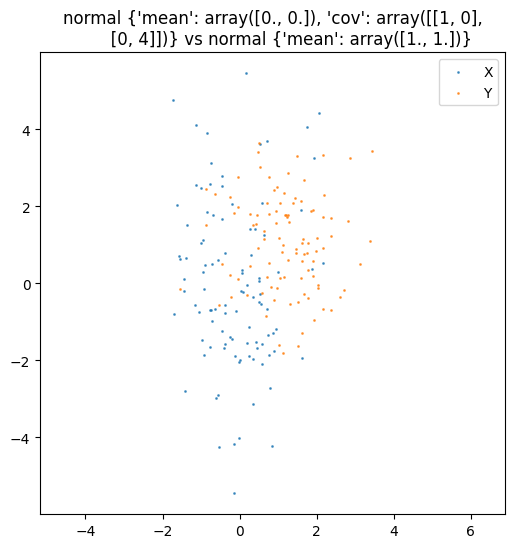

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.6718 (time: 0.00s)
   Gromov-Wasserstein:      1.2595043405101551 (time: 0.03s)
   Standard OT:             1.3764689021962546 (time: 0.00s)
   Procrustes OT:           0.8904950736014421 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1879, 0.024s
      k= 10, t= 1: 0.2763, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.434, 0.000s
      n_proj=1000: 1.381, 0.021s
      n_proj=10000: 1.376, 0.208s



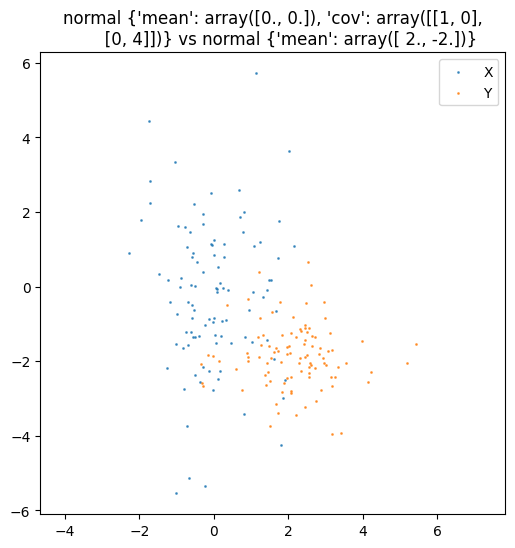

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.6827 (time: 0.02s)
   Gromov-Wasserstein:      1.3305736196070594 (time: 0.03s)
   Standard OT:             1.6784448140074402 (time: 0.00s)
   Procrustes OT:           0.9800540984268907 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2126, 0.017s
      k= 10, t= 1: 0.2882, 0.013s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.925, 0.001s
      n_proj=1000: 2.011, 0.025s
      n_proj=10000: 2.019, 0.194s



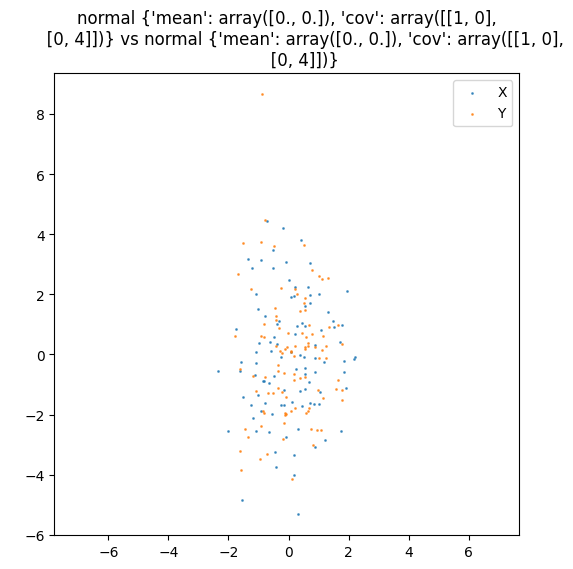

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   0.3725 (time: 0.00s)
   Gromov-Wasserstein:      0.7854685222244485 (time: 0.02s)
   Standard OT:             0.6963677928801277 (time: 0.00s)
   Procrustes OT:           0.7401055186217532 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2984, 0.009s
      k= 10, t= 1: 0.8554, 0.021s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.3584, 0.003s
      n_proj=1000: 0.3689, 0.026s
      n_proj=10000: 0.3696, 0.198s



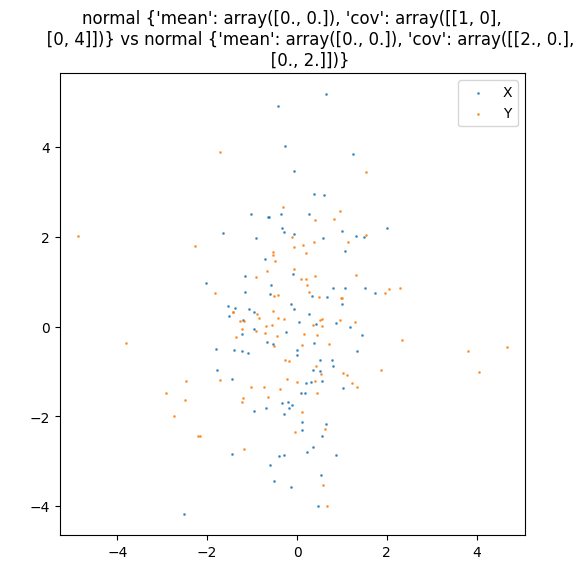

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.5462 (time: 0.00s)
   Gromov-Wasserstein:      0.937041336377895 (time: 0.02s)
   Standard OT:             0.8582715548274 (time: 0.00s)
   Procrustes OT:           0.8325387965915986 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2475, 0.016s
      k= 10, t= 1: 0.4167, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.4806, 0.002s
      n_proj=1000: 0.4782, 0.028s
      n_proj=10000: 0.478, 0.220s



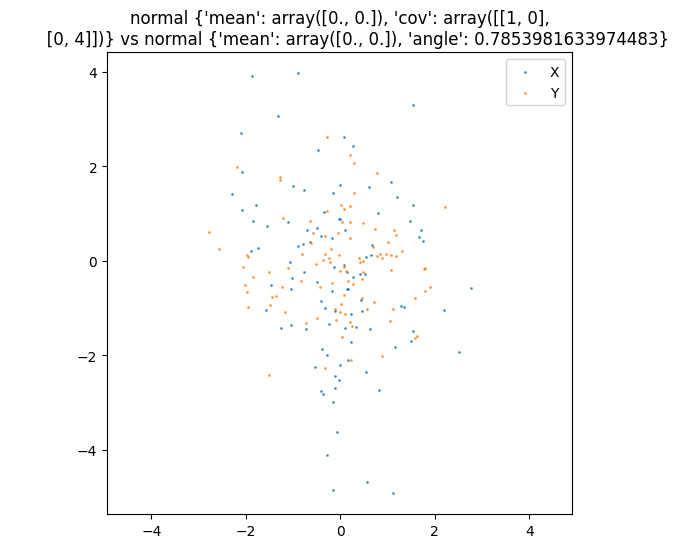

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.5518 (time: 0.00s)
   Gromov-Wasserstein:      1.0673673266860673 (time: 0.02s)
   Standard OT:             0.8914706957536446 (time: 0.00s)
   Procrustes OT:           0.8560410387362886 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1694, 0.015s
      k= 10, t= 1: 0.2536, 0.018s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.5501, 0.000s
      n_proj=1000: 0.5704, 0.022s
      n_proj=10000: 0.5715, 0.245s



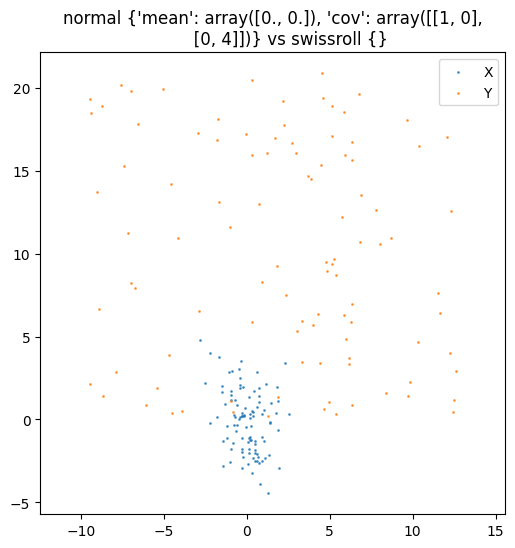

(normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])}) vs (swissroll, {})
   SlicedWasserstein-PCA:   4.916 (time: 0.00s)
   Gromov-Wasserstein:      9.793511318246798 (time: 0.03s)
   Standard OT:             3.4385280179470037 (time: 0.00s)
   Procrustes OT:           2.5574514176440073 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2225, 0.012s
      k= 10, t= 1: 0.2809, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 8.886, 0.001s
      n_proj=1000: 8.892, 0.022s
      n_proj=10000: 8.887, 0.225s



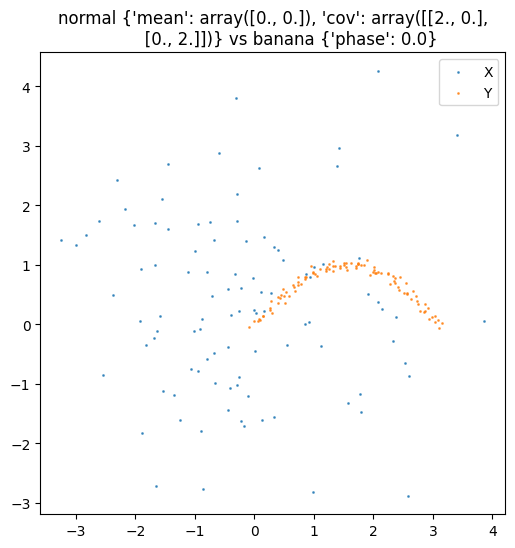

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.9093 (time: 0.00s)
   Gromov-Wasserstein:      1.689976034103719 (time: 0.02s)
   Standard OT:             1.4661402611758367 (time: 0.00s)
   Procrustes OT:           1.0836910335032046 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2093, 0.015s
      k= 10, t= 1: 0.392, 0.000s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.59, 0.000s
      n_proj=1000: 1.556, 0.032s
      n_proj=10000: 1.554, 0.190s



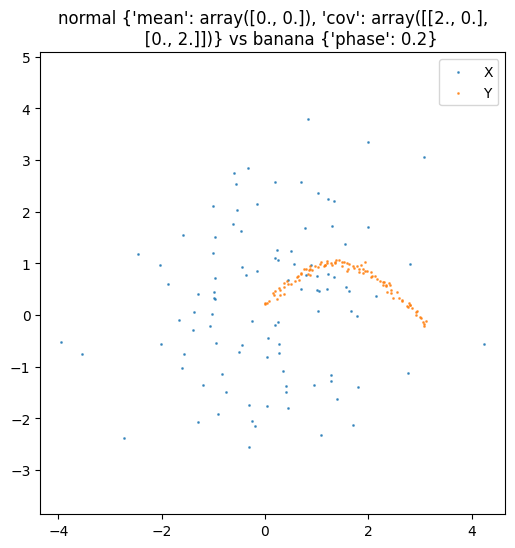

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.8424 (time: 0.01s)
   Gromov-Wasserstein:      1.6048119514907457 (time: 0.05s)
   Standard OT:             1.3804576149181758 (time: 0.00s)
   Procrustes OT:           1.0607704559622313 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2129, 0.008s
      k= 10, t= 1: 0.3442, 0.015s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.431, 0.005s
      n_proj=1000: 1.389, 0.022s
      n_proj=10000: 1.385, 0.209s



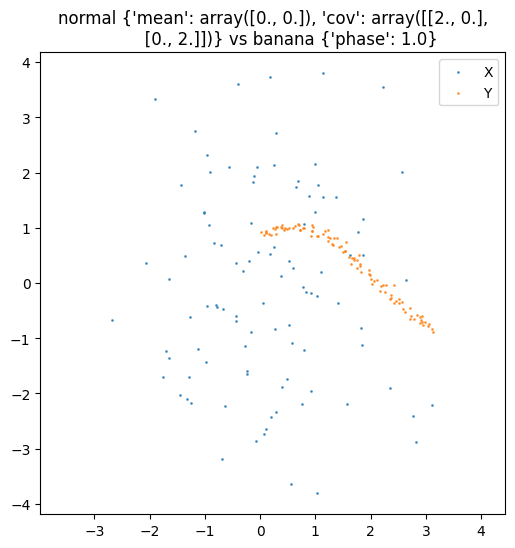

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.8934 (time: 0.01s)
   Gromov-Wasserstein:      1.6106632743636369 (time: 0.02s)
   Standard OT:             1.3923558257935973 (time: 0.01s)
   Procrustes OT:           1.0732613047919415 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1876, 0.006s
      k= 10, t= 1: 0.3509, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.456, 0.000s
      n_proj=1000: 1.41, 0.024s
      n_proj=10000: 1.407, 0.193s



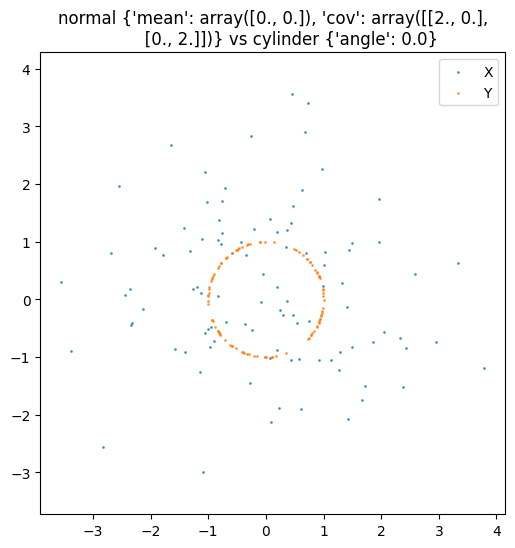

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.7201 (time: 0.00s)
   Gromov-Wasserstein:      1.347606847467912 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1809, 0.024s
      k= 10, t= 1: 0.1967, 0.011s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



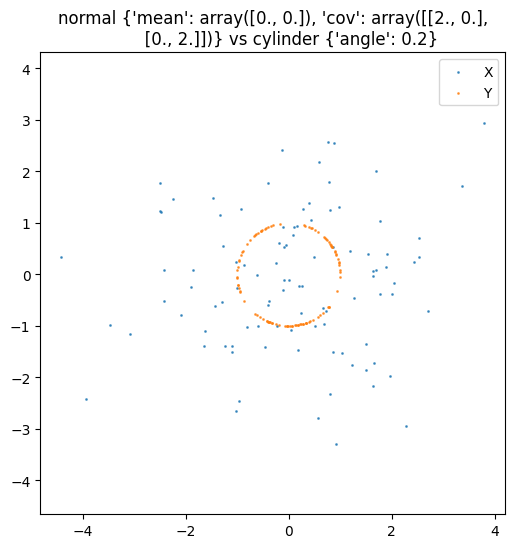

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.8266 (time: 0.00s)
   Gromov-Wasserstein:      1.5156851537362046 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2429, 0.016s
      k= 10, t= 1: 0.2597, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



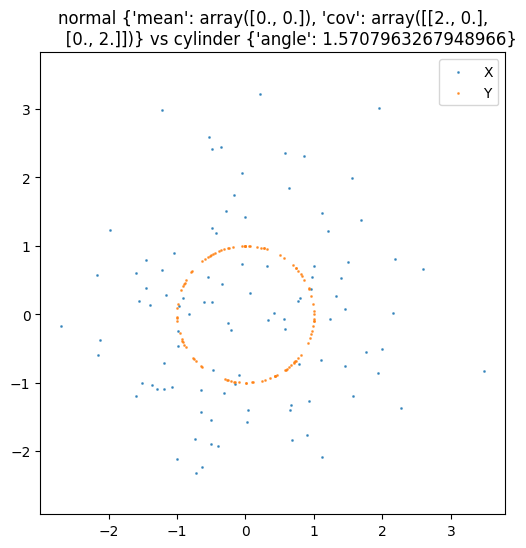

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.5851 (time: 0.01s)
   Gromov-Wasserstein:      1.0795701586356499 (time: 0.03s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.157, 0.014s
      k= 10, t= 1: 0.1582, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



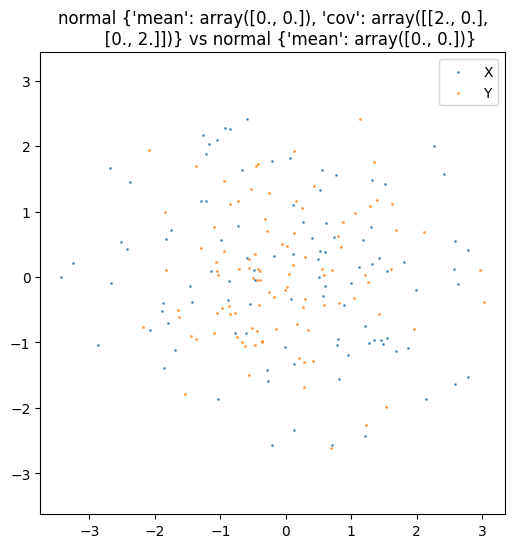

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.4259 (time: 0.00s)
   Gromov-Wasserstein:      0.8378165496903531 (time: 0.03s)
   Standard OT:             0.8046394038175484 (time: 0.00s)
   Procrustes OT:           0.7884448293621799 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1613, 0.021s
      k= 10, t= 1: 0.1988, 0.012s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.4162, 0.006s
      n_proj=1000: 0.4208, 0.033s
      n_proj=10000: 0.4214, 0.242s



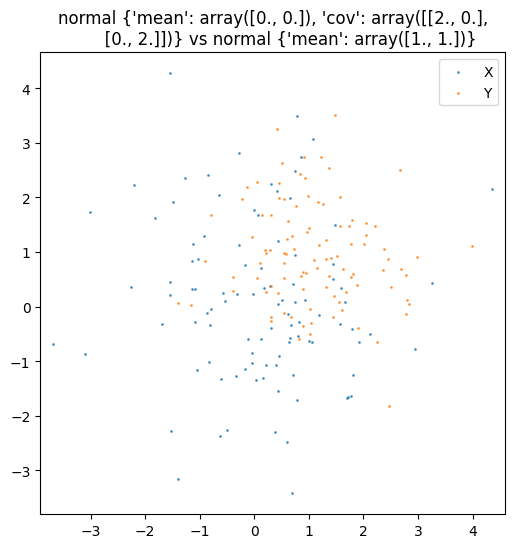

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.4737 (time: 0.00s)
   Gromov-Wasserstein:      0.9963594815473019 (time: 0.02s)
   Standard OT:             1.2072101909909905 (time: 0.00s)
   Procrustes OT:           0.7768205298684124 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.2343, 0.022s
      k= 10, t= 1: 0.216, 0.012s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.112, 0.003s
      n_proj=1000: 1.069, 0.023s
      n_proj=10000: 1.065, 0.196s



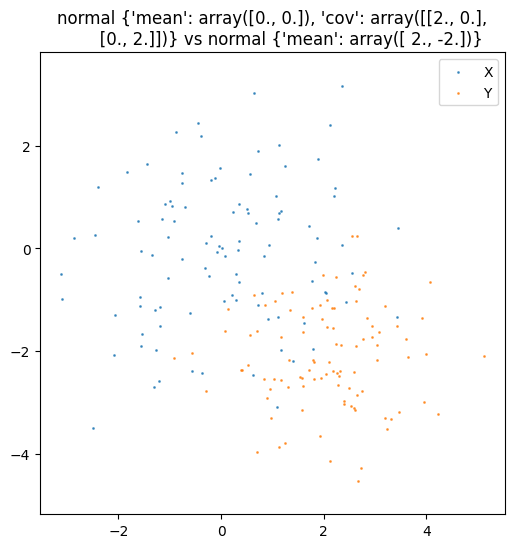

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.4111 (time: 0.01s)
   Gromov-Wasserstein:      0.8847802219976219 (time: 0.03s)
   Standard OT:             1.6989062384815485 (time: 0.00s)
   Procrustes OT:           0.7588721039828541 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1921, 0.016s
      k= 10, t= 1: 0.1521, 0.003s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.923, 0.011s
      n_proj=1000: 2.028, 0.018s
      n_proj=10000: 2.037, 0.222s



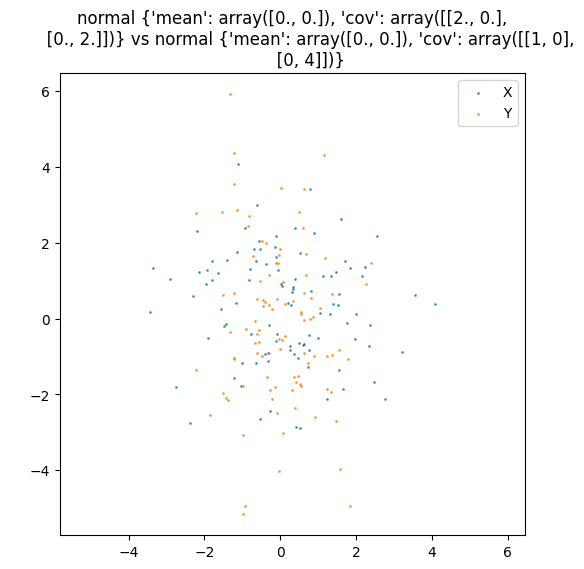

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   0.5241 (time: 0.00s)
   Gromov-Wasserstein:      0.8462833831400033 (time: 0.01s)
   Standard OT:             0.9726702298605591 (time: 0.02s)
   Procrustes OT:           0.8722677779168183 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1485, 0.023s
      k= 10, t= 1: 0.3389, 0.014s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.5915, 0.003s
      n_proj=1000: 0.5901, 0.020s
      n_proj=10000: 0.5892, 0.234s



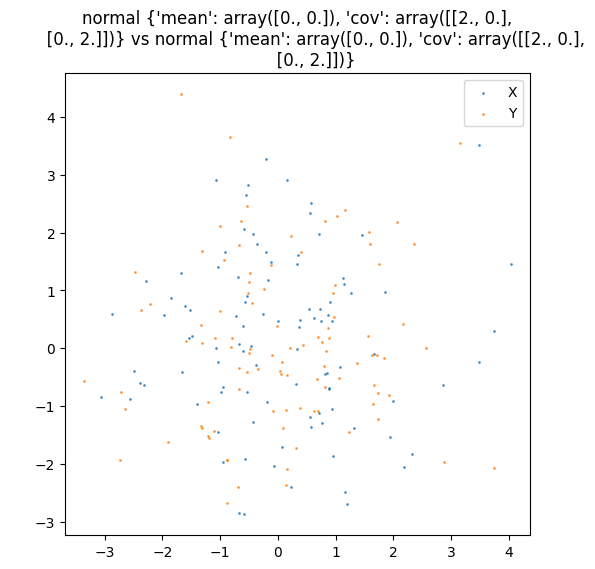

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.2472 (time: 0.00s)
   Gromov-Wasserstein:      0.5674688072386656 (time: 0.02s)
   Standard OT:             0.7101962885668888 (time: 0.00s)
   Procrustes OT:           0.7144777467221387 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1464, 0.016s
      k= 10, t= 1: 0.2036, 0.014s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.2474, 0.003s
      n_proj=1000: 0.2585, 0.024s
      n_proj=10000: 0.2596, 0.208s



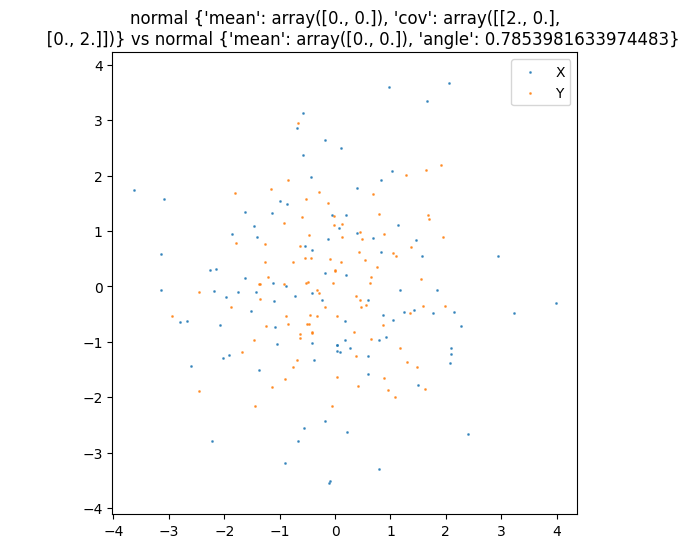

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.4774 (time: 0.00s)
   Gromov-Wasserstein:      0.9861066902569529 (time: 0.03s)
   Standard OT:             0.8462400895922156 (time: 0.00s)
   Procrustes OT:           0.8128316896451317 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.149, 0.017s
      k= 10, t= 1: 0.1428, 0.007s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.4846, 0.003s
      n_proj=1000: 0.4911, 0.027s
      n_proj=10000: 0.4918, 0.211s



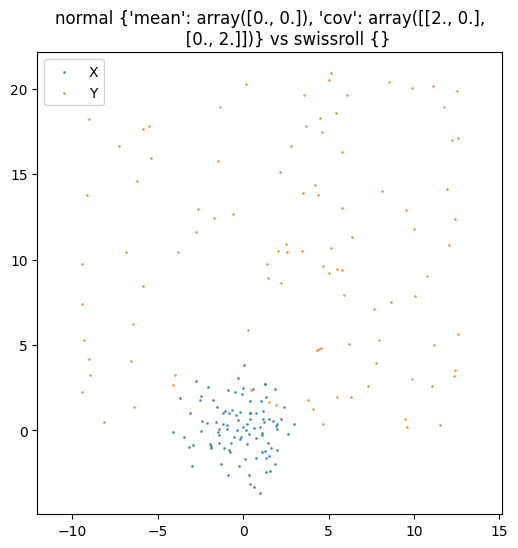

(normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])}) vs (swissroll, {})
   SlicedWasserstein-PCA:   4.861 (time: 0.00s)
   Gromov-Wasserstein:      9.762463716586073 (time: 0.03s)
   Standard OT:             3.432739180291354 (time: 0.00s)
   Procrustes OT:           2.51303933615134 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.166, 0.020s
      k= 10, t= 1: 0.2194, 0.013s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 9.007, 0.000s
      n_proj=1000: 8.916, 0.026s
      n_proj=10000: 8.903, 0.257s



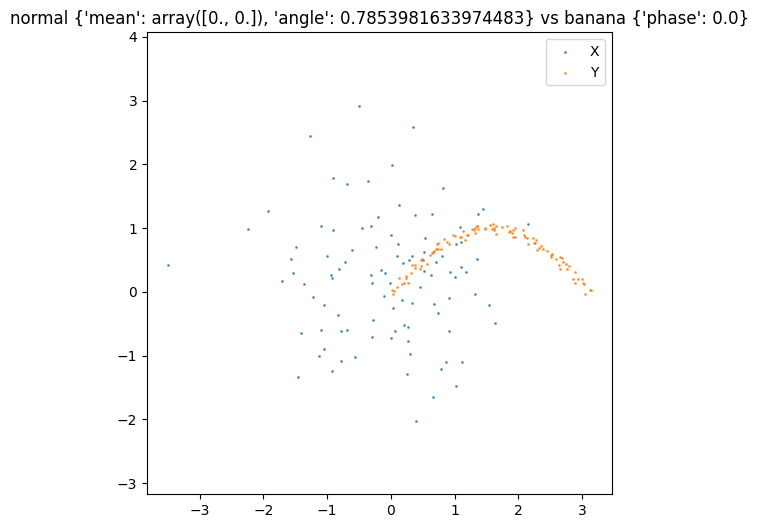

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.4692 (time: 0.00s)
   Gromov-Wasserstein:      0.8386228957852729 (time: 0.03s)
   Standard OT:             1.3301326928402262 (time: 0.00s)
   Procrustes OT:           0.8188291960752969 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1666, 0.016s
      k= 10, t= 1: 0.2666, 0.008s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.311, 0.005s
      n_proj=1000: 1.267, 0.020s
      n_proj=10000: 1.263, 0.204s



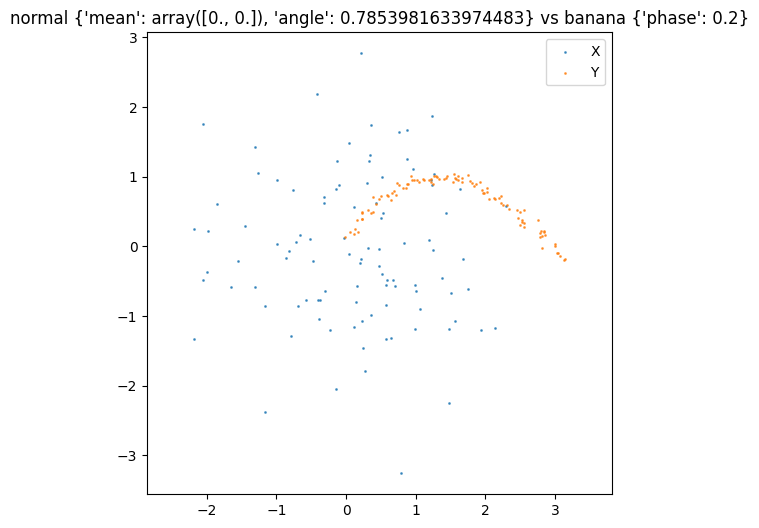

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.5495 (time: 0.00s)
   Gromov-Wasserstein:      0.9811870290171159 (time: 0.02s)
   Standard OT:             1.3197086163826788 (time: 0.00s)
   Procrustes OT:           0.8753226714222793 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1606, 0.024s
      k= 10, t= 1: 0.2789, 0.012s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.319, 0.005s
      n_proj=1000: 1.265, 0.025s
      n_proj=10000: 1.261, 0.205s



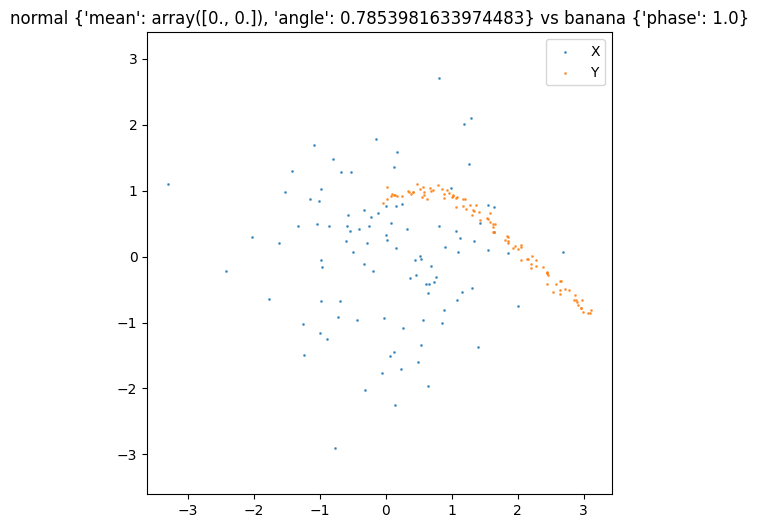

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.6341 (time: 0.00s)
   Gromov-Wasserstein:      0.8721467794848488 (time: 0.02s)
   Standard OT:             1.286463693259285 (time: 0.00s)
   Procrustes OT:           0.8696938016442917 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1484, 0.008s
      k= 10, t= 1: 0.3004, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.257, 0.004s
      n_proj=1000: 1.208, 0.019s
      n_proj=10000: 1.204, 0.222s



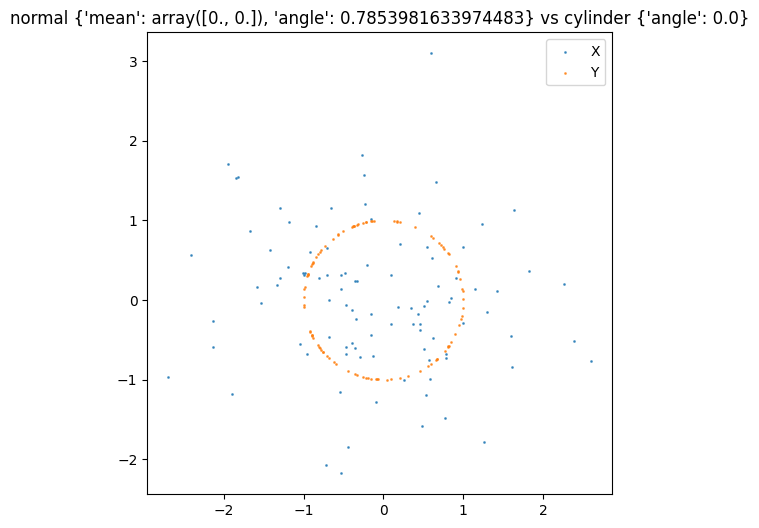

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   0.4109 (time: 0.00s)
   Gromov-Wasserstein:      0.7281527415361884 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1452, 0.007s
      k= 10, t= 1: 0.1904, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



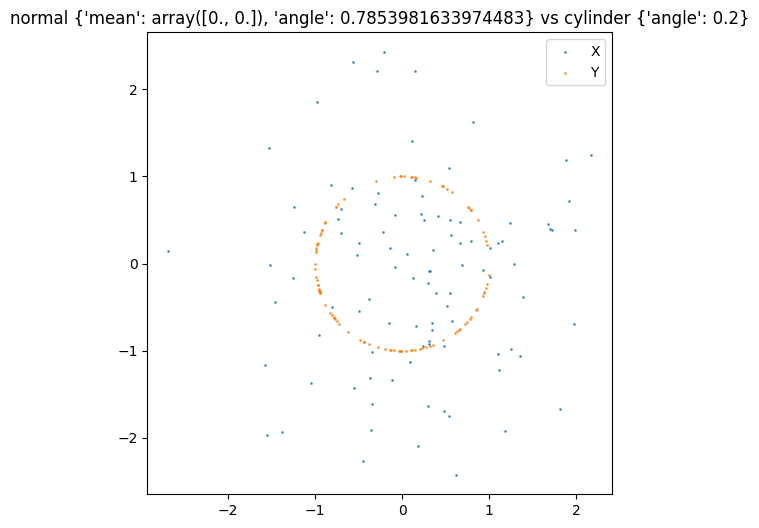

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   0.3827 (time: 0.00s)
   Gromov-Wasserstein:      0.6958827483753693 (time: 0.02s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1393, 0.008s
      k= 10, t= 1: 0.1579, 0.018s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



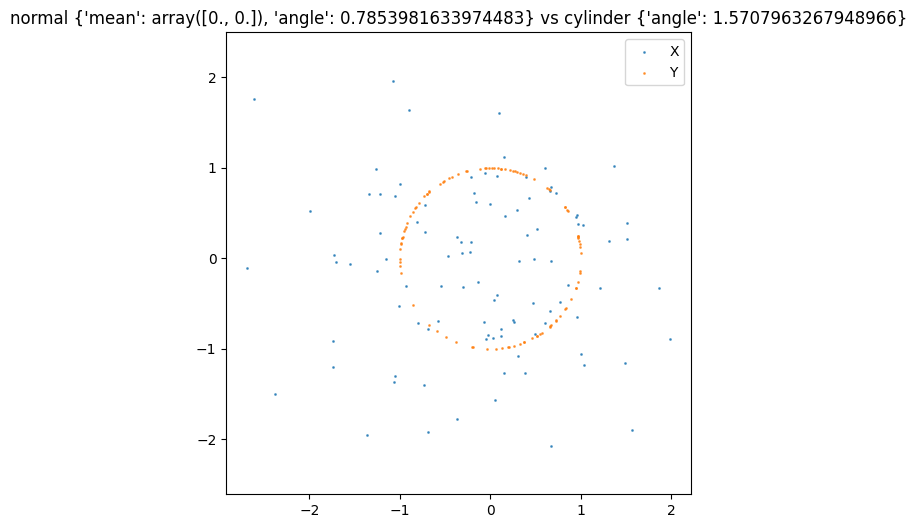

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   0.3435 (time: 0.00s)
   Gromov-Wasserstein:      0.6299209547624516 (time: 0.06s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1408, 0.014s
      k= 10, t= 1: 0.1614, 0.025s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



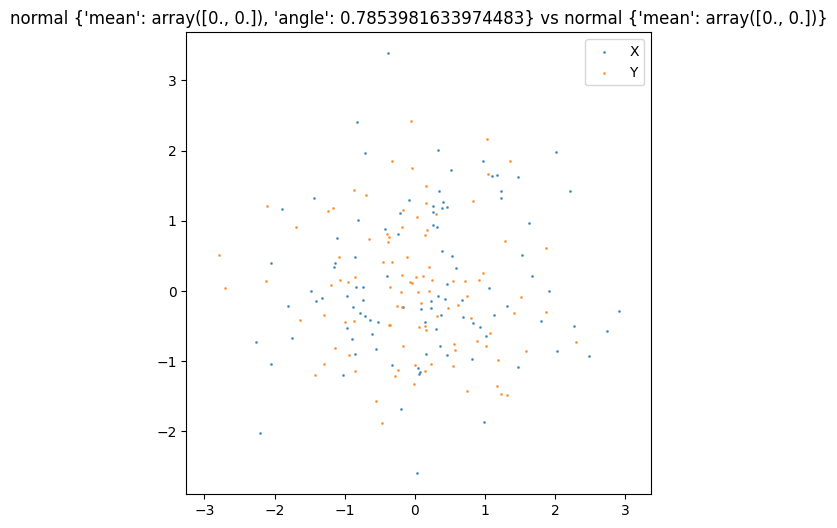

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   0.1975 (time: 0.00s)
   Gromov-Wasserstein:      0.5041266635332777 (time: 0.02s)
   Standard OT:             0.6514697782429442 (time: 0.00s)
   Procrustes OT:           0.6487769646392026 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1301, 0.025s
      k= 10, t= 1: 0.09066, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.273, 0.001s
      n_proj=1000: 0.2625, 0.024s
      n_proj=10000: 0.2614, 0.241s



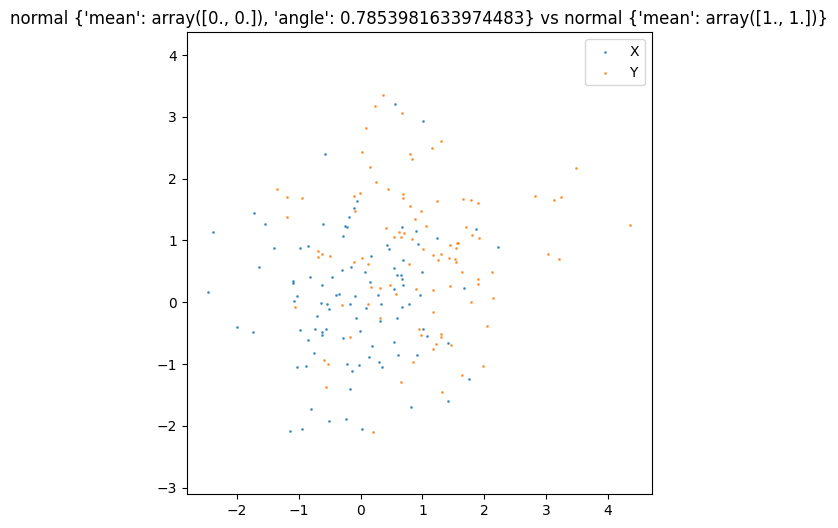

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   0.2001 (time: 0.00s)
   Gromov-Wasserstein:      0.46543100578851226 (time: 0.01s)
   Standard OT:             1.1227545891256807 (time: 0.01s)
   Procrustes OT:           0.6229865501811837 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1363, 0.020s
      k= 10, t= 1: 0.1758, 0.013s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.9553, 0.003s
      n_proj=1000: 0.9081, 0.025s
      n_proj=10000: 0.9038, 0.231s



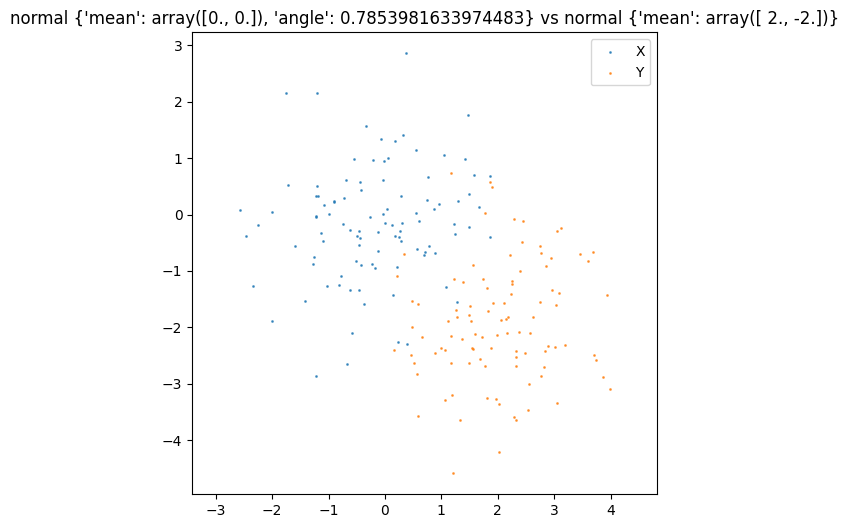

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   0.1252 (time: 0.01s)
   Gromov-Wasserstein:      0.4215416560502525 (time: 0.01s)
   Standard OT:             1.6819912291322199 (time: 0.00s)
   Procrustes OT:           0.6180405450080966 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1161, 0.004s
      k= 10, t= 1: 0.1788, 0.021s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 1.88, 0.000s
      n_proj=1000: 1.975, 0.048s
      n_proj=10000: 1.984, 0.235s



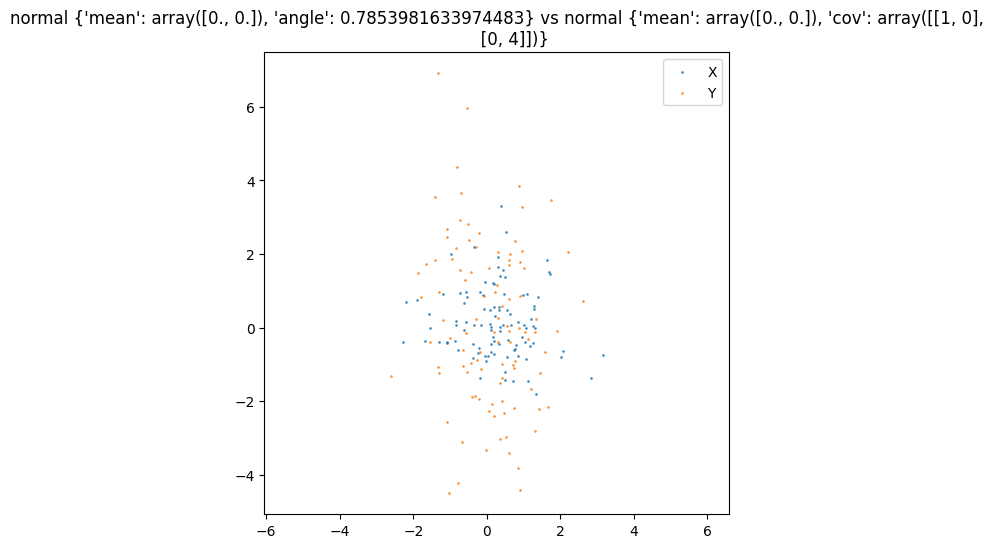

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   0.8757 (time: 0.00s)
   Gromov-Wasserstein:      1.6765757438803364 (time: 0.02s)
   Standard OT:             1.0670475761936336 (time: 0.00s)
   Procrustes OT:           1.042611022495395 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1073, 0.020s
      k= 10, t= 1: 0.2165, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.8455, 0.004s
      n_proj=1000: 0.8688, 0.025s
      n_proj=10000: 0.8701, 0.213s



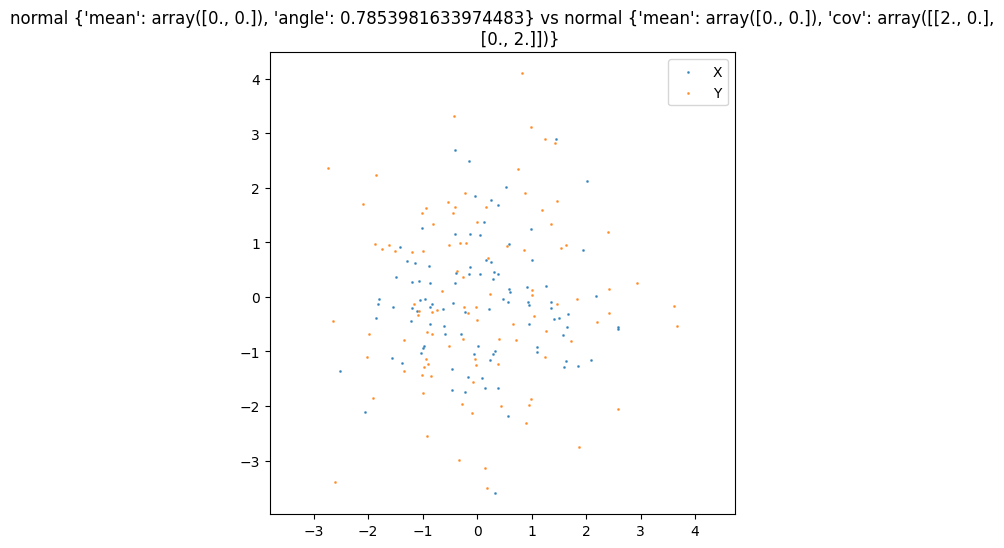

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   0.4121 (time: 0.00s)
   Gromov-Wasserstein:      0.84820019802852 (time: 0.02s)
   Standard OT:             0.774155063832662 (time: 0.00s)
   Procrustes OT:           0.7784785316553834 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1203, 0.015s
      k= 10, t= 1: 0.1631, 0.014s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.4025, 0.002s
      n_proj=1000: 0.4072, 0.029s
      n_proj=10000: 0.4074, 0.221s



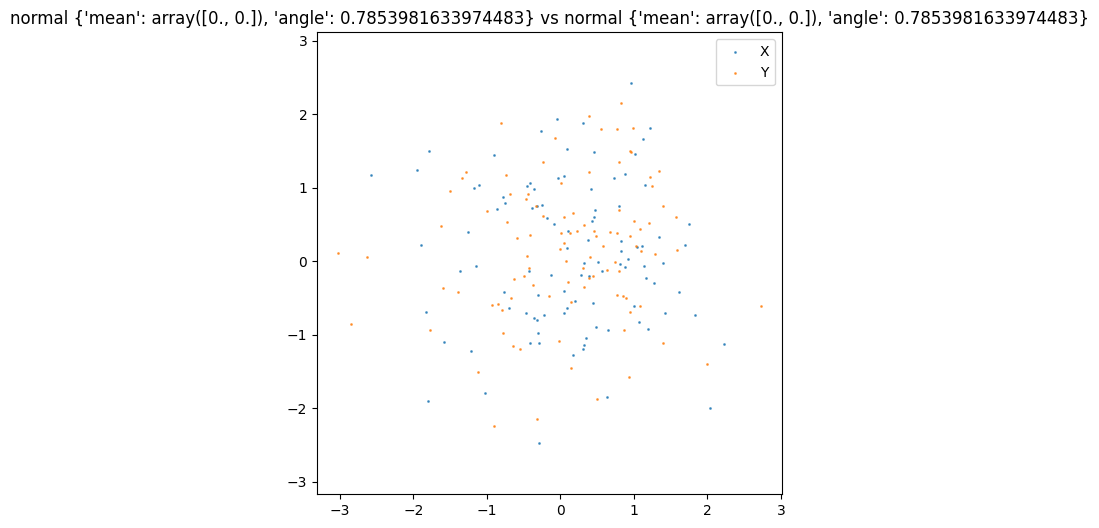

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   0.1649 (time: 0.00s)
   Gromov-Wasserstein:      0.35727469899311604 (time: 0.02s)
   Standard OT:             0.5760832637901637 (time: 0.00s)
   Procrustes OT:           0.5665309253025597 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1115, 0.016s
      k= 10, t= 1: 0.1495, 0.023s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.1534, 0.000s
      n_proj=1000: 0.1545, 0.026s
      n_proj=10000: 0.1543, 0.201s



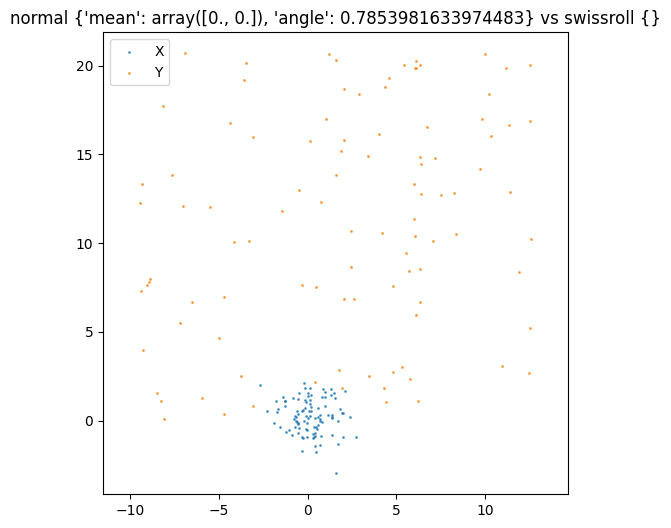

(normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483}) vs (swissroll, {})
   SlicedWasserstein-PCA:   5.331 (time: 0.00s)
   Gromov-Wasserstein:      10.693520061959449 (time: 0.01s)
   Standard OT:             3.5314101035458707 (time: 0.00s)
   Procrustes OT:           2.654796697608148 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.1487, 0.021s
      k= 10, t= 1: 0.1639, 0.014s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 9.536, 0.003s
      n_proj=1000: 9.507, 0.026s
      n_proj=10000: 9.498, 0.221s



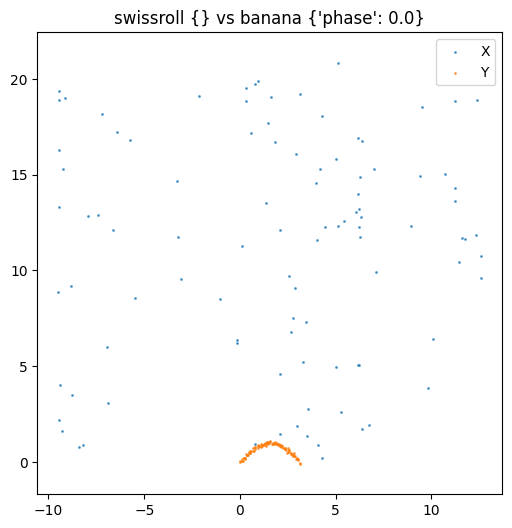

(swissroll, {}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   5.644 (time: 0.00s)
   Gromov-Wasserstein:      11.248086527108535 (time: 0.03s)
   Standard OT:             3.4673826066625892 (time: 0.00s)
   Procrustes OT:           2.7301427240244798 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.5933, 0.012s
      k= 10, t= 1: 1.293, 0.011s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 9.211, 0.002s
      n_proj=1000: 9.317, 0.027s
      n_proj=10000: 9.322, 0.191s



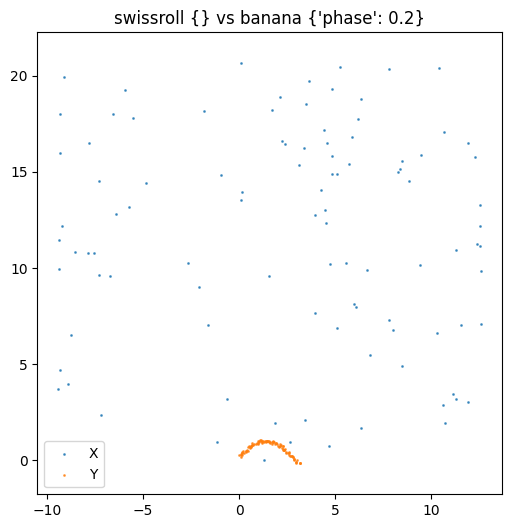

(swissroll, {}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   5.716 (time: 0.01s)
   Gromov-Wasserstein:      11.373566587467106 (time: 0.01s)
   Standard OT:             3.5800968789782566 (time: 0.00s)
   Procrustes OT:           2.75941591779099 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.5455, 0.006s
      k= 10, t= 1: 1.24, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 9.63, 0.004s
      n_proj=1000: 9.704, 0.026s
      n_proj=10000: 9.706, 0.204s



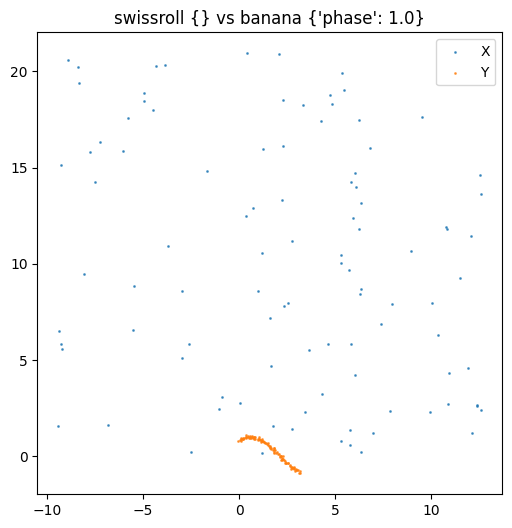

(swissroll, {}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   5.703 (time: 0.00s)
   Gromov-Wasserstein:      11.247530630810948 (time: 0.05s)
   Standard OT:             3.3812918737691224 (time: 0.00s)
   Procrustes OT:           2.740038201318658 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.5599, 0.013s
      k= 10, t= 1: 1.511, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 8.822, 0.004s
      n_proj=1000: 8.92, 0.020s
      n_proj=10000: 8.924, 0.203s



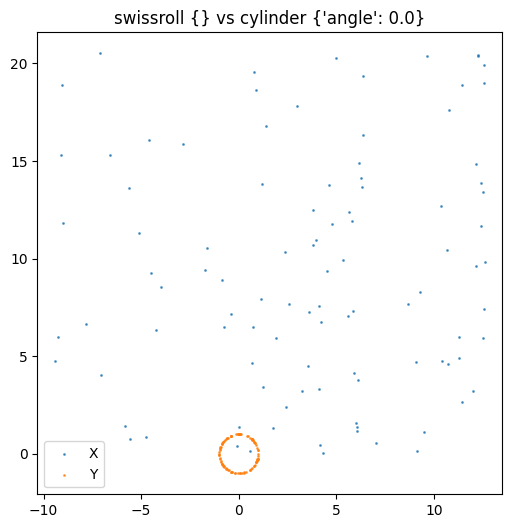

(swissroll, {}) vs (cylinder, {'angle': 0.0})
   SlicedWasserstein-PCA:   5.48 (time: 0.00s)
   Gromov-Wasserstein:      10.801351966849888 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.4799, 0.020s
      k= 10, t= 1: 0.928, 0.021s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



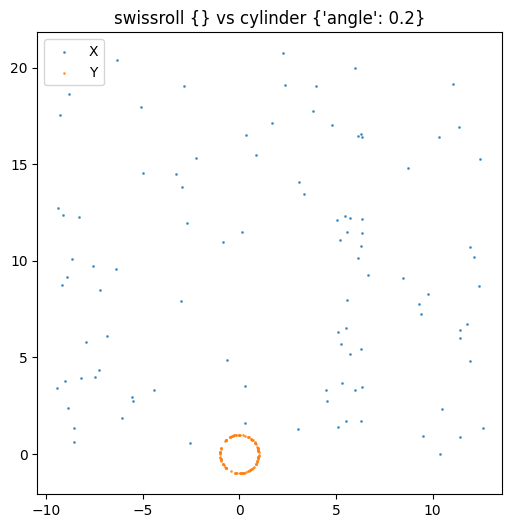

(swissroll, {}) vs (cylinder, {'angle': 0.2})
   SlicedWasserstein-PCA:   5.77 (time: 0.01s)
   Gromov-Wasserstein:      11.382173915103321 (time: 0.04s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.5768, 0.015s
      k= 10, t= 1: 0.8543, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



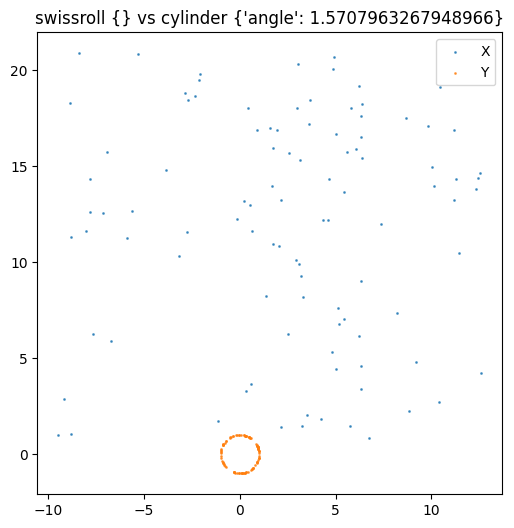

(swissroll, {}) vs (cylinder, {'angle': 1.5707963267948966})
   SlicedWasserstein-PCA:   5.158 (time: 0.00s)
   Gromov-Wasserstein:      10.160237558691401 (time: 0.05s)
   Standard OT:             Error
   Procrustes OT:           Error
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.6346, 0.011s
      k= 10, t= 1: 0.9528, 0.016s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: Error
      n_proj=1000: Error
      n_proj=10000: Error



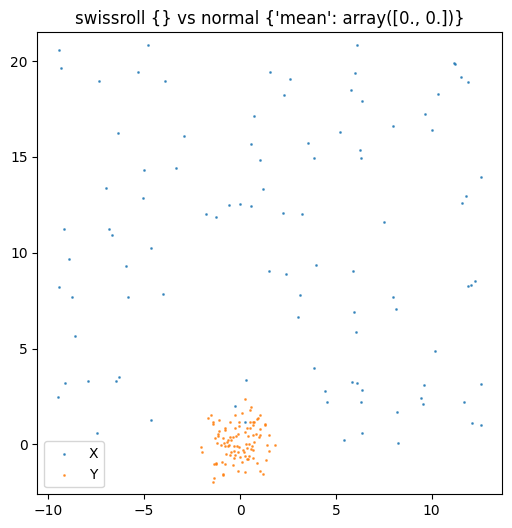

(swissroll, {}) vs (normal, {'mean': array([0., 0.])})
   SlicedWasserstein-PCA:   5.751 (time: 0.00s)
   Gromov-Wasserstein:      11.494431502763648 (time: 0.03s)
   Standard OT:             3.5277528979645405 (time: 0.00s)
   Procrustes OT:           2.75786223751339 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.7835, 0.022s
      k= 10, t= 1: 0.7118, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 9.425, 0.001s
      n_proj=1000: 9.418, 0.025s
      n_proj=10000: 9.413, 0.287s



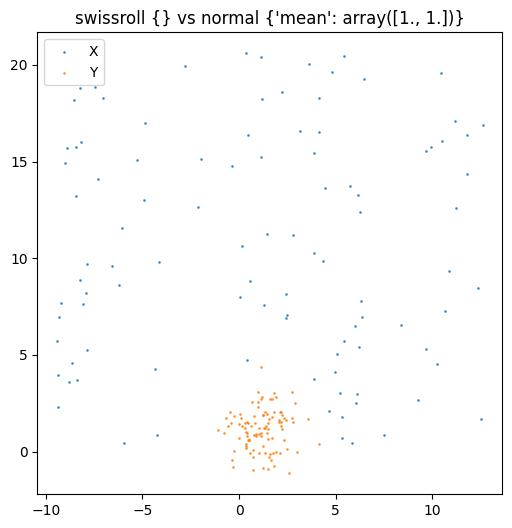

(swissroll, {}) vs (normal, {'mean': array([1., 1.])})
   SlicedWasserstein-PCA:   5.438 (time: 0.00s)
   Gromov-Wasserstein:      10.865079192770992 (time: 0.03s)
   Standard OT:             3.378197768760082 (time: 0.00s)
   Procrustes OT:           2.6950807117016127 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 1.009, 0.010s
      k= 10, t= 1: 0.8847, 0.021s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 8.501, 0.005s
      n_proj=1000: 8.616, 0.028s
      n_proj=10000: 8.622, 0.245s



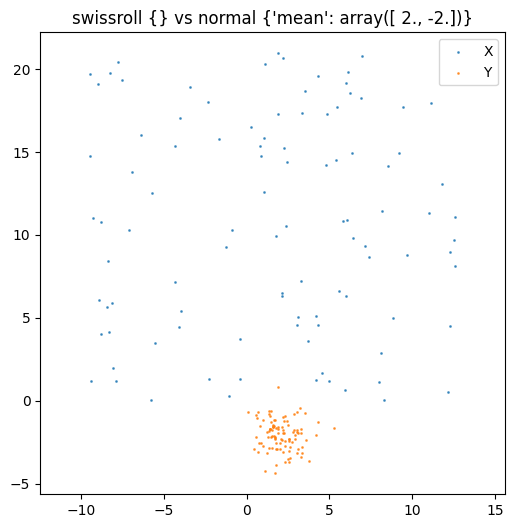

(swissroll, {}) vs (normal, {'mean': array([ 2., -2.])})
   SlicedWasserstein-PCA:   5.591 (time: 0.00s)
   Gromov-Wasserstein:      11.170424810490983 (time: 0.01s)
   Standard OT:             3.755644343378848 (time: 0.00s)
   Procrustes OT:           2.733913915046633 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 1.042, 0.011s
      k= 10, t= 1: 1.233, 0.025s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 10.4, 0.002s
      n_proj=1000: 10.61, 0.026s
      n_proj=10000: 10.62, 0.216s



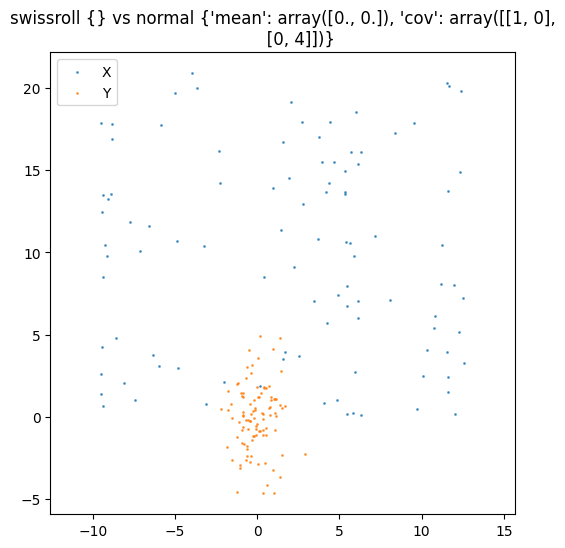

(swissroll, {}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[1, 0],
       [0, 4]])})
   SlicedWasserstein-PCA:   5.283 (time: 0.00s)
   Gromov-Wasserstein:      10.535786028544138 (time: 0.04s)
   Standard OT:             3.468933681727862 (time: 0.00s)
   Procrustes OT:           2.6491472533542733 (time: 0.02s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.9206, 0.010s
      k= 10, t= 1: 1.553, 0.018s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 8.912, 0.004s
      n_proj=1000: 8.885, 0.028s
      n_proj=10000: 8.878, 0.225s



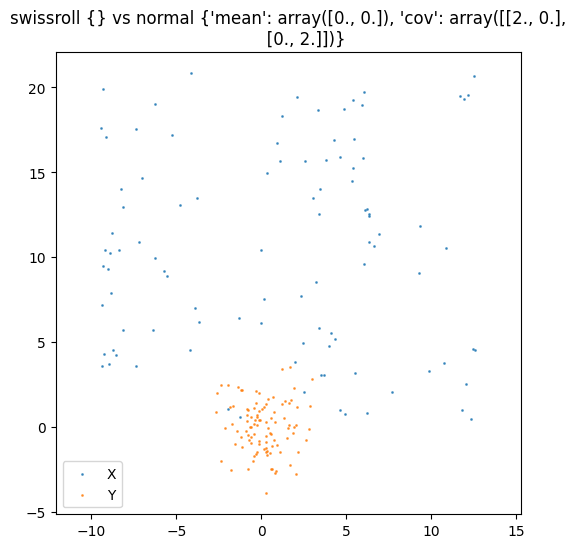

(swissroll, {}) vs (normal, {'mean': array([0., 0.]), 'cov': array([[2., 0.],
       [0., 2.]])})
   SlicedWasserstein-PCA:   5.113 (time: 0.00s)
   Gromov-Wasserstein:      10.242497603741999 (time: 0.02s)
   Standard OT:             3.4607161717991115 (time: 0.00s)
   Procrustes OT:           2.6266061139939945 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.7466, 0.017s
      k= 10, t= 1: 0.9815, 0.011s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 8.886, 0.004s
      n_proj=1000: 8.953, 0.026s
      n_proj=10000: 8.954, 0.223s



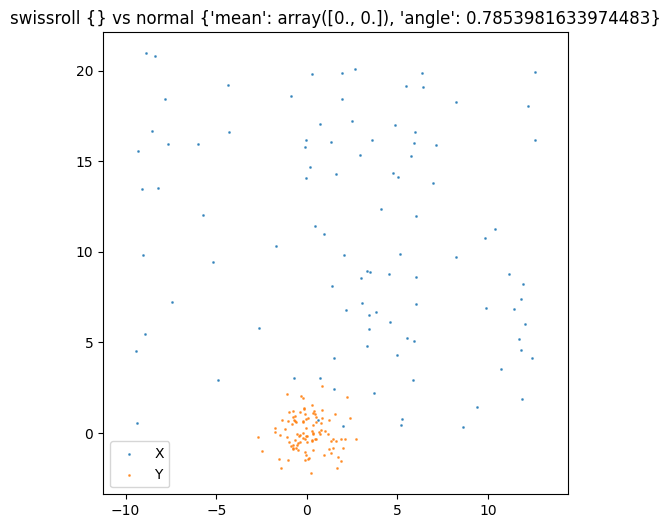

(swissroll, {}) vs (normal, {'mean': array([0., 0.]), 'angle': 0.7853981633974483})
   SlicedWasserstein-PCA:   5.092 (time: 0.01s)
   Gromov-Wasserstein:      10.214159976909592 (time: 0.02s)
   Standard OT:             3.5064771168532003 (time: 0.00s)
   Procrustes OT:           2.5757932144194875 (time: 0.01s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.8512, 0.010s
      k= 10, t= 1: 0.8867, 0.017s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 9.313, 0.002s
      n_proj=1000: 9.318, 0.030s
      n_proj=10000: 9.313, 0.200s



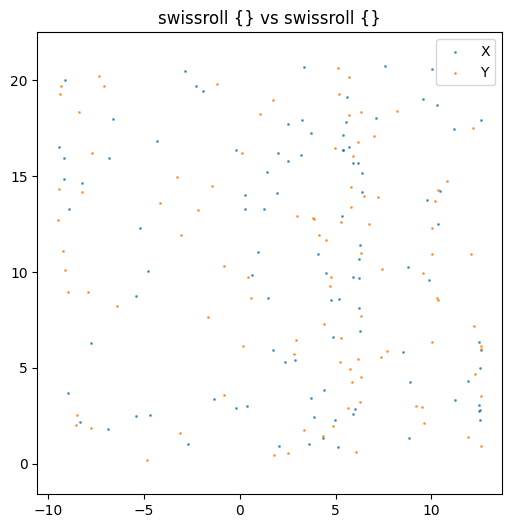

(swissroll, {}) vs (swissroll, {})
   SlicedWasserstein-PCA:   0.9795 (time: 0.00s)
   Gromov-Wasserstein:      2.0434272973510694 (time: 0.02s)
   Standard OT:             1.3311791351838091 (time: 0.00s)
   Procrustes OT:           1.5678484492460574 (time: 0.00s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.4587, 0.013s
      k= 10, t= 1: 0.9704, 0.019s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.8683, 0.002s
      n_proj=1000: 0.8791, 0.020s
      n_proj=10000: 0.8811, 0.234s



In [2]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes
from scipy.sparse.linalg import eigsh
from sklearn import datasets
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
import os


try:
    import ot  # POT: Python Optimal Transport
    has_pot = True
except ImportError:
    print("python-ot (POT) not found, Gromov-Wasserstein/OT comparison disabled")
    has_pot = False

######################
# Embedding Functions #
######################

def pca_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=k if k else X.shape[1])
    pca.fit(Xc)
    return pca.transform(Xc)  # returns n x k array, like diffusion_embedding

# think more about t and symmetric normalization
def diffusion_embedding(X, k=5, epsilon=None, t=1):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    D_sq = cdist(Xc, Xc, 'sqeuclidean')
    if epsilon is None:
        epsilon = np.median(D_sq)
    K = np.exp(-D_sq / epsilon)
    d = np.sum(K, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    P_tilde = D_inv_sqrt @ K @ D_inv_sqrt

    # --- Choose eigensolver automatically ---
    # Full eigendecomposition if k >= n-1
    if k >= n - 1:
        vals, vecs = eigh(P_tilde)
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        # Remove the trivial eigenvector (usually the top one)
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]
    else:
        # Partial: only top k+1
        vals, vecs = eigsh(P_tilde, k=k+1, which='LM')
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]

    embedding_matrix = phis * (lambdas ** t)
    return embedding_matrix


###################################
# Sliced Wasserstein Assignment   #
###################################

def get_sorted_columns(A):
    # A: n x k array
    # Returns: list of length k, each is sorted 1D array of size n
    return [np.sort(A[:, i]) for i in range(A.shape[1])]

# write more general 1D Wasserstein distance
def compute_1d_wasserstein_sorted(u_sorted, v_sorted):
    # Both should be pre-sorted arrays
    return np.mean((u_sorted - v_sorted)**2) # square is built in

def assignment_sliced_wasserstein(X, Y, AX, BY):
    k = AX.shape[1]
    # Precompute and cache sorted columns
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            d_pos = compute_1d_wasserstein_sorted(AX_sorted[i], BY_sorted[j])
            d_neg = compute_1d_wasserstein_sorted(AX_sorted[i], -BY_sorted[j])
            C[i, j] = min(d_pos, d_neg) # square has been done already
    row_ind, col_ind = linear_sum_assignment(C)
    total_cost = C[row_ind, col_ind].sum()
    return np.sqrt(total_cost/k) # to hopefully be a pseudometric - regardless, matching units

##############################
# Baselines: GW and OT and ...#
##############################

def gromov_wasserstein(X, Y):
    if not has_pot:
        return np.nan
    C1 = cdist(X, X)  # pairwise distance matrix for X
    C2 = cdist(Y, Y)  # pairwise distance matrix for Y
    # we assume uniform distributions for both sets
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    # GW returns the cost directly (not the coupling)
    gw_cost = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return np.sqrt(gw_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent


def standard_ot(X, Y):
    if X.shape[1] != Y.shape[1]: # need to live in same dimensional space
        raise ValueError(f"OT: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    # same deal as GW
    C = cdist(X, Y)
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    T = ot.emd(p, q, C, numItermax=10000000)
    ot_cost = (C * T).sum()
    return np.sqrt(ot_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent

def orthogonal_procrustes_matching(X, Y, max_iter=100, tol=1e-6, verbose=False):
    """
    Find the best orthogonal R (no scaling) and permutation π so that Xc ≈ (Yc @ R)[π].
    Returns the sum of squared distances under that R + π.
    """
    # 1) center both clouds
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    n, d = Xc.shape

    # 2) start with the identity matching
    π = np.arange(n)
    cost_prev = np.inf

    for it in range(max_iter):
        # ─── Step 1: find the orthogonal rotation R (no scale) that best aligns Yc[π] → Xc ───
        R, _ = orthogonal_procrustes(Yc[π], Xc)
        Yc_rot = Yc @ R   # *** drop any scale ***

        # ─── Step 2: re‐compute the one‐to‐one assignment under the new rotation ───
        C = cdist(Xc, Yc_rot, metric='sqeuclidean')
        row_ind, col_ind = linear_sum_assignment(C)
        cost = C[row_ind, col_ind].sum()

        if verbose:
            print(f"Iter {it}: cost = {cost:.8f}")

        # check convergence
        if abs(cost - cost_prev) < tol:
            break

        cost_prev = cost
        π = col_ind

    # ─── Final transform (pure rotation + centroid shift) ───
    R, _ = orthogonal_procrustes(Yc[π], Xc)
    Yc_aligned = Yc @ R
    # add back X’s centroid
    Y_aligned = Yc_aligned + X.mean(axis=0)

    return cost, (Y_aligned, R, π)


def procrustes_ot(X, Y):
    if X.shape != Y.shape:
        raise ValueError(f"Procrustes: Shape mismatch {X.shape} vs {Y.shape}")
    cost, (Y_aligned, R, pi) = orthogonal_procrustes_matching(X, Y)
    # Now you can compare X and Y_aligned, or run OT/GW/etc.
    # For vanilla OT cost:
    return standard_ot(X, Y_aligned)

def sliced_wasserstein(X, Y, n_proj=100, p=2, seed=None):
    """
    Standard Sliced Wasserstein (squared Wp, default W2):
      - Projects onto random unit vectors
      - Computes 1D Wasserstein between projections
      - Returns the mean distance across all projections (root if p=2)
    """
    if X.shape[1] != Y.shape[1]:
        raise ValueError(f"SW: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    rng = np.random.default_rng(seed)
    n, d = X.shape
    m = Y.shape[0]
    dists = []
    for _ in range(n_proj):
        v = rng.normal(size=d)
        v /= np.linalg.norm(v)  # unit vector

        # Project onto v
        X_proj = np.dot(X, v)
        Y_proj = np.dot(Y, v)

        # Sort and compute 1D Wasserstein-p distance
        X_proj_sorted = np.sort(X_proj)
        Y_proj_sorted = np.sort(Y_proj)
        # Need equal sizes for empirical distributions: subsample or interpolate if needed
        n_used = min(len(X_proj_sorted), len(Y_proj_sorted))
        Xs = X_proj_sorted[:n_used]
        Ys = Y_proj_sorted[:n_used]
        dist = np.mean(np.abs(Xs - Ys) ** p)
        dists.append(dist)

    return np.mean(dists)**(1/p)




########################
# Synthetic Datasets   #
########################

def generate_dataset(kind, n=100, d=2, mean=None, cov=None, angle=None, phase=None):
    if kind == 'normal':
        m = mean if mean is not None else np.zeros(d)
        c = cov if cov is not None else np.eye(d)
        X = np.random.multivariate_normal(m, c, n)
        return X
    elif kind == 'banana':
        t = np.linspace(0, np.pi, n)
        phi = phase if phase is not None else 0.0
        X = np.vstack([t, np.sin(t + phi)]).T + 0.05 * np.random.randn(n, 2)
        return X
    elif kind == 'cylinder':
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-1, 1, n)
        ang = angle if angle is not None else 0.0
        X = np.vstack([np.cos(theta + ang), np.sin(theta + ang), z]).T
        return X
    elif kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        return X[:, :d]
    else:
        raise ValueError('Unknown dataset kind')

def plot_pair(X, Y, title=None, savepath=None):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], s=1, label='X', alpha=0.7)
    plt.scatter(Y[:,0], Y[:,1], s=1, label='Y', alpha=0.7)
    plt.axis('equal')
    plt.legend()
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

##########################################################
# Dataset parameterizations to try (expand as desired)   #
##########################################################

DATASET_PARAMS = {
    'banana': [
        dict(phase=0.0), 
        dict(phase=0.2),
        dict(phase=1.0),
    ],
    'cylinder': [
        dict(angle=0.0), 
        dict(angle=0.2),
        dict(angle=np.pi/2),
    ],
    'normal': [
        dict(mean=np.zeros(2)), 
        dict(mean=np.ones(2)), 
        dict(mean=np.array([2.0, -2.0])),
        dict(mean=np.zeros(2), cov=np.diag([1, 4])),
        dict(mean=np.zeros(2), cov=2*np.eye(2)),
        dict(mean=np.zeros(2), angle=np.pi/4),  # for rotation
    ],
    'swissroll': [
        dict(),  # no params
    ]
}

########################################
# Cartesian Product of Tests Framework #
########################################

def test_diffusion_grid(X, Y, k_values, t_values, distance_fn):
    results = {}
    for k in k_values:
        for t in t_values:
            try:
                t0 = time.time()
                AX = diffusion_embedding(X, k=k, t=t)
                BY = diffusion_embedding(Y, k=k, t=t)
                # Optionally rescale to match variance for fair distance comparison
                # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
                scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
                AX *= scale
                BY *= scale
                dist = distance_fn(X, Y, AX, BY)
                t1 = time.time()
                results[(k, t)] = (dist, t1 - t0)
            except Exception as e:
                results[(k, t)] = (str(e), None)  # capture any errors
    return results

def test_sliced_wasserstein_proj(X, Y, n_proj_values, seed=None):
    results = {}
    for n_proj in n_proj_values:
        try:
            t0 = time.time()
            dist = sliced_wasserstein(X, Y, n_proj=n_proj, p=2, seed=seed)
            t1 = time.time()
            results[n_proj] = (dist, t1 - t0)
        except Exception as e:
            results[n_proj] = (str(e), None)
    return results

def test_framework():
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))

    # Grid parameters
    k_values = [10]
    t_values = [0, 1]
    n_proj_values = [100, 1000, 10000]

    rows = []
    print("Pairwise tests (cartesian product):\n")
    for (dtype1, p1), (dtype2, p2) in itertools.product(configs, configs):
        n = 100
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        Y = generate_dataset(dtype2, n=n, d=2, **p2)
        plot_pair(X, Y, title=f'{dtype1} {p1} vs {dtype2} {p2}', savepath=None)
        k = min(X.shape[1], Y.shape[1])

        # PCA embedding baseline
        t0 = time.time()
        AX = pca_embedding(X, k)
        BY = pca_embedding(Y, k)
        # Scale PCA embeddings to match input variance - heuristic
        # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
        scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
        AX *= scale
        BY *= scale
        d_pca = assignment_sliced_wasserstein(X, Y, AX, BY)
        t1 = time.time()
        pca_time = t1 - t0

        # Diffusion embedding grid (k, t)
        diffusion_results = test_diffusion_grid(
            X, Y, k_values=k_values, t_values=t_values,
            distance_fn=assignment_sliced_wasserstein
        )

        # Sliced Wasserstein with varying n_proj (standard)
        sw_proj_results = test_sliced_wasserstein_proj(
            X, Y, n_proj_values=n_proj_values, seed=42
        )

        # GW, OT, Procrustes
        t0 = time.time()
        d_gw = gromov_wasserstein(X, Y)
        t1 = time.time()
        gw_time = t1 - t0

        try:
            t0 = time.time()
            d_ot = standard_ot(X, Y)
            t1 = time.time()
            ot_time = t1 - t0
        except ValueError as e:
            d_ot = str(e)
            ot_time = None

        try: 
            t0 = time.time()
            d_proc = procrustes_ot(X, Y)
            t1 = time.time()
            procrustes_time = t1 - t0
        except ValueError as e:
            d_proc = str(e)
            procrustes_time = None

        print(f'({dtype1}, {p1}) vs ({dtype2}, {p2})')
        print(f'   SlicedWasserstein-PCA:   {d_pca:.4g} (time: {pca_time:.2f}s)' if pca_time is not None else '   SlicedWasserstein-PCA:   Error')
        print(f'   Gromov-Wasserstein:      {d_gw} (time: {gw_time:.2f}s)' if gw_time is not None else '   Gromov-Wasserstein:      Error')
        print(f'   Standard OT:             {d_ot} (time: {ot_time:.2f}s)' if ot_time is not None else '   Standard OT:             Error')
        print(f'   Procrustes OT:           {d_proc} (time: {procrustes_time:.2f}s)' if procrustes_time is not None else '   Procrustes OT:           Error')
        print('   --- Diffusion grid (assignment SlicedWasserstein) ---')
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            print(f'      k={kk:3d}, t={tt:2d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      k={kk:3d}, t={tt:2d}: Error')
        print('   --- Standard Sliced Wasserstein by n_proj ---')
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            print(f'      n_proj={n_proj:4d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      n_proj={n_proj:4d}: Error')
        print()
        row = {
            'A_type': dtype1,
            'A_params': str(p1),
            'B_type': dtype2,
            'B_params': str(p2),
            'sliced_pca': d_pca,
            'sliced_pca_time': pca_time,
            'gromov_wasserstein': d_gw,
            'gromov_wasserstein_time': gw_time,
            'standard_ot': d_ot,
            'standard_ot_time': ot_time,
            'procrustes_ot': d_proc,
            'procrustes_ot_time': procrustes_time,
        }
        # Add diffusion results
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            row[f'diffusion_k{kk}_t{tt}'] = dist
            row[f'diffusion_k{kk}_t{tt}_time'] = t_elapsed
        # Add SW projections
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            row[f'sw_proj{n_proj}'] = dist
            row[f'sw_proj{n_proj}_time'] = t_elapsed
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv('all_scores_per_pair.csv', index=False)

if __name__ == '__main__':
    test_framework()

In [ ]:
def compute_distance_matrix(distance_fn, embedding_fn, k=2, out_path="distance_matrix.csv"):
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    labels = []

    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))
            labels.append(f"{dtype}_{str(params)}")

    n = 10000000
    dist_matrix = np.zeros((len(configs), len(configs)))

    for i, (dtype1, p1) in enumerate(configs):
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        AX = embedding_fn(X, k)
        scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
        AX *= scale

        for j, (dtype2, p2) in enumerate(configs):
            if j < i:
                dist_matrix[i, j] = dist_matrix[j, i]
                continue

            Y = generate_dataset(dtype2, n=n, d=2, **p2)
            BY = embedding_fn(Y, k)
            scale = np.sqrt(np.trace(np.cov(Y.T)) / np.trace(np.cov(BY.T)))
            BY *= scale

            try:
                dist = distance_fn(X, Y, AX, BY)
            except Exception as e:
                print(f"Error between {labels[i]} and {labels[j]}: {e}")
                dist = np.nan

            dist_matrix[i, j] = dist

    df = pd.DataFrame(dist_matrix, index=labels, columns=labels)
    df.to_csv(out_path)
    print(f"Saved distance matrix to {os.path.abspath(out_path)}")

    return df

def check_triangle_inequality(df):
    D = df.values
    labels = df.index.tolist()
    n = len(D)

    violations = []
    max_violation = 0.0

    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i == j or j == k or i == k:
                    continue
                lhs = D[i, k]
                rhs = D[i, j] + D[j, k]
                if not np.isnan(lhs) and not np.isnan(rhs) and lhs > rhs + 1e-8:
                    violation_amt = lhs - rhs
                    violations.append((labels[i], labels[j], labels[k], violation_amt))
                    max_violation = max(max_violation, violation_amt)

    print(f"\nChecked {len(violations)} triangle inequality violations.")
    if violations:
        print(f"Max violation: {max_violation:.6f}")
        print("Examples:")
        for a, b, c, v in sorted(violations, key=lambda x: -x[3])[:5]:
            print(f"  D({a}, {c}) > D({a}, {b}) + D({b}, {c}) by {v:.6f}")
    else:
        print("All triangles satisfied the triangle inequality.")

    return violations

def filter_2d_only_violations(violations):
    def is_2d(label):
        return not label.startswith("cylinder")

    pure_2d_violations = [
        (a, b, c, v) for (a, b, c, v) in violations
        if is_2d(a) and is_2d(b) and is_2d(c)
    ]

    print(f"\nTriangle inequality violations among only 2D datasets: {len(pure_2d_violations)}")
    if pure_2d_violations:
        max_violation = max(pure_2d_violations, key=lambda x: x[3])[3]
        print(f"Max 2D-only violation: {max_violation:.6f}")
        for a, b, c, v in sorted(pure_2d_violations, key=lambda x: -x[3])[:5]:
            print(f"  D({a}, {c}) > D({a}, {b}) + D({b}, {c}) by {v:.6f}")
    else:
        print("✅ No triangle inequality violations among 2D-only datasets.")

    return pure_2d_violations

if __name__ == '__main__':
    #df = compute_distance_matrix(
    #    distance_fn=assignment_sliced_wasserstein,
    #    embedding_fn=lambda X, k: diffusion_embedding(X, k=k, t=1),  # you can change t=1 to other values
    #    k=10000000000000,
    #    out_path="shape_distances_diffusion_t1.csv"
    #)

    #violations = check_triangle_inequality(df)
    #filter_2d_only_violations(violations)

    df = compute_distance_matrix(
        distance_fn=assignment_sliced_wasserstein,
        embedding_fn=pca_embedding,
        k=2,
        out_path="shape_distances_pca.csv"
    )

    violations = check_triangle_inequality(df)
    filter_2d_only_violations(violations)


Saved distance matrix to c:\Users\zakkh\PAIRSWEEP\shape_distances_pca.csv

Checked 20 triangle inequality violations.
Max violation: 0.001236
Examples:
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, normal_{'mean': array([ 2., -2.])}) + D(normal_{'mean': array([ 2., -2.])}, swissroll_{}) by 0.001236
  D(swissroll_{}, normal_{'mean': array([1., 1.])}) > D(swissroll_{}, normal_{'mean': array([ 2., -2.])}) + D(normal_{'mean': array([ 2., -2.])}, normal_{'mean': array([1., 1.])}) by 0.001236
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, normal_{'mean': array([0., 0.]), 'angle': 0.7853981633974483}) + D(normal_{'mean': array([0., 0.]), 'angle': 0.7853981633974483}, swissroll_{}) by 0.001081
  D(swissroll_{}, normal_{'mean': array([1., 1.])}) > D(swissroll_{}, normal_{'mean': array([0., 0.]), 'angle': 0.7853981633974483}) + D(normal_{'mean': array([0., 0.]), 'angle': 0.7853981633974483}, normal_{'mean': ar